In [41]:
import sys
sys.path.append('../python')
from load_generate_data import load_generate_data
from parse_go_tree import parese_go_tree
import numpy as np
from env import *
import csv
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import graphviz 
from load_generate_data import *
from random import shuffle
from sklearn.ensemble import RandomForestClassifier
import os
import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
def get_sub_matrix_cell_type(mt, cell_type_name, barcodes):
    cell_types = np.array([name.split('_')[-1].split(']')[0].split('[')[-1] for name in barcodes])
    indices = np.where(cell_types == cell_type_name)[0]
    sub_mt = mt[indices, :]
    pct = sum(sub_mt > 0.5, 1) / sub_mt.shape[0]
    return np.where(pct >= 0.5)[0]

def get_valid_col(mt):
    pct = sum(mt > 0.5, 1) / mt.shape[0]
    return np.where(pct <= 0.5)[0]

def select_col(X, Y_origin):
    cell_types = list(map(lambda x: x.split('_')[-1].split(']')[0].split('[')[-1], Y_origin))
    cell_types = np.unique(cell_types)
    valid_col = get_valid_col(X)
    ans = set()
    for cell_type in cell_types:
        cell_type_main = get_sub_matrix_cell_type(X, cell_type, Y_origin)
        valid = list(set(valid_col) & set(cell_type_main))
        ans = ans | set(valid)
    print(len(list(ans)))
    return np.array(list(ans))
    


In [3]:
def get_all_data(list_study_path):
    data = None
    have_data = False
    barcodes = []
    for study in list_study_path:
        mt, barcode_study = load_generate_data(study)
        print(mt.shape)
        if have_data == False:
            have_data = True
            data = mt
        else:
            data = np.concatenate((data, mt), axis=0)
        barcodes.extend(barcode_study)
    data = np.array(data)

    barcode_origin = np.array([('_').join(x.split('_')[1:]) for x in barcodes])
    barcodes = [x.split('_')[-1] for x in barcodes]
    le = preprocessing.LabelEncoder()                                                                                                                                         
    le.fit(barcodes)                                                                                                                                                        
    barcodes = le.transform(barcodes)
    return data, barcodes, barcode_origin, le

def split_data(X, Y, Y_origin):
    number_class = max(Y)
    print("Number of class is", Y)
    print(Counter(list(map(lambda x: x.split(']')[0].split('[')[-1], Y_origin))))
    train_indices = set()
    test_indices = set()
    for i in range(number_class + 1):
        pos = np.where(Y == i)[0]
        # Random arr
        shuffle(pos)
        divide_position = int(len(pos) * 0.7)
        train_indices = train_indices | set(pos[0:divide_position])
        test_indices = test_indices | set(pos[divide_position:])
    return np.array(list(train_indices)), np.array(list(test_indices))

In [4]:
list_study_path = glob.glob('/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/*')[0:30]

X, Y, Y_origin, le  = get_all_data(list_study_path)
train_indices, test_indices = split_data(X, Y, Y_origin)
selected_col = select_col(X, Y_origin)
selected_col = range(X.shape[1])
X = X[:,selected_col]
#clf = tree.DecisionTreeClassifier(max_depth=20, max_leaf_nodes= max(Y) * 2, n_jobs= 30)
clf = RandomForestClassifier(n_estimators= 1000, max_depth=20, max_leaf_nodes= max(Y) * 4, random_state=0, n_jobs = 30)
clf = clf.fit(X[train_indices, :], Y[train_indices])
print("Score :", clf.score(X[train_indices, :], Y[train_indices]))
print("Test :", clf.score(X[test_indices, :], Y[test_indices]))

(1700, 18763)
(600, 18763)
(2400, 18763)
(400, 18763)
(500, 18763)
(1300, 18763)
(1000, 18763)
(1600, 18763)
(1800, 18763)
(1800, 18763)
(600, 18763)
(1100, 18763)
(3600, 18763)
(2400, 18763)
(1000, 18763)
(800, 18763)
(1300, 18763)
(1500, 18763)
(1000, 18763)
(900, 18763)
(1000, 18763)
(900, 18763)
(600, 18763)
(1100, 18763)
(2400, 18763)
(1000, 18763)
(900, 18763)
(500, 18763)
(800, 18763)
(1600, 18763)
Number of class is [37 37 37 ... 85 85 85]
Counter({'BTC000220': 3000, 'BTC000221': 2800, 'BTC000020': 2100, 'BTC000015': 2100, 'BTC000011': 1400, 'BTC000019': 1300, 'BTC000222': 1300, 'BTC000024': 1200, 'BTC000087': 1100, 'BTC000016': 900, 'BTC000021': 900, 'BTC000036': 900, 'BTC000049': 700, 'BTC000025': 600, 'BTC000114': 600, 'BTC000038': 600, 'BTC000029': 600, 'BTC000185': 500, 'BTC000097': 500, 'BTC000095': 500, 'BTC000152': 500, 'BTC000150': 500, 'BTC000151': 500, 'BTC000026': 400, 'BTC000065': 400, 'BTC000040': 400, 'BTC000245': 300, 'BTC000066': 300, 'BTC000243': 300, 'BTC0001

In [25]:
list_study_path = glob.glob('/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/*')[30:]
X_test, Y_test, Y_origin_test, le_test  = get_all_data(list_study_path)
train_indices, test_indices = split_data(X_test, Y_test, Y_origin_test)
Y_convert = []
missing_class = 0
selected_row = []
number_small_data = 0
for index, i in enumerate(le_test.inverse_transform(Y_test)):
    if i not in le.classes_:
        Y_convert.append('Unassigned')
        missing_class += 1
    else:
        if i in small_data:
            number_small_data += 1
        else:
            selected_row.append(index)
        Y_convert.append(i)
Y_convert = le.transform(Y_convert)
X_test = X_test[:,selected_col]
print("Test :", clf.score(X_test[selected_row, :], Y_convert[selected_row]))
ans = clf.predict(X_test[selected_row, :])

all_prob = {}
for index, ground_truth in enumerate(Y_convert[selected_row]):
    if (ground_truth, ans[index]) not in all_prob:
        all_prob[(ground_truth, ans[index])] = 0
    all_prob[(ground_truth, ans[index])] += 1

for stay in all_prob:
    print(le.inverse_transform(list(stay)), all_prob[stay])


print("Missing class :", missing_class / len(Y_test))
print("Class have small data :", number_small_data / len(Y_test) )

(1800, 18763)
(900, 18763)
(2100, 18763)
(1200, 18763)
(1900, 18763)
(800, 18763)
(1400, 18763)
(1200, 18763)
(2800, 18763)
(2500, 18763)
(3100, 18763)
Number of class is [15 15 15 ... 44 44 44]
Counter({'BTC000220': 1100, 'BTC000221': 1100, 'BTC000020': 900, 'BTC000015': 800, 'BTC000011': 800, 'BTC000021': 700, 'BTC000025': 600, 'BTC000024': 600, 'BTC000222': 600, 'BTC000114': 500, 'BTC000049': 500, 'BTC000087': 400, 'BTC000192': 400, 'BTC000019': 400, 'BTC000207': 300, 'BTC000194': 300, 'BTC000065': 300, 'BTC000036': 300, 'BTC000255': 300, 'BTC000259': 300, 'BTC000233': 300, 'BTC000017': 300, 'BTC000293': 200, 'BTC000185': 200, 'BTC000243': 200, 'BTC000245': 200, 'BTC000150': 200, 'BTC000066': 200, 'BTC000090': 200, 'BTC000037': 200, 'BTC000280': 200, 'BTC000016': 200, 'BTC000209': 200, 'BTC000151': 200, 'BTC000256': 200, 'BTC000204': 200, 'BTC000160': 200, 'BTC000302': 200, 'BTC000104': 100, 'BTC000240': 100, 'BTC000244': 100, 'BTC000213': 100, 'BTC000154': 100, 'james2020_Unassigne

In [20]:
#res = clf.predict(X_test)
#plot_confusion_matrix(clf, X_test, Y_test, display_labels=le.classes_)


import matplotlib.pyplot as plt
import numpy as np
confusion_matrix = confusion_matrix(res,Y_test)
#plt.show()

#print(max(Y_test))

In [17]:
len(le.classes_)

97

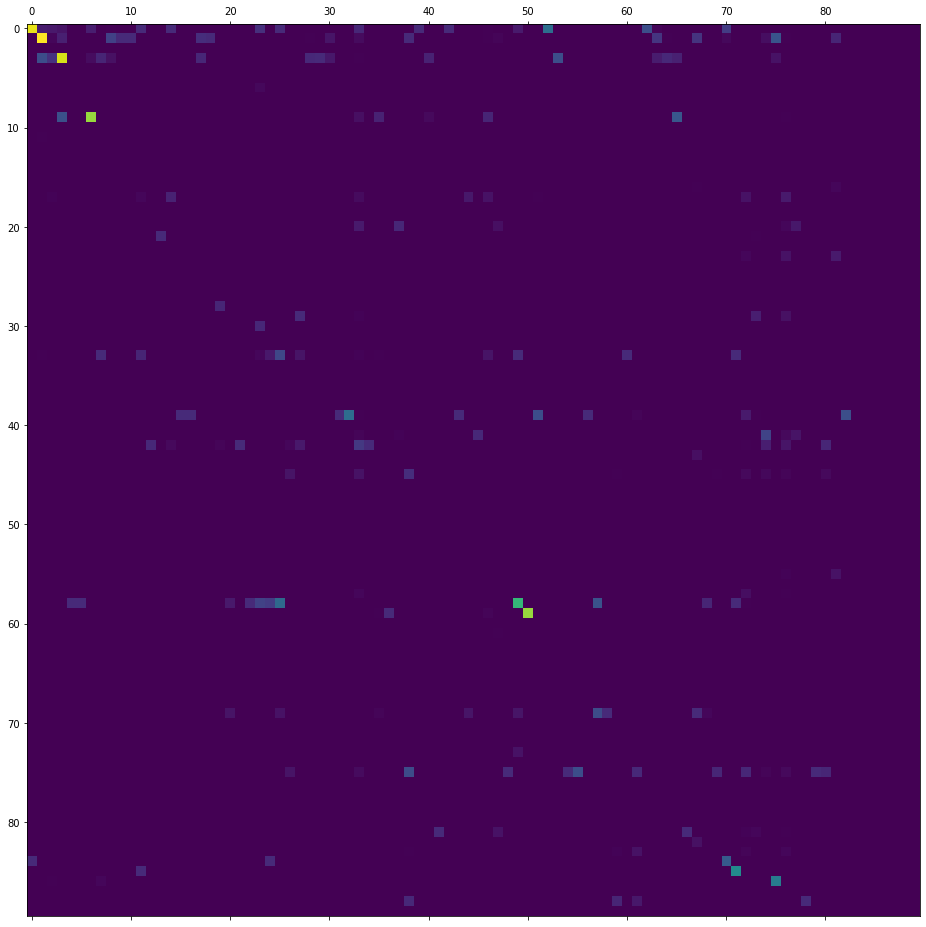

In [27]:
plt.rcParams["figure.figsize"] = (50, 50)
plt.matshow(confusion_matrix)
plt.show()



In [229]:
len(selected_col)

18763

In [8]:
small_data = []
for i in range(len(le.classes_)):
    if sum(Y == i) < 1100:
        small_data.append(le.classes_[i])
    

['CD4 Treg [BTC000243]',
 'Goblet cell [BTC000180]',
 'HEK293T cell [BTC000365]',
 'Langerhans cell [BTC000028]',
 'M1 macrophage [BTC000316]',
 'M2 macrophage [BTC000317]',
 'Schwann cell [BTC000057]',
 'T follicular helper cell [BTC000090]',
 'T helper 1 cell [BTC000321]',
 'T helper 17 cell [BTC000153]',
 'T helper 2 cell [BTC000322]',
 'Tuft cell [BTC000182]',
 'alveolar cell [BTC000124]',
 'alveolar macrophage [BTC000156]',
 'alveolar type 1 cell [BTC000129]',
 'alveolar type 2 cell [BTC000133]',
 'artery endothelial cell [BTC000342]',
 'basal cell [BTC000241]',
 'cancer cell [BTC000293]',
 'cancer-associated fibroblast [BTC000104]',
 'central memory CD4 T cell [BTC000245]',
 'choriocapillaris endothelial cell [BTC000371]',
 'ciliated columnar epithelial cell [BTC000277]',
 'club cell [BTC000123]',
 'conventional dendritic cell [BTC000026]',
 'conventional type 1 dendritic cell [BTC000192]',
 'conventional type 2 dendritic cell [BTC000194]',
 'effector CD8 T cell [BTC000213]',
 'e

In [122]:
len(glob.glob('/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/*'))

41

Test : 0.3173943661971831


In [34]:
barcodes = [x.split('_')[-1] for x in Y_origin]
le = preprocessing.LabelEncoder()                                                                                                                                         
le.fit(barcodes)

barcodes = le.transform(barcodes)


In [79]:
list_study_path

['/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE140228_10X',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/AN1801',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/E-MTAB-6149_all',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/E-MTAB-6149_t',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE110686',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE114725',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE115978',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE123814_BCC',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE123904_human',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE124310']

Score : 0.9148216817537355
Test : 0.8878148053930298


In [43]:

filename = 'test_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [44]:
filename = 'encoder_model.sav'
pickle.dump(le, open(filename, 'wb'))

In [4]:
import pickle
filename = 'test_model.sav'
clf = pickle.load(open(filename,'rb'))
filename = 'encoder_model.sav'
le = pickle.load(open(filename,'rb'))

In [125]:
filename = 'test_data.sav'
data = pickle.load(open(filename,'rb'))

In [126]:
data.shape

(25474, 18763)

In [127]:
data = data[:, selected_col]



In [129]:
res = clf.predict(data)
print(le.classes_[res])
[1, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 4, 3, 4, 3, 1, 2, 3, 1, 3, 3, 3, 3, 2, 4, 3, 4, 3, 2, 2, 2, 3, 3, 4, 2, 2, 4, 2, 3, 2, 1, 3, 1, 3, 3, 2, 2, 1, 1, 3, 3, 2, 1, 3, 3, 1, 3, 2, 1, 4, 2, 3, 3, 2, 3, 1, 3, 1, 2, 3, 3, 2, 3, 3, 2, 3, 1, 4, 3, 2, 2, 3, 2, 3, 1, 2, 4, 3, 2, 3, 3, 3, 2, 4, 1, 4, 3, 1, 4, 2, 1, 1, 1, 1, 2, 4, 3, 1, 3, 3, 3, 2, 4, 4, 1, 4, 2, 1, 3, 3, 3, 4, 1, 2, 4, 3, 3, 2, 2, 1, 3, 1, 2, 3, 1, 2, 2, 2, 3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 4, 2, 2, 1, 4, 2, 3, 1, 3, 1, 4, 3, 3, 3, 2, 4, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 4, 3, 2, 3, 2, 1, 3, 2, 3, 2, 3, 1, 4, 2, 3, 2, 3, 1, 3, 4, 3, 3, 1, 2, 3, 4, 3, 2, 3, 4, 3, 3, 2, 4, 2, 3, 1, 3, 3, 4, 4, 3, 3, 2, 3, 3, 4, 3, 4, 3, 3, 2, 2, 1, 4, 3, 4, 3, 4, 3, 2, 3, 2, 2, 2, 4, 2, 3, 2, 4, 2, 2, 3, 2, 3, 3, 3, 4, 2, 3, 4, 1, 3, 3, 3, 3, 2, 1, 1, 4, 2, 3, 3, 3, 3, 1, 2, 4, 3, 3, 3, 4, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 4, 4, 3, 1, 3, 3, 2, 1, 2, 3, 2, 3, 1, 1, 1, 3, 3, 3, 2, 2, 3, 4, 3, 3, 1, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 1, 3, 4, 2, 3, 3, 1, 2, 1, 1, 4, 3, 3, 1, 3, 1, 3, 4, 2, 2, 2, 1, 1, 2, 3, 3, 4, 1, 2, 1, 2, 4, 2, 2, 4, 3, 3, 1, 3, 3, 3, 1, 3, 1, 2, 4, 3, 2, 2, 4, 2, 3, 3, 3, 3, 3, 2, 4, 2, 1, 1, 2, 3, 1, 3, 1, 2, 2, 3, 3, 2, 4, 4, 2, 3, 3, 2, 3, 2, 3, 3, 3, 4, 2, 2, 3, 1, 3, 3, 1, 3, 4, 1, 1, 3, 3, 2, 2, 2, 1, 2, 3, 2, 4, 3, 1, 3, 1, 1, 3, 2, 4, 3, 2, 4, 2, 2, 3, 4, 4, 1, 3, 2, 3, 2, 1, 3, 1, 2, 2, 4, 3, 2, 3, 1, 2, 1, 1, 2, 1, 4, 1, 4, 3, 1, 3, 2, 2, 1, 3, 2, 1, 2, 3, 3, 2, 3, 3, 3, 1, 2, 2, 1, 3, 1, 2, 1, 2, 1, 3, 1, 2, 3, 3, 3, 3, 2, 3, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 4, 2, 2, 3, 2, 4, 2, 3, 2, 2, 3, 2, 3, 1, 2, 3, 3, 4, 3, 4, 1, 4, 2, 2, 2, 4, 3, 2, 1, 4, 3, 2, 3, 4, 1, 3, 3, 1, 4, 2, 4, 4, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 4, 4, 2, 3, 2, 4, 3, 3, 4, 1, 4, 2, 3, 3, 3, 1, 3, 4, 2, 2, 2, 3, 3, 4, 2, 4, 2, 3, 3, 3, 2, 3, 2, 2, 3, 4, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 3, 3, 2, 4, 3, 2, 3, 3, 1, 4, 4, 3, 3, 3, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 2, 1, 3, 2, 3, 3, 2, 3, 2, 3, 1, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 2, 2, 3, 1, 1, 4, 2, 4, 3, 3, 4, 2, 2, 2, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3, 4, 3, 2, 4, 1, 4, 4, 1, 1, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 4, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 2, 4, 3, 1, 4, 2, 3, 3, 2, 4, 4, 4, 1, 3, 2, 3, 2, 2, 2, 2, 4, 3, 2, 1, 3, 1, 2, 3, 3, 4, 1, 2, 1, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 4, 2, 3, 3, 3, 1, 2, 2, 3, 2, 4, 1, 3, 3, 1, 4, 4, 1, 3, 2, 3, 3, 3, 1, 2, 1, 3, 1, 3, 3, 3, 3, 4, 2, 3, 1, 2, 2, 3, 4, 4, 3, 2, 1, 3, 2, 4, 2, 2, 4, 1, 3, 3, 2, 2, 4, 2, 3, 1, 3, 3, 3, 1, 1, 2, 1, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 3, 3, 3, 3, 4, 1, 3, 3, 3, 3, 4, 4, 3, 3, 4, 2, 4, 3, 2, 3, 3, 3, 2, 3, 3, 4, 3, 3, 2, 4, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 4, 1, 1, 3, 2, 1, 1, 2, 1, 1, 3, 1, 3, 3, 3, 4, 2, 1, 3, 2, 3, 4, 2, 3, 3, 3, 4, 2, 3, 2, 2, 2, 3, 2, 3, 1, 3, 4, 1, 1, 2, 1, 3, 2, 2, 1, 2, 3, 2, 3, 1, 2, 3, 3, 4, 2, 4, 3, 3, 1, 2, 3, 3, 2, 2, 2, 3, 1, 2, 1, 1, 3, 2, 2, 2, 4, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 4, 3, 1, 1, 3, 2, 1, 3, 1, 3, 4, 3, 3, 3, 3, 2, 1, 3, 3, 2, 3, 2, 2, 1, 3, 2, 3, 4, 3, 1, 3, 3, 4, 3, 4, 2, 2, 2, 1, 2, 2, 3, 1, 1, 3, 1, 2, 2, 4, 2, 1, 4, 1, 3, 3, 2, 1, 3, 2, 3, 1, 1, 4, 1, 3, 3, 3, 2, 1, 3, 3, 2, 3, 4, 2, 2, 1, 4, 3, 3, 3, 3, 2, 2, 2, 3, 4, 2, 3, 1, 3, 2, 2, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 3, 4, 2, 2, 3, 1, 4, 4, 1, 2, 3, 3, 3, 3, 3, 4, 3, 1, 1, 4, 3, 2, 4, 2, 3, 4, 3, 3, 3, 1, 1, 4, 2, 3, 3, 3, 2, 2, 2, 3, 3, 1, 3, 2, 1, 2, 3, 3, 4, 3, 3, 2, 1, 3, 4, 2, 2, 3, 1, 3, 2, 1, 3, 3, 2, 3, 3, 1, 4, 3, 2, 2, 3, 4, 4, 3, 4, 3, 1, 1, 1, 1, 3, 2, 2, 4, 3, 2, 3, 3, 3, 1, 1, 3, 2, 1, 2, 2, 3, 3, 4, 2, 1, 3, 1, 3, 1, 1, 2, 2, 3, 2, 3, 2, 1, 2, 4, 2, 2, 3, 4, 3, 1, 3, 4, 3, 2, 3, 2, 3, 4, 3, 3, 1, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 4, 4, 1, 3, 2, 2, 1, 2, 3, 1, 4, 3, 3, 2, 3, 3, 3, 4, 2, 2, 3, 2, 1, 4, 3, 2, 2, 4, 2, 1, 3, 4, 4, 2, 2, 4, 1, 4, 2, 3, 3, 3, 3, 4, 3, 3, 2, 3, 2, 4, 3, 3, 2, 4, 3, 1, 1, 1, 3, 2, 2, 4, 1, 3, 4, 4, 3, 2, 2, 4, 3, 1, 3, 4, 2, 3, 3, 4, 2, 3, 3, 3, 2, 1, 3, 3, 2, 1, 1, 3, 3, 1, 4, 3, 2, 2, 1, 2, 1, 1, 3, 2, 4, 2, 3, 4, 3, 4, 1, 3, 1, 3, 3, 1, 4, 2, 3, 3, 3, 2, 2, 3, 2, 1, 2, 4, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 1, 2, 3, 4, 1, 4, 2, 1, 3, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 3, 1, 3, 2, 3, 1, 3, 4, 1, 1, 3, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 4, 3, 3, 4, 2, 3, 3, 2, 1, 1, 2, 3, 3, 3, 2, 1, 3, 4, 3, 3, 2, 3, 1, 2, 4, 1, 3, 4, 4, 1, 3, 2, 2, 3, 2, 3, 3, 3, 4, 4, 2, 3, 3, 4, 4, 2, 2, 3, 3, 1, 3, 2, 1, 3, 2, 3, 3, 4, 4, 2, 3, 3, 3, 3, 2, 3, 2, 3, 1, 3, 3, 2, 2, 3, 3, 2, 1, 2, 1, 3, 1, 3, 2, 3, 2, 2, 2, 3, 4, 1, 3, 2, 2, 3, 4, 3, 4, 2, 4, 2, 3, 3, 2, 3, 4, 4, 3, 2, 1, 2, 2, 4, 1, 2, 3, 3, 3, 4, 3, 2, 2, 1, 2, 4, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 1, 3, 3, 2, 2, 1, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 1, 3, 4, 2, 4, 1, 3, 3, 3, 2, 1, 1, 3, 1, 3, 3, 4, 2, 1, 1, 1, 1, 1, 2, 3, 3, 3, 2, 2, 1, 3, 2, 2, 3, 3, 1, 1, 4, 3, 2, 1, 4, 2, 4, 2, 2, 3, 4, 4, 3, 4, 1, 3, 3, 2, 2, 3, 1, 4, 2, 3, 3, 2, 3, 2, 1, 3, 3, 1, 1, 3, 1, 4, 2, 3, 3, 3, 3, 1, 1, 3, 2, 4, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 2, 1, 3, 1, 4, 2, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 2, 3, 3, 2, 4, 2, 4, 3, 1, 5, 5, 6, 5, 5, 6, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 6, 7, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 5, 6, 5, 5, 5, 6, 5, 6, 6, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 7, 5, 6, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 6, 5, 5, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 7, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 7, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 7, 6, 5, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 7, 5, 6, 5, 5, 5, 5, 5, 6, 7, 7, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 7, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 6, 7, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 7, 5, 6, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 6, 5, 7, 5, 5, 6, 6, 5, 5, 6, 5, 5, 5, 7, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 7, 6, 6, 5, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 7, 7, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 7, 6, 6, 5, 5, 6, 6, 5, 5, 7, 6, 5, 5, 6, 6, 5, 5, 5, 5, 7, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 7, 5, 6, 5, 6, 5, 5, 5, 7, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5, 7, 7, 6, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 6, 7, 5, 5, 5, 5, 7, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 7, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 7, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 6, 7, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 7, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 7, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5, 7, 6, 7, 5, 5, 5, 5, 5, 6, 5, 5, 6, 7, 5, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 6, 5, 5, 7, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 7, 6, 6, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 7, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6, 7, 6, 7, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 7, 6, 5, 6, 5, 6, 5, 5, 6, 5, 6, 5, 5, 5, 7, 7, 6, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 7, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 5, 6, 6, 5, 5, 5, 6, 6, 5, 6, 5, 7, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 7, 6, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 6, 7, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 5, 6, 6, 6, 5, 7, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 7, 6, 6, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 7, 6, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 5, 6, 5, 5, 6, 5, 1, 4, 3, 2, 4, 1, 3, 1, 3, 1, 4, 2, 4, 1, 1, 1, 4, 3, 1, 1, 4, 3, 1, 4, 4, 1, 4, 3, 1, 1, 1, 4, 1, 1, 1, 1, 3, 4, 4, 1, 3, 4, 2, 4, 4, 1, 4, 1, 4, 2, 4, 4, 1, 3, 2, 3, 1, 1, 3, 4, 3, 3, 1, 1, 4, 1, 1, 3, 3, 1, 3, 1, 3, 3, 4, 3, 3, 1, 3, 4, 4, 4, 3, 1, 4, 1, 1, 3, 4, 1, 1, 1, 4, 1, 4, 1, 1, 3, 1, 1, 1, 1, 4, 4, 1, 1, 3, 4, 4, 4, 1, 3, 4, 2, 3, 3, 1, 4, 1, 1, 1, 3, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 4, 2, 1, 2, 3, 1, 1, 1, 1, 1, 4, 4, 1, 4, 4, 1, 3, 3, 1, 2, 1, 4, 1, 4, 3, 3, 1, 1, 1, 2, 1, 3, 4, 1, 3, 1, 1, 2, 1, 4, 1, 3, 1, 1, 1, 1, 4, 3, 1, 1, 4, 3, 1, 1, 1, 1, 2, 1, 4, 1, 4, 2, 3, 4, 2, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 2, 2, 3, 1, 1, 2, 4, 4, 1, 1, 1, 4, 1, 3, 3, 1, 3, 1, 1, 4, 4, 4, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 1, 1, 4, 4, 2, 1, 3, 4, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 3, 4, 1, 1, 1, 4, 4, 1, 1, 1, 4, 3, 1, 3, 4, 4, 4, 1, 1, 3, 4, 1, 4, 4, 4, 1, 3, 4, 3, 1, 1, 3, 1, 1, 1, 1, 3, 4, 3, 4, 1, 2, 4, 4, 1, 2, 1, 1, 1, 4, 3, 4, 1, 4, 3, 3, 1, 1, 1, 1, 1, 3, 2, 4, 1, 2, 1, 2, 2, 1, 3, 1, 1, 2, 3, 2, 3, 1, 1, 4, 3, 4, 3, 4, 3, 2, 3, 4, 3, 1, 1, 4, 1, 1, 1, 1, 3, 1, 4, 3, 3, 4, 1, 1, 1, 1, 3, 4, 4, 4, 1, 3, 1, 2, 1, 4, 4, 1, 1, 3, 1, 4, 3, 1, 4, 1, 2, 2, 1, 1, 4, 3, 3, 4, 4, 4, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 1, 1, 2, 1, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 1, 1, 3, 3, 1, 4, 3, 4, 1, 1, 1, 4, 3, 4, 3, 2, 4, 1, 3, 4, 2, 1, 1, 2, 3, 4, 1, 4, 3, 3, 4, 1, 3, 1, 4, 2, 1, 3, 4, 1, 3, 3, 2, 1, 1, 4, 4, 3, 4, 4, 1, 3, 1, 3, 3, 1, 1, 3, 2, 4, 3, 1, 1, 4, 2, 1, 3, 1, 1, 1, 3, 1, 1, 2, 3, 1, 3, 2, 2, 3, 4, 1, 4, 1, 1, 1, 2, 2, 1, 2, 2, 4, 3, 2, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 2, 1, 4, 4, 1, 1, 1, 1, 4, 1, 1, 3, 4, 4, 4, 1, 1, 4, 3, 1, 4, 3, 1, 1, 1, 1, 3, 3, 4, 1, 4, 4, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 4, 4, 1, 1, 2, 3, 1, 2, 3, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 3, 1, 1, 2, 3, 2, 4, 1, 1, 1, 4, 1, 2, 4, 4, 3, 2, 1, 1, 4, 1, 1, 3, 1, 1, 1, 1, 1, 4, 1, 4, 4, 2, 4, 4, 4, 1, 1, 4, 2, 3, 4, 3, 1, 1, 1, 4, 1, 1, 3, 3, 1, 1, 4, 4, 1, 2, 1, 1, 1, 1, 3, 3, 4, 3, 3, 2, 4, 2, 1, 3, 3, 1, 1, 2, 1, 4, 2, 3, 1, 2, 1, 3, 4, 2, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 1, 3, 1, 3, 1, 4, 1, 4, 3, 1, 4, 1, 4, 3, 4, 4, 3, 4, 1, 4, 1, 3, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 3, 1, 2, 1, 1, 4, 2, 4, 3, 1, 1, 2, 4, 3, 1, 1, 1, 4, 1, 4, 4, 1, 2, 2, 3, 4, 1, 3, 3, 1, 4, 1, 1, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 3, 4, 3, 3, 1, 4, 1, 4, 4, 3, 4, 2, 1, 4, 3, 1, 4, 4, 1, 3, 3, 1, 1, 1, 3, 1, 1, 4, 1, 1, 3, 3, 2, 1, 2, 3, 1, 4, 1, 2, 3, 1, 4, 1, 2, 1, 2, 4, 3, 1, 2, 4, 2, 3, 1, 4, 3, 3, 4, 1, 4, 3, 3, 1, 2, 3, 1, 2, 1, 3, 4, 2, 4, 4, 1, 3, 4, 4, 3, 4, 2, 1, 1, 4, 1, 4, 1, 3, 1, 1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 1, 1, 1, 1, 3, 3, 4, 3, 1, 1, 4, 3, 4, 4, 1, 1, 1, 2, 4, 1, 1, 1, 2, 3, 4, 1, 1, 3, 1, 4, 2, 4, 1, 1, 4, 3, 1, 3, 1, 3, 3, 4, 1, 4, 1, 1, 3, 3, 1, 1, 3, 4, 1, 4, 3, 1, 2, 3, 1, 4, 4, 1, 2, 1, 1, 3, 4, 4, 1, 4, 4, 4, 1, 2, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 2, 1, 3, 3, 1, 1, 2, 1, 3, 1, 1, 4, 1, 3, 2, 3, 4, 1, 1, 1, 1, 1, 4, 3, 1, 1, 4, 1, 1, 3, 1, 3, 2, 3, 4, 4, 2, 3, 1, 1, 1, 4, 2, 1, 3, 4, 1, 4, 4, 1, 4, 4, 2, 1, 3, 1, 1, 3, 1, 4, 3, 2, 3, 4, 1, 3, 1, 1, 1, 1, 2, 3, 2, 1, 3, 2, 4, 1, 1, 1, 4, 1, 1, 1, 3, 1, 2, 1, 2, 3, 1, 3, 4, 1, 3, 1, 3, 1, 1, 1, 4, 4, 2, 4, 1, 4, 1, 4, 3, 1, 1, 1, 1, 2, 4, 4, 4, 3, 3, 3, 3, 1, 4, 3, 1, 4, 3, 1, 1, 4, 4, 1, 3, 1, 1, 1, 1, 3, 3, 3, 2, 4, 1, 4, 3, 1, 3, 3, 4, 3, 3, 3, 2, 1, 1, 4, 4, 1, 1, 1, 4, 1, 3, 3, 4, 1, 4, 1, 3, 4, 1, 1, 4, 3, 4, 2, 1, 1, 3, 4, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 4, 1, 4, 1, 3, 2, 3, 1, 4, 2, 4, 1, 4, 1, 1, 2, 1, 4, 4, 3, 4, 4, 1, 3, 4, 2, 4, 4, 1, 3, 4, 1, 4, 1, 1, 1, 2, 4, 2, 3, 3, 2, 1, 1, 2, 1, 1, 4, 3, 3, 1, 1, 4, 1, 3, 4, 1, 1, 1, 3, 4, 3, 1, 4, 1, 1, 3, 2, 4, 4, 4, 1, 1, 4, 4, 4, 1, 4, 1, 1, 1, 4, 4, 3, 2, 4, 1, 4, 4, 2, 3, 4, 4, 4, 3, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 3, 1, 3, 4, 1, 2, 1, 4, 2, 1, 4, 4, 1, 1, 3, 4, 3, 4, 1, 4, 3, 1, 1, 3, 2, 3, 3, 3, 1, 4, 1, 3, 4, 3, 3, 1, 4, 1, 1, 2, 2, 1, 2, 3, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 1, 2, 1, 1, 4, 1, 4, 1, 1, 1, 4, 2, 1, 4, 4, 1, 1, 4, 4, 2, 4, 1, 3, 1, 2, 2, 1, 4, 2, 3, 4, 3, 2, 4, 1, 3, 1, 1, 1, 2, 3, 3, 1, 1, 4, 3, 4, 4, 1, 3, 4, 2, 1, 2, 3, 2, 4, 2, 3, 3, 3, 1, 4, 4, 4, 1, 4, 4, 3, 1, 1, 1, 2, 2, 1, 4, 3, 1, 1, 1, 1, 1, 1, 3, 4, 4, 1, 2, 4, 1, 2, 1, 4, 3, 1, 2, 1, 2, 2, 2, 1, 1, 4, 3, 4, 4, 1, 3, 1, 1, 1, 4, 4, 3, 3, 4, 1, 3, 2, 2, 4, 4, 1, 4, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 3, 2, 4, 4, 1, 3, 1, 4, 3, 3, 2, 4, 1, 1, 4, 2, 4, 4, 4, 4, 1, 1, 1, 1, 3, 4, 1, 1, 1, 3, 4, 2, 3, 1, 3, 1, 1, 1, 4, 4, 3, 1, 1, 4, 1, 4, 3, 2, 2, 3, 1, 1, 3, 3, 4, 1, 1, 1, 4, 1, 1, 3, 1, 1, 3, 1, 1, 2, 1, 2, 3, 1, 4, 4, 1, 3, 2, 3, 3, 1, 1, 3, 1, 1, 4, 1, 1, 1, 4, 1, 1, 3, 3, 1, 4, 1, 2, 1, 3, 1, 1, 3, 1, 3, 1, 2, 3, 3, 4, 1, 1, 4, 1, 4, 4, 3, 3, 1, 1, 1, 4, 4, 4, 2, 4, 2, 4, 4, 3, 4, 3, 4, 1, 1, 3, 1, 1, 2, 4, 3, 3, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 4, 1, 2, 4, 1, 1, 3, 4, 3, 3, 3, 4, 4, 1, 4, 4, 4, 1, 1, 2, 1, 4, 1, 1, 2, 4, 2, 3, 3, 4, 1, 4, 1, 1, 3, 3, 4, 1, 1, 2, 2, 1, 1, 2, 1, 4, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 1, 2, 3, 4, 3, 1, 4, 1, 4, 3, 1, 4, 3, 1, 2, 3, 1, 4, 4, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 4, 1, 1, 1, 3, 1, 4, 1, 1, 4, 1, 1, 4, 3, 3, 1, 3, 1, 3, 2, 2, 1, 1, 1, 4, 1, 1, 1, 1, 4, 4, 3, 1, 3, 1, 4, 1, 4, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 2, 3, 2, 4, 1, 1, 1, 4, 4, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 4, 1, 2, 1, 1, 3, 1, 4, 3, 2, 4, 4, 1, 3, 4, 4, 3, 1, 1, 4, 1, 3, 1, 3, 2, 1, 4, 2, 1, 4, 4, 1, 1, 1, 2, 1, 4, 4, 3, 1, 2, 2, 4, 3, 2, 1, 1, 4, 4, 1, 3, 4, 1, 3, 4, 3, 3, 2, 4, 4, 4, 1, 2, 4, 2, 4, 4, 4, 2, 3, 4, 4, 3, 1, 2, 2, 1, 1, 1, 1, 3, 1, 4, 3, 4, 1, 4, 2, 1, 1, 3, 4, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 4, 3, 1, 4, 2, 4, 2, 4, 4, 4, 4, 1, 3, 1, 4, 3, 3, 1, 2, 1, 2, 1, 1, 4, 1, 4, 4, 1, 2, 1, 2, 4, 3, 4, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 3, 3, 1, 4, 1, 1, 1, 4, 4, 1, 4, 2, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 4, 1, 4, 4, 3, 1, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 3, 1, 1, 2, 1, 1, 3, 1, 3, 1, 1, 4, 1, 4, 1, 4, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 4, 1, 4, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 4, 1, 1, 3, 3, 1, 4, 3, 1, 3, 4, 4, 4, 3, 1, 1, 3, 4, 1, 3, 3, 1, 1, 1, 1, 3, 2, 2, 2, 1, 3, 1, 1, 4, 1, 1, 3, 3, 4, 4, 2, 1, 4, 4, 1, 2, 4, 1, 1, 2, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 3, 2, 3, 3, 3, 1, 1, 4, 2, 4, 1, 2, 3, 1, 3, 4, 1, 1, 4, 1, 2, 3, 4, 1, 4, 4, 4, 3, 2, 2, 1, 4, 3, 2, 3, 3, 1, 1, 4, 1, 1, 2, 3, 1, 3, 1, 4, 1, 4, 2, 2, 1, 3, 4, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 4, 1, 3, 3, 3, 1, 2, 4, 3, 4, 3, 1, 1, 1, 1, 1, 1, 3, 4, 1, 3, 1, 2, 3, 3, 1, 1, 1, 4, 4, 3, 1, 1, 3, 4, 3, 4, 1, 3, 4, 4, 1, 4, 4, 1, 3, 1, 4, 4, 4, 2, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 4, 1, 4, 4, 1, 1, 1, 3, 1, 1, 4, 3, 2, 4, 3, 4, 3, 2, 1, 4, 4, 4, 3, 3, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 4, 1, 4, 4, 2, 3, 2, 1, 3, 1, 2, 1, 1, 4, 1, 2, 1, 1, 4, 4, 3, 1, 1, 1, 3, 1, 1, 4, 2, 3, 4, 1, 1, 1, 1, 4, 4, 1, 1, 1, 4, 2, 4, 1, 3, 2, 1, 4, 1, 4, 3, 1, 1, 4, 1, 4, 4, 1, 1, 2, 1, 1, 4, 1, 4, 1, 4, 3, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 3, 4, 1, 2, 4, 3, 1, 4, 1, 3, 1, 3, 1, 1, 1, 3, 4, 1, 3, 1, 1, 3, 2, 1, 4, 1, 3, 4, 2, 3, 3, 1, 2, 1, 3, 1, 4, 1, 1, 4, 3, 3, 4, 4, 2, 1, 3, 1, 1, 1, 1, 4, 4, 3, 4, 3, 3, 4, 3, 1, 4, 1, 4, 1, 1, 1, 4, 1, 2, 3, 1, 2, 3, 1, 1, 1, 4, 1, 3, 1, 4, 1, 4, 1, 3, 3, 4, 4, 2, 3, 1, 3, 4, 1, 2, 2, 2, 1, 4, 2, 1, 3, 3, 1, 3, 1, 3, 1, 3, 4, 4, 1, 2, 4, 4, 1, 1, 3, 2, 1, 4, 1, 3, 1, 4, 3, 3, 1, 2, 3, 3, 3, 1, 1, 3, 4, 1, 4, 1, 4, 2, 3, 4, 2, 2, 3, 4, 1, 4, 3, 4, 4, 4, 2, 3, 1, 4, 1, 1, 4, 2, 1, 2, 4, 3, 2, 4, 4, 4, 1, 2, 4, 1, 1, 1, 1, 3, 2, 4, 1, 1, 4, 1, 1, 3, 1, 2, 2, 1, 3, 1, 4, 2, 1, 1, 3, 2, 2, 1, 3, 1, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 1, 4, 1, 4, 1, 1, 2, 1, 1, 3, 3, 1, 4, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 4, 2, 3, 1, 1, 4, 1, 4, 1, 1, 1, 1, 4, 3, 1, 3, 1, 4, 1, 4, 1, 4, 1, 3, 3, 2, 1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 2, 1, 3, 4, 1, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1, 3, 1, 3, 2, 3, 1, 3, 4, 3, 2, 1, 1, 1, 1, 4, 4, 4, 1, 2, 4, 4, 1, 3, 2, 3, 4, 2, 1, 1, 1, 1, 3, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 2, 4, 4, 4, 1, 2, 4, 1, 1, 1, 4, 1, 4, 1, 4, 1, 1, 4, 2, 3, 4, 1, 2, 3, 4, 1, 3, 4, 1, 2, 2, 1, 4, 1, 4, 1, 1, 3, 4, 1, 1, 1, 2, 1, 3, 2, 1, 3, 4, 1, 1, 3, 1, 1, 4, 3, 1, 1, 1, 3, 2, 1, 4, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3, 1, 4, 4, 1, 1, 3, 3, 1, 2, 1, 2, 4, 1, 4, 4, 1, 4, 3, 1, 3, 2, 4, 4, 1, 4, 4, 1, 4, 4, 1, 2, 4, 2, 4, 2, 4, 1, 3, 1, 3, 2, 1, 1, 2, 4, 4, 4, 4, 3, 2, 1, 4, 4, 2, 1, 4, 4, 1, 1, 1, 1, 3, 2, 4, 1, 4, 1, 2, 1, 1, 3, 4, 4, 3, 4, 3, 1, 4, 1, 2, 4, 1, 4, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 2, 4, 4, 1, 4, 1, 1, 4, 1, 1, 2, 1, 1, 1, 4, 1, 3, 4, 4, 1, 1, 4, 3, 2, 2, 1, 4, 1, 4, 1, 4, 1, 4, 1, 1, 4, 4, 1, 4, 1, 3, 2, 4, 1, 4, 3, 1, 1, 1, 1, 3, 2, 2, 2, 1, 3, 3, 1, 2, 1, 1, 4, 2, 4, 1, 4, 3, 3, 3, 4, 4, 1, 1, 4, 1, 1, 2, 3, 1, 4, 4, 4, 3, 3, 2, 3, 3, 1, 1, 2, 4, 4, 1, 2, 3, 4, 4, 1, 3, 4, 2, 1, 1, 1, 4, 1, 4, 1, 4, 2, 3, 3, 2, 1, 4, 3, 1, 1, 4, 1, 1, 1, 3, 1, 1, 4, 1, 1, 1, 3, 2, 1, 1, 1, 3, 4, 4, 4, 1, 1, 1, 2, 1, 4, 1, 3, 1, 1, 1, 3, 2, 3, 4, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 4, 3, 2, 3, 1, 1, 3, 2, 4, 1, 1, 1, 3, 4, 3, 1, 3, 4, 1, 3, 3, 1, 1, 3, 1, 1, 2, 4, 1, 1, 4, 4, 4, 3, 4, 1, 1, 1, 1, 3, 4, 3, 2, 1, 1, 4, 4, 1, 1, 1, 1, 2, 2, 4, 1, 1, 3, 2, 1, 3, 4, 2, 1, 3, 1, 3, 3, 3, 1, 1, 4, 1, 1, 3, 1, 1, 4, 2, 4, 3, 1, 4, 1, 4, 3, 1, 4, 2, 4, 4, 2, 1, 1, 1, 3, 1, 3, 1, 4, 3, 2, 1, 1, 3, 4, 1, 2, 3, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 3, 4, 4, 1, 1, 5, 5, 5, 5, 5, 7, 5, 5, 8, 7, 5, 6, 6, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 7, 7, 7, 5, 5, 7, 5, 6, 5, 7, 7, 7, 6, 5, 7, 5, 5, 7, 8, 5, 5, 7, 7, 5, 8, 5, 5, 5, 8, 7, 5, 7, 6, 5, 5, 7, 7, 7, 8, 5, 5, 8, 7, 5, 5, 7, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 7, 5, 7, 7, 5, 5, 5, 6, 5, 7, 5, 6, 7, 5, 5, 7, 5, 5, 5, 6, 7, 5, 5, 5, 7, 5, 5, 7, 5, 7, 5, 5, 6, 6, 5, 7, 5, 5, 7, 7, 7, 6, 6, 7, 7, 7, 7, 5, 5, 5, 6, 5, 5, 5, 7, 7, 5, 7, 5, 7, 7, 5, 5, 5, 8, 6, 5, 5, 7, 5, 7, 5, 5, 8, 5, 7, 7, 8, 6, 5, 7, 7, 7, 7, 7, 7, 7, 5, 7, 5, 5, 5, 5, 7, 7, 5, 7, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 5, 5, 5, 7, 5, 7, 7, 6, 7, 5, 7, 7, 5, 5, 7, 5, 6, 8, 8, 7, 7, 5, 7, 8, 7, 5, 5, 8, 7, 5, 5, 7, 7, 5, 7, 5, 5, 8, 6, 5, 8, 5, 7, 7, 5, 5, 5, 7, 8, 8, 5, 7, 5, 8, 5, 7, 5, 8, 7, 5, 5, 7, 7, 7, 5, 6, 7, 8, 7, 7, 5, 5, 7, 7, 5, 5, 5, 5, 5, 7, 7, 8, 8, 7, 5, 6, 5, 5, 8, 5, 7, 5, 5, 5, 7, 7, 5, 5, 7, 7, 7, 5, 7, 7, 7, 5, 5, 5, 5, 8, 5, 5, 5, 6, 6, 5, 7, 7, 5, 5, 7, 7, 7, 7, 7, 5, 5, 8, 7, 5, 5, 7, 7, 7, 6, 5, 5, 7, 5, 5, 8, 7, 5, 5, 5, 8, 5, 6, 5, 5, 5, 7, 8, 5, 8, 5, 6, 7, 5, 8, 7, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 5, 5, 7, 7, 5, 5, 5, 7, 5, 7, 7, 7, 7, 6, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 7, 7, 8, 5, 7, 8, 6, 5, 7, 8, 5, 7, 7, 7, 5, 7, 7, 7, 7, 5, 7, 7, 5, 8, 5, 7, 8, 5, 5, 7, 5, 5, 5, 7, 7, 7, 5, 7, 5, 5, 7, 7, 7, 7, 8, 6, 8, 7, 7, 7, 6, 5, 6, 5, 8, 5, 5, 7, 7, 6, 7, 6, 6, 5, 5, 5, 5, 7, 5, 6, 5, 7, 7, 5, 5, 7, 5, 7, 5, 5, 5, 5, 8, 7, 5, 5, 7, 5, 5, 5, 8, 5, 7, 7, 7, 8, 7, 8, 6, 6, 5, 5, 5, 8, 5, 8, 5, 7, 6, 5, 8, 5, 6, 5, 8, 7, 5, 5, 5, 7, 8, 5, 8, 6, 6, 6, 5, 6, 7, 5, 7, 5, 7, 7, 7, 7, 5, 5, 7, 5, 7, 7, 5, 5, 7, 5, 5, 7, 7, 7, 7, 7, 6, 7, 7, 7, 5, 8, 7, 8, 7, 5, 7, 5, 5, 6, 5, 7, 5, 5, 7, 7, 7, 5, 8, 7, 6, 5, 7, 7, 5, 6, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 7, 6, 7, 5, 6, 5, 7, 5, 7, 5, 5, 7, 5, 7, 7, 5, 8, 7, 6, 7, 7, 5, 7, 5, 7, 7, 5, 8, 7, 6, 7, 7, 7, 5, 5, 5, 7, 7, 7, 5, 7, 7, 7, 7, 5, 7, 5, 7, 7, 5, 7, 7, 7, 5, 7, 7, 7, 5, 5, 5, 5, 7, 5, 6, 7, 7, 6, 5, 5, 5, 7, 7, 8, 5, 5, 7, 8, 8, 7, 7, 8, 5, 7, 7, 5, 6, 8, 7, 6, 7, 5, 8, 5, 5, 7, 7, 5, 5, 5, 7, 5, 5, 6, 5, 7, 8, 7, 7, 5, 5, 7, 5, 5, 5, 7, 5, 6, 7, 5, 8, 6, 5, 7, 5, 5, 8, 5, 7, 5, 7, 5, 5, 5, 7, 7, 5, 5, 7, 7, 7, 7, 7, 6, 7, 5, 7, 7, 7, 7, 7, 7, 7, 5, 7, 5, 5, 7, 5, 5, 5, 7, 7, 5, 7, 5, 5, 7, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 7, 6, 7, 8, 5, 5, 5, 7, 7, 7, 5, 7, 5, 5, 5, 5, 7, 5, 7, 5, 7, 7, 7, 5, 5, 7, 8, 5, 7, 5, 7, 7, 8, 5, 7, 8, 7, 8, 6, 8, 6, 5, 5, 7, 5, 5, 7, 5, 5, 8, 5, 6, 5, 5, 6, 5, 7, 6, 8, 5, 7, 7, 5, 7, 7, 6, 5, 5, 5, 5, 7, 8, 6, 5, 8, 6, 5, 5, 5, 5, 6, 7, 5, 5, 5, 7, 8, 5, 5, 6, 5, 7, 5, 5, 7, 5, 7, 7, 7, 5, 5, 7, 5, 5, 7, 5, 7, 7, 5, 7, 5, 5, 7, 5, 5, 7, 7, 7, 5, 5, 5, 7, 7, 8, 7, 7, 7, 7, 5, 5, 7, 5, 7, 8, 7, 5, 8, 6, 5, 6, 7, 7, 7, 7, 5, 6, 5, 7, 5, 7, 7, 5, 7, 7, 5, 7, 5, 7, 7, 5, 7, 7, 7, 5, 7, 7, 5, 7, 8, 5, 6, 5, 7, 7, 5, 7, 5, 5, 8, 7, 7, 6, 7, 7, 7, 5, 8, 7, 5, 5, 7, 7, 6, 7, 7, 7, 5, 5, 5, 5, 5, 6, 7, 5, 5, 5, 5, 7, 6, 5, 5, 8, 5, 5, 7, 7, 7, 7, 7, 5, 7, 7, 5, 7, 5, 5, 7, 8, 5, 7, 7, 7, 5, 7, 7, 7, 8, 7, 5, 5, 7, 5, 5, 7, 5, 7, 7, 5, 5, 5, 7, 7, 8, 7, 5, 7, 5, 5, 5, 6, 7, 5, 7, 5, 5, 6, 7, 6, 5, 7, 7, 6, 5, 7, 5, 7, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 8, 5, 5, 7, 5, 7, 5, 5, 5, 7, 7, 5, 5, 8, 5, 7, 6, 7, 5, 7, 7, 5, 6, 5, 5, 7, 5, 8, 7, 6, 5, 7, 7, 5, 7, 7, 7, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 8, 5, 5, 6, 5, 5, 7, 7, 5, 6, 7, 7, 8, 7, 8, 7, 7, 7, 6, 5, 5, 8, 6, 7, 5, 8, 5, 8, 7, 7, 6, 6, 5, 5, 8, 7, 7, 7, 6, 6, 5, 7, 7, 5, 5, 7, 5, 6, 5, 7, 5, 5, 5, 7, 7, 7, 5, 7, 7, 5, 7, 5, 6, 5, 7, 5, 7, 7, 5, 7, 5, 7, 5, 5, 8, 7, 5, 5, 7, 7, 7, 7, 7, 7, 5, 5, 7, 7, 7, 5, 8, 8, 5, 7, 7, 5, 5, 5, 5, 5, 7, 5, 7, 5, 7, 5, 7, 7, 7, 6, 5, 7, 5, 5, 7, 7, 7, 7, 7, 7, 5, 5, 5, 7, 6, 5, 7, 5, 5, 5, 7, 5, 7, 7, 7, 6, 5, 5, 6, 7, 5, 6, 7, 7, 7, 5, 6, 6, 8, 5, 5, 5, 5, 5, 5, 5, 7, 6, 7, 7, 7, 7, 5, 6, 5, 7, 5, 7, 7, 5, 5, 5, 7, 7, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 8, 5, 8, 5, 7, 7, 5, 5, 5, 7, 7, 7, 6, 5, 7, 7, 5, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 6, 6, 5, 5, 5, 7, 7, 5, 8, 5, 7, 5, 7, 5, 6, 7, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 5, 7, 7, 5, 7, 6, 7, 7, 5, 5, 5, 5, 7, 8, 7, 7, 5, 5, 7, 5, 6, 5, 7, 7, 5, 5, 7, 5, 5, 5, 7, 8, 5, 5, 5, 7, 7, 5, 5, 6, 5, 7, 7, 7, 5, 6, 7, 5, 7, 5, 7, 7, 7, 6, 7, 8, 5, 7, 7, 7, 5, 5, 5, 7, 7, 5, 5, 7, 5, 5, 8, 5, 7, 8, 7, 5, 8, 5, 5, 6, 5, 5, 6, 7, 8, 7, 7, 5, 5, 7, 6, 5, 7, 7, 7, 7, 7, 5, 5, 5, 8, 7, 5, 6, 7, 5, 7, 5, 6, 7, 7, 5, 7, 6, 7, 7, 5, 7, 7, 7, 7, 5, 5, 7, 5, 5, 7, 5, 5, 5, 5, 6, 7, 7, 8, 7, 5, 8, 7, 5, 7, 5, 7, 8, 7, 7, 5, 7, 8, 7, 5, 5, 7, 5, 8, 8, 5, 6, 5, 6, 8, 7, 8, 5, 5, 8, 7, 5, 5, 5, 7, 5, 7, 7, 5, 7, 6, 6, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 8, 7, 7, 5, 7, 7, 8, 7, 5, 8, 5, 7, 8, 5, 8, 7, 7, 7, 5, 7, 7, 6, 5, 7, 5, 6, 5, 5, 8, 6, 5, 5, 7, 5, 7, 7, 5, 7, 5, 6, 7, 5, 7, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 7, 5, 6, 5, 7, 5, 7, 7, 7, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 6, 7, 8, 7, 5, 5, 5, 5, 5, 5, 5, 7, 5, 7, 7, 5, 5, 7, 5, 7, 8, 5, 5, 5, 7, 7, 7, 7, 7, 5, 5, 7, 7, 5, 5, 7, 7, 5, 5, 6, 7, 7, 7, 5, 7, 8, 7, 5, 7, 7, 5, 5, 7, 5, 8, 5, 5, 7, 6, 5, 5, 7, 5, 5, 7, 5, 6, 5, 5, 8, 5, 5, 7, 7, 8, 7, 5, 7, 7, 7, 8, 7, 5, 7, 7, 7, 5, 7, 7, 8, 5, 5, 7, 7, 5, 7, 5, 5, 5, 5, 5, 5, 5, 7, 5, 8, 5, 5, 7, 7, 7, 5, 8, 5, 5, 8, 7, 5, 7, 5, 7, 6, 5, 7, 7, 7, 7, 5, 5, 5, 5, 7, 5, 7, 8, 6, 5, 7, 7, 7, 5, 5, 7, 7, 7, 5, 7, 7, 7, 8, 7, 6, 7, 5, 7, 5, 5, 6, 5, 5, 7, 7, 7, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7, 7, 5, 5, 7, 8, 5, 5, 8, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 7, 7, 5, 8, 5, 5, 5, 7, 5, 6, 7, 5, 8, 7, 5, 5, 7, 7, 7, 5, 7, 5, 5, 5, 7, 5, 5, 7, 5, 7, 5, 7, 5, 5, 5, 5, 5, 7, 5, 6, 7, 6, 7, 5, 5, 5, 5, 7, 7, 5, 7, 5, 8, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 5, 7, 7, 5, 6, 7, 8, 7, 7, 5, 7, 5, 5, 5, 7, 5, 7, 5, 6, 7, 7, 6, 7, 6, 5, 8, 5, 5, 6, 5, 5, 7, 5, 7, 7, 5, 5, 7, 8, 5, 7, 5, 6, 5, 7, 7, 7, 7, 7, 7, 5, 6, 7, 7, 7, 7, 5, 5, 7, 7, 7, 5, 5, 5, 7, 5, 5, 5, 5, 7, 8, 5, 5, 5, 5, 5, 5, 5, 7, 7, 5, 8, 5, 7, 5, 6, 7, 5, 6, 6, 7, 8, 6, 7, 6, 5, 5, 7, 7, 5, 7, 5, 7, 6, 8, 5, 5, 5, 5, 7, 5, 5, 5, 7, 6, 6, 7, 5, 5, 7, 5, 7, 7, 5, 5, 5, 6, 5, 6, 5, 5, 8, 7, 5, 5, 5, 5, 6, 8, 5, 5, 6, 5, 5, 7, 7, 5, 7, 7, 8, 7, 7, 5, 7, 5, 5, 8, 7, 7, 5, 7, 5, 7, 5, 7, 5, 5, 7, 7, 7, 8, 5, 6, 7, 5, 5, 5, 5, 7, 7, 6, 7, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 6, 7, 5, 7, 7, 5, 7, 7, 7, 7, 7, 5, 5, 7, 8, 5, 6, 5, 5, 7, 8, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 8, 5, 7, 6, 5, 5, 7, 7, 7, 7, 5, 7, 5, 5, 7, 7, 5, 8, 7, 5, 5, 7, 7, 7, 7, 5, 6, 7, 5, 5, 5, 7, 5, 7, 5, 8, 5, 7, 5, 7, 7, 7, 5, 7, 7, 5, 7, 7, 7, 5, 7, 5, 5, 5, 5, 7, 7, 5, 8, 6, 7, 6, 8, 5, 5, 7, 7, 7, 5, 6, 7, 5, 5, 5, 5, 5, 5, 8, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 7, 5, 7, 7, 7, 8, 5, 7, 5, 7, 5, 7, 7, 5, 7, 5, 6, 6, 6, 7, 5, 5, 7, 5, 6, 6, 5, 6, 7, 5, 5, 7, 5, 5, 5, 6, 7, 6, 5, 6, 6, 7, 5, 5, 7, 5, 5, 8, 6, 7, 5, 7, 7, 6, 7, 5, 7, 8, 7, 5, 6, 5, 5, 7, 5, 6, 5, 5, 7, 7, 5, 5, 7, 7, 5, 5, 7, 5, 6, 5, 7, 5, 6, 5, 7, 5, 7, 7, 7, 7, 7, 5, 8, 7, 7, 5, 6, 5, 5, 5, 6, 5, 8, 5, 7, 5, 7, 5, 8, 5, 7, 6, 7, 8, 5, 7, 7, 5, 6, 7, 5, 7, 5, 8, 7, 5, 8, 5, 5, 7, 5, 7, 7, 7, 5, 8, 6, 5, 7, 5, 5, 7, 5, 7, 5, 7, 8, 5, 6, 5, 5, 7, 5, 5, 5, 7, 6, 7, 6, 7, 8, 6, 7, 7, 7, 7, 5, 5, 8, 5, 5, 7, 6, 5, 5, 6, 7, 7, 5, 5, 7, 6, 7, 7, 7, 7, 7, 5, 5, 5, 6, 5, 5, 8, 7, 6, 7, 7, 7, 8, 6, 5, 5, 7, 5, 6, 5, 5, 6, 7, 5, 6, 5, 7, 5, 5, 7, 8, 7, 7, 5, 7, 5, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 6, 5, 7, 5, 5, 5, 7, 5, 7, 6, 5, 5, 5, 6, 5, 5, 8, 5, 7, 6, 7, 5, 7, 5, 5, 6, 5, 7, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 7, 5, 6, 7, 5, 5, 6, 6, 5, 7, 5, 7, 7, 7, 6, 7, 7, 6, 8, 8, 5, 5, 7, 5, 7, 8, 5, 5, 8, 7, 5, 5, 7, 6, 5, 5, 5, 5, 7, 7, 5, 6, 7, 5, 6, 7, 7, 7, 5, 8, 8, 5, 6, 7, 7, 7, 7, 7, 5, 7, 8, 7, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 7, 7, 5, 6, 7, 5, 5, 5, 8, 6, 7, 5, 7, 7, 5, 6, 5, 7, 5, 7, 5, 5, 5, 5, 5, 5, 7, 7, 5, 8, 5, 5, 5, 5, 7, 7, 5, 5, 5, 7, 8, 7, 7, 5, 7, 5, 5, 7, 6, 7, 5, 7, 5, 7, 7, 7, 7, 5, 5, 7, 5, 7, 5, 5, 7, 5, 8, 6, 5, 5, 7, 7, 5, 6, 8, 7, 5, 7, 7, 5, 8, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 5, 7, 5, 5, 8, 5, 8, 5, 7, 8, 7, 5, 7, 5, 7, 5, 5, 7, 5, 5, 7, 6, 7, 8, 7, 5, 7, 7, 6, 7, 6, 5, 5, 8, 7, 5, 8, 5, 5, 5, 7, 8, 8, 5, 7, 5, 5, 5, 8, 5, 5, 5, 5, 6, 7, 5, 6, 5, 5, 5, 7, 7, 5, 6, 7, 5, 5, 8, 5, 7, 7, 7, 5, 5, 6, 7, 7, 5, 5, 5, 8, 5, 5, 6, 7, 5, 5, 5, 7, 8, 6, 5, 6, 7, 6, 6, 7, 7, 7, 8, 7, 5, 7, 5, 5, 7, 5, 7, 7, 5, 5, 7, 5, 5, 7, 7, 6, 6, 5, 5, 5, 5, 7, 8, 7, 5, 8, 7, 5, 6, 5, 5, 7, 6, 7, 5, 7, 5, 7, 7, 8, 5, 7, 5, 5, 8, 5, 5, 7, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 5, 5, 7, 5, 5, 7, 5, 7, 5, 5, 5, 7, 7, 6, 5, 7, 7, 6, 5, 8, 5, 7, 7, 5, 5, 5, 7, 5, 5, 5, 7, 5, 5, 5, 5, 7, 6, 7, 5, 7, 7, 5, 5, 7, 5, 7, 8, 5, 5, 5, 6, 5, 5, 7, 5, 7, 7, 7, 7, 5, 6, 5, 7, 5, 7, 5, 5, 7, 5, 5, 7, 7, 5, 7, 5, 5, 5, 5, 5, 7, 5, 7, 7, 7, 6, 7, 8, 7, 5, 7, 7, 5, 5, 5, 8, 7, 7, 5, 5, 5, 7, 5, 7, 6, 7, 5, 5, 6, 5, 5, 7, 7, 7, 7, 7, 7, 8, 5, 7, 7, 6, 5, 7, 7, 5, 7, 5, 7, 7, 7, 5, 6, 7, 5, 7, 5, 5, 7, 7, 8, 7, 7, 7, 5, 8, 5, 7, 5, 5, 5, 7, 5, 5, 7, 5, 5, 6, 6, 7, 5, 5, 5, 7, 7, 7, 7, 5, 8, 5, 7, 8, 5, 6, 5, 8, 7, 7, 7, 6, 5, 7, 5, 5, 6, 7, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 8, 6, 5, 7, 7, 8, 8, 7, 6, 5, 7, 8, 5, 5, 7, 7, 7, 7, 7, 8, 7, 7, 6, 7, 7, 5, 8, 7, 6, 5, 7, 5, 7, 8, 7, 7, 7, 6, 5, 7, 7, 7, 5, 6, 5, 6, 7, 6, 5, 7, 7, 5, 7, 5, 7, 5, 6, 5, 5, 8, 7, 5, 6, 8, 5, 5, 5, 6, 5, 7, 5, 7, 5, 7, 5, 5, 5, 5, 7, 6, 8, 5, 7, 7, 6, 8, 5, 7, 5, 6, 5, 5, 5, 7, 6, 7, 7, 5, 7, 5, 6, 8, 5, 7, 5, 7, 7, 7, 5, 6, 6, 5, 7, 5, 7, 5, 7, 7, 7, 5, 7, 8, 8, 6, 6, 7, 5, 5, 7, 5, 5, 7, 7, 5, 5, 5, 5, 7, 7, 7, 5, 5, 6, 5, 5, 5, 7, 7, 5, 7, 5, 5, 7, 5, 7, 5, 5, 5, 6, 7, 5, 7, 7, 8, 5, 7, 6, 8, 7, 7, 7, 5, 7, 8, 7, 8, 7, 7, 5, 5, 5, 5, 6, 7, 5, 7, 6, 7, 5, 7, 5, 5, 5, 5, 5, 8, 7, 5, 7, 5, 5, 5, 7, 5, 7, 5, 6, 5, 5, 7, 5, 6, 5, 7, 5, 7, 5, 5, 5, 7, 5, 5, 5, 8, 7, 7, 5, 5, 6, 5, 7, 8, 7, 8, 5, 5, 7, 7, 5, 8, 5, 7, 7, 8, 5, 7, 5, 5, 7, 5, 8, 5, 7, 7, 6, 6, 7, 7, 5, 5, 6, 7, 5, 7, 5, 5, 7, 5, 8, 5, 5, 7, 7, 5, 5, 5, 7, 7, 6, 5, 5, 6, 6, 5, 7, 7, 8, 6, 5, 5, 5, 5, 7, 8, 7, 7, 5, 6, 8, 7, 5, 5, 5, 7, 7, 7, 7, 7, 8, 7, 7, 7, 8, 5, 5, 5, 7, 5, 5, 5, 5, 7, 7, 7, 5, 7, 7, 7, 7, 7, 5, 7, 5, 7, 7, 7, 7, 7, 7, 6, 5, 7, 5, 5, 7, 7, 7, 5, 7, 5, 5, 7, 5, 7, 7, 7, 7, 5, 7, 8, 5, 7, 6, 7, 6, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 7, 7, 5, 5, 7, 7, 5, 5, 5, 5, 5, 7, 5, 8, 7, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 8, 7, 5, 5, 7, 5, 7, 7, 7, 7, 6, 5, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 7, 7, 7, 7, 7, 5, 7, 5, 7, 8, 5, 5, 7, 5, 6, 8, 5, 7, 7, 5, 6, 7, 7, 5, 5, 5, 5, 7, 7, 6, 6, 7, 7, 7, 7, 5, 5, 5, 5, 7, 7, 5, 5, 7, 7, 5, 5, 8, 6, 7, 5, 5, 5, 5, 5, 8, 7, 7, 5, 5, 5, 7, 7, 5, 5, 7, 5, 6, 7, 5, 7, 7, 5, 5, 7, 5, 7, 5, 5, 5, 5, 7, 7, 5, 7, 6, 6, 7, 7, 8, 7, 7, 5, 5, 5, 5, 7, 6, 5, 7, 7, 5, 5, 5, 7, 6, 7, 6, 7, 5, 5, 5, 7, 5, 5, 5, 8, 7, 7, 5, 5, 7, 6, 7, 5, 5, 7, 7, 7, 5, 7, 5, 8, 5, 5, 7, 5, 7, 5, 5, 7, 7, 8, 7, 5, 7, 5, 7, 8, 5, 7, 6, 6, 7, 7, 7, 5, 5, 7, 7, 7, 5, 7, 5, 6, 5, 5, 7, 5, 7, 7, 5, 7, 7, 7, 8, 5, 5, 5, 5, 5, 7, 7, 5, 7, 5, 7, 7, 5, 8, 5, 7, 5, 7, 5, 5, 7, 5, 5, 5, 7, 7, 5, 5, 5, 7, 5, 6, 7, 7, 7, 5, 5, 7, 7, 5, 5, 5, 7, 6, 6, 7, 5, 5, 5, 5, 7, 5, 6, 7, 7, 7, 5, 5, 5, 5, 5, 7, 8, 5, 6, 6, 5, 6, 7, 7, 7, 7, 7, 5, 7, 6, 5, 8, 5, 7, 7, 7, 5, 7, 7, 7, 6, 5, 6, 5, 7, 7, 7, 8, 5, 7, 5, 5, 8, 8, 5, 5, 6, 6, 7, 7, 7, 6, 5, 5, 5, 5, 5, 7, 7, 6, 5, 7, 7, 5, 7, 7, 7, 7, 7, 5, 5, 7, 7, 7, 5, 7, 6, 7, 5, 7, 7, 8, 7, 6, 5, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 8, 6, 7, 5, 7, 5, 5, 5, 7, 6, 7, 7, 7, 6, 5, 5, 5, 7, 7, 5, 5, 5, 5, 5, 5, 6, 7, 7, 6, 7, 5, 6, 7, 5, 7, 6, 5, 8, 5, 7, 5, 5, 7, 7, 8, 5, 7, 7, 5, 7, 7, 8, 5, 5, 7, 5, 5, 7, 6, 7, 6, 7, 5, 5, 7, 5, 5, 5, 6, 5, 5, 5, 6, 5, 6, 7, 7, 5, 7, 7, 5, 5, 7, 7, 7, 5, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 7, 7, 5, 5, 7, 7, 5, 5, 6, 5, 5, 6, 7, 7, 1, 3, 3, 3, 1, 1, 1, 3, 2, 3, 3, 3, 1, 3, 2, 3, 2, 1, 2, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 2, 1, 2, 3, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 2, 3, 2, 3, 1, 1, 3, 1, 1, 2, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 1, 1, 3, 2, 3, 3, 1, 2, 3, 2, 1, 3, 3, 2, 2, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 2, 1, 2, 3, 2, 2, 1, 3, 3, 4, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 1, 3, 1, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 2, 3, 1, 2, 3, 3, 1, 1, 2, 3, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 2, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 2, 1, 2, 3, 3, 3, 1, 2, 3, 2, 1, 3, 3, 1, 2, 3, 2, 1, 3, 1, 3, 3, 2, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 3, 2, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 2, 2, 1, 3, 2, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 3, 2, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 2, 1, 1, 1, 3, 2, 1, 3, 3, 3, 2, 1, 3, 3, 1, 2, 1, 2, 2, 3, 3, 3, 2, 1, 3, 3, 2, 3, 3, 3, 1, 1, 3, 2, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 1, 1, 1, 1, 3, 3, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 1, 3, 3, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 2, 1, 3, 1, 1, 1, 2, 3, 2, 3, 1, 1, 1, 3, 2, 1, 1, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 2, 1, 1, 3, 2, 1, 3, 1, 1, 3, 3, 1, 1, 2, 3, 1, 2, 2, 3, 1, 1, 1, 3, 3, 2, 2, 2, 3, 3, 3, 3, 1, 1, 2, 1, 3, 1, 3, 1, 3, 1, 2, 1, 1, 1, 3, 1, 1, 2, 3, 3, 3, 3, 1, 1, 3, 1, 3, 2, 1, 3, 3, 2, 3, 1, 3, 3, 3, 3, 1, 1, 2, 2, 1, 2, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 1, 2, 1, 3, 3, 1, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 3, 1, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 1, 2, 2, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3, 1, 1, 2, 3, 1, 3, 2, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 2, 2, 1, 1, 3, 2, 2, 1, 1, 1, 3, 1, 1, 2, 1, 3, 2, 1, 1, 3, 2, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 2, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 2, 3, 1, 1, 3, 2, 2, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 2, 3, 2, 1, 3, 1, 3, 2, 3, 1, 1, 2, 3, 1, 1, 3, 3, 2, 1, 3, 3, 2, 1, 3, 2, 2, 1, 3, 2, 3, 3, 3, 1, 1, 1, 2, 3, 3, 2, 3, 3, 3, 1, 3, 2, 3, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 3, 2, 1, 1, 2, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 2, 2, 3, 2, 1, 1, 1, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 2, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 2, 1, 2, 1, 3, 3, 3, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 1, 3, 1, 3, 3, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 2, 3, 3, 1, 3, 3, 3, 1, 2, 1, 1, 1, 3, 1, 3, 3, 3, 1, 2, 3, 3, 3, 2, 2, 3, 2, 2, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 2, 1, 1, 1, 3, 1, 3, 2, 2, 1, 1, 1, 1, 2, 3, 1, 1, 3, 3, 1, 1, 3, 1, 2, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 2, 3, 3, 3, 3, 1, 1, 3, 1, 2, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 2, 3, 3, 2, 3, 1, 2, 1, 3, 3, 3, 1, 1, 2, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 3, 1, 1, 2, 1, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 1, 1, 3, 3, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 4, 3, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 2, 1, 2, 3, 1, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 2, 3, 3, 2, 3, 1, 3, 1, 3, 2, 2, 1, 3, 2, 1, 3, 1, 3, 2, 3, 2, 3, 2, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 1, 1, 2, 3, 3, 1, 1, 1, 1, 2, 1, 3, 3, 3, 1, 2, 1, 3, 2, 1, 2, 3, 3, 3, 1, 2, 1, 2, 3, 1, 3, 2, 2, 1, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 1, 1, 1, 2, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 2, 3, 3, 3, 3, 2, 1, 3, 1, 3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 1, 3, 1, 1, 3, 2, 1, 1, 3, 3, 2, 1, 1, 3, 1, 3, 3, 1, 1, 2, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 1, 2, 3, 1, 1, 1, 3, 1, 3, 3, 3, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 2, 2, 1, 3, 1, 1, 3, 2, 1, 3, 1, 1, 1, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 2, 1, 3, 1, 3, 2, 1, 3, 1, 2, 3, 3, 2, 1, 3, 3, 1, 1, 1, 1, 2, 3, 1, 1, 3, 2, 3, 3, 2, 3, 1, 3, 1, 2, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 2, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 2, 2, 3, 3, 1, 3, 1, 1, 1, 1, 3, 2, 3, 1, 3, 1, 1, 2, 1, 1, 3, 2, 3, 1, 1, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1, 1, 3, 1, 3, 1, 2, 1, 1, 3, 2, 2, 3, 1, 2, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 2, 1, 2, 3, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 3, 2, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 2, 3, 2, 1, 3, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 2, 3, 1, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 2, 1, 2, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 2, 1, 3, 3, 3, 1, 1, 3, 2, 1, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2, 1, 3, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 2, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 2, 3, 3, 1, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 1, 2, 1, 3, 1, 2, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 2, 3, 3, 1, 2, 3, 3, 2, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 1, 3, 2, 3, 1, 2, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 3, 1, 1, 1, 3, 1, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 2, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 2, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 2, 1, 3, 2, 3, 1, 1, 1, 3, 1, 3, 3, 2, 1, 1, 3, 3, 2, 1, 3, 3, 3, 1, 4, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 2, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 1, 3, 1, 3, 2, 3, 3, 3, 3, 1, 2, 1, 3, 1, 1, 2, 1, 3, 3, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 1, 3, 3, 1, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 1, 1, 2, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 3, 2, 1, 3, 2, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 2, 2, 3, 1, 3, 3, 1, 1, 3, 1, 3, 2, 1, 1, 3, 1, 2, 3, 2, 3, 3, 1, 3, 3, 3, 3, 1, 2, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 3, 3, 3, 1, 2, 3, 2, 3, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 2, 1, 3, 3, 1, 2, 1, 1, 1, 1, 2, 1, 3, 3, 3, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 2, 3, 3, 3, 2, 3, 1, 3, 3, 1, 1, 3, 2, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 2, 1, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 2, 1, 3, 3, 1, 2, 2, 1, 1, 1, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 2, 3, 1, 1, 2, 3, 3, 3, 1, 3, 1, 1, 2, 3, 1, 3, 3, 1, 3, 3, 2, 1, 3, 1, 3, 3, 2, 1, 1, 3, 1, 2, 2, 1, 2, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 2, 1, 1, 3, 3, 2, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 2, 3, 3, 1, 3, 3, 1, 1, 3, 1, 2, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 2, 3, 3, 1, 1, 1, 2, 3, 3, 3, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 2, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 2, 1, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 1, 1, 3, 1, 3, 3, 2, 1, 1, 3, 1, 2, 1, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 2, 1, 3, 3, 3, 1, 3, 1, 3, 1, 2, 1, 3, 3, 2, 1, 3, 1, 1, 3, 3, 2, 3, 1, 3, 2, 3, 2, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, 2, 3, 1, 3, 3, 2, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 2, 3, 3, 1, 3, 1, 3, 3, 2, 2, 1, 1, 1, 3, 1, 2, 3, 3, 3, 2, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 2, 2, 3, 3, 2, 1, 3, 1, 2, 3, 3, 1, 1, 3, 3, 3, 1, 2, 1, 3, 3, 1, 1, 3, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 3, 2, 3, 1, 2, 1, 2, 3, 3, 3, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 3, 2, 3, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, 2, 1, 1, 3, 3, 1, 3, 2, 1, 1, 1, 2, 2, 2, 1, 3, 1, 2, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 2, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 2, 1, 2, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 2, 2, 1, 3, 3, 1, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 1, 3, 2, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 2, 3, 3, 1, 2, 1, 1, 1, 2, 3, 1, 1, 3, 2, 2, 1, 2, 1, 3, 3, 1, 3, 1, 3, 1, 1, 2, 1, 3, 1, 3, 3, 2, 1, 3, 1, 1, 2, 1, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 1, 3, 2, 2, 1, 3, 1, 3, 1, 1, 3, 3, 2, 1, 2, 2, 1, 1, 3, 1, 2, 3, 1, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 2, 3, 1, 3, 1, 3, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 3, 1, 2, 3, 3, 1, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1, 1, 3, 2, 2, 3, 2, 2, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 2, 3, 3, 1, 3, 1, 2, 3, 1, 3, 3, 3, 3, 2, 2, 3, 1, 3, 1, 4, 1, 3, 1, 1, 1, 3, 2, 3, 1, 3, 1, 3, 3, 3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 2, 3, 1, 2, 1, 1, 1, 2, 3, 3, 3, 1, 3, 1, 2, 3, 3, 2, 1, 1, 1, 2, 3, 3, 3, 1, 1, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 2, 1, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 2, 1, 3, 2, 3, 3, 1, 2, 3, 3, 1, 2, 3, 3, 1, 1, 3, 3, 2, 3, 3, 3, 1, 1, 1, 3, 2, 3, 1, 1, 2, 3, 1, 3, 1, 2, 1, 2, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 2, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 2, 3, 1, 1, 3, 4, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 2, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1, 3, 1, 3, 3, 1, 2, 2, 3, 3, 3, 3, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 2, 2, 3, 1, 1, 1, 3, 3, 2, 2, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 4, 4, 3, 4, 2, 3, 4, 3, 4, 3, 1, 2, 2, 2, 2, 4, 3, 1, 4, 1, 2, 3, 4, 3, 3, 3, 1, 4, 3, 9, 1, 2, 2, 3, 1, 3, 2, 2, 1, 3, 2, 4, 4, 3, 4, 2, 1, 4, 1, 4, 2, 2, 1, 4, 4, 3, 2, 9, 4, 4, 4, 4, 3, 2, 4, 3, 4, 2, 3, 3, 1, 2, 1, 3, 2, 3, 9, 1, 1, 1, 1, 3, 1, 4, 1, 4, 3, 2, 1, 4, 4, 4, 3, 1, 2, 2, 4, 2, 1, 4, 4, 4, 4, 3, 1, 3, 4, 3, 4, 4, 4, 4, 3, 1, 3, 1, 1, 4, 4, 2, 1, 1, 3, 3, 4, 2, 3, 3, 3, 4, 3, 2, 2, 3, 2, 4, 3, 3, 1, 2, 4, 3, 4, 1, 3, 3, 4, 4, 4, 4, 3, 4, 2, 4, 3, 3, 3, 3, 3, 4, 2, 1, 4, 3, 2, 9, 1, 1, 3, 3, 4, 3, 2, 4, 3, 2, 2, 3, 4, 4, 1, 4, 1, 9, 4, 3, 4, 4, 4, 2, 3, 3, 3, 4, 4, 3, 4, 3, 2, 2, 3, 2, 2, 2, 3, 4, 3, 4, 4, 1, 1, 3, 3, 1, 4, 3, 1, 4, 1, 3, 2, 3, 3, 9, 3, 9, 4, 3, 1, 3, 4, 2, 2, 4, 3, 4, 2, 2, 3, 4, 4, 3, 2, 4, 3, 3, 4, 2, 3, 4, 3, 3, 3, 3, 3, 2, 4, 2, 4, 3, 2, 9, 3, 2, 4, 3, 1, 3, 4, 2, 4, 4, 3, 3, 1, 3, 9, 4, 3, 4, 2, 4, 1, 1, 1, 3, 4, 3, 2, 2, 2, 1, 3, 2, 4, 3, 2, 3, 9, 4, 4, 2, 4, 4, 4, 4, 4, 3, 1, 3, 4, 3, 4, 3, 1, 3, 1, 2, 1, 1, 2, 4, 3, 4, 4, 1, 3, 2, 2, 4, 4, 2, 3, 4, 3, 3, 9, 2, 2, 4, 3, 3, 4, 1, 3, 2, 4, 3, 4, 2, 4, 1, 4, 4, 1, 2, 1, 2, 9, 3, 2, 3, 4, 2, 3, 1, 3, 2, 4, 1, 3, 1, 4, 4, 3, 1, 3, 3, 4, 3, 4, 3, 3, 3, 1, 4, 3, 2, 2, 4, 2, 1, 4, 3, 2, 4, 4, 4, 3, 1, 3, 4, 4, 4, 1, 1, 1, 3, 3, 3, 1, 2, 2, 3, 3, 4, 4, 2, 3, 3, 3, 3, 1, 3, 2, 4, 3, 2, 4, 2, 1, 3, 4, 1, 3, 4, 4, 4, 3, 4, 2, 9, 4, 2, 4, 2, 3, 1, 2, 2, 4, 3, 2, 2, 3, 1, 3, 1, 2, 3, 1, 2, 1, 3, 4, 2, 4, 1, 3, 2, 2, 3, 3, 4, 4, 2, 1, 4, 1, 1, 4, 2, 3, 3, 1, 1, 2, 3, 2, 3, 4, 3, 3, 4, 1, 1, 9, 3, 4, 1, 1, 9, 4, 4, 2, 2, 4, 4, 3, 1, 1, 1, 2, 4, 1, 1, 4, 9, 2, 9, 3, 2, 4, 2, 4, 4, 1, 2, 2, 4, 3, 4, 2, 4, 1, 4, 1, 1, 2, 4, 2, 2, 3, 4, 2, 4, 2, 1, 2, 1, 4, 4, 3, 2, 9, 1, 3, 1, 2, 3, 2, 4, 4, 3, 3, 2, 2, 2, 2, 3, 1, 3, 3, 4, 4, 1, 4, 3, 9, 1, 2, 4, 4, 4, 4, 2, 3, 3, 3, 4, 2, 4, 2, 4, 3, 2, 1, 3, 1, 3, 4, 4, 2, 2, 2, 1, 9, 3, 1, 3, 3, 3, 2, 2, 9, 3, 4, 2, 9, 1, 2, 4, 1, 3, 1, 3, 1, 3, 3, 2, 4, 3, 4, 4, 1, 2, 4, 4, 2, 1, 9, 1, 2, 1, 3, 4, 1, 3, 4, 1, 4, 2, 3, 2, 2, 1, 1, 3, 4, 2, 2, 4, 1, 1, 3, 1, 2, 4, 1, 3, 2, 3, 3, 1, 1, 4, 4, 4, 2, 4, 4, 2, 3, 3, 2, 1, 3, 2, 1, 9, 1, 2, 9, 2, 3, 4, 1, 3, 2, 3, 4, 3, 1, 4, 1, 1, 1, 4, 3, 9, 2, 4, 1, 3, 2, 4, 2, 4, 2, 3, 4, 2, 1, 1, 2, 4, 3, 2, 1, 3, 4, 4, 4, 2, 2, 2, 3, 3, 2, 4, 2, 3, 1, 3, 1, 2, 2, 1, 3, 4, 1, 3, 2, 3, 3, 3, 4, 3, 3, 1, 4, 3, 3, 2, 3, 4, 4, 3, 2, 3, 3, 3, 1, 4, 3, 3, 1, 3, 9, 2, 2, 4, 2, 3, 4, 1, 9, 2, 9, 1, 2, 1, 1, 9, 4, 1, 3, 1, 2, 2, 3, 2, 4, 4, 1, 3, 4, 2, 4, 1, 3, 3, 2, 1, 4, 4, 1, 3, 2, 4, 4, 4, 4, 2, 1, 4, 1, 2, 4, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 4, 2, 3, 1, 3, 3, 4, 4, 9, 2, 3, 4, 1, 4, 2, 3, 2, 4, 9, 1, 1, 3, 3, 1, 1, 3, 1, 2, 2, 2, 2, 1, 3, 2, 3, 2, 1, 4, 2, 3, 2, 4, 1, 1, 3, 4, 1, 3, 4, 4, 3, 2, 3, 2, 2, 1, 3, 2, 1, 4, 4, 9, 4, 3, 2, 3, 2, 4, 4, 4, 4, 4, 4, 4, 9, 1, 4, 2, 4, 4, 1, 3, 2, 1, 3, 4, 4, 3, 4, 1, 2, 2, 2, 2, 4, 1, 1, 3, 2, 3, 4, 3, 4, 1, 1, 2, 3, 2, 4, 2, 4, 1, 2, 1, 2, 4, 4, 3, 4, 2, 4, 4, 4, 1, 3, 3, 1, 2, 3, 4, 2, 2, 3, 3, 2, 2, 4, 1, 2, 4, 3, 3, 4, 1, 3, 4, 4, 1, 3, 3, 3, 4, 4, 3, 1, 4, 2, 9, 3, 3, 1, 1, 1, 4, 4, 1, 4, 2, 1, 3, 4, 2, 3, 4, 4, 4, 3, 3, 4, 2, 4, 2, 9, 4, 2, 1, 4, 3, 4, 4, 2, 1, 3, 1, 3, 2, 1, 1, 4, 3, 1, 3, 4, 3, 4, 4, 2, 4, 9, 4, 3, 2, 9, 3, 3, 3, 2, 2, 3, 4, 2, 3, 4, 2, 3, 1, 4, 2, 4, 3, 3, 3, 4, 2, 9, 1, 2, 3, 4, 2, 1, 1, 4, 2, 1, 3, 3, 2, 1, 3, 1, 4, 3, 1, 3, 3, 9, 1, 3, 9, 4, 1, 2, 3, 2, 1, 1, 3, 1, 4, 3, 2, 2, 1, 3, 4, 3, 3, 3, 4, 2, 2, 4, 2, 2, 3, 2, 4, 3, 3, 3, 4, 3, 3, 4, 2, 4, 3, 2, 4, 2, 2, 2, 3, 4, 2, 3, 3, 3, 3, 4, 4, 2, 3, 2, 1, 4, 1, 1, 3, 2, 3, 9, 4, 3, 3, 3, 1, 3, 2, 1, 4, 3, 2, 1, 1, 3, 2, 3, 1, 4, 1, 2, 2, 3, 2, 1, 2, 2, 2, 3, 2, 4, 2, 3, 3, 3, 2, 2, 4, 4, 3, 9, 3, 2, 2, 4, 1, 4, 1, 1, 2, 3, 1, 4, 2, 2, 3, 2, 3, 3, 2, 3, 2, 1, 2, 2, 1, 3, 9, 2, 1, 1, 9, 4, 2, 3, 3, 2, 3, 4, 1, 4, 3, 2, 9, 2, 2, 4, 4, 1, 4, 2, 1, 4, 9, 4, 9, 2, 4, 2, 3, 1, 3, 2, 2, 3, 3, 2, 4, 2, 4, 1, 1, 4, 2, 1, 3, 3, 4, 4, 1, 2, 2, 2, 3, 9, 2, 3, 1, 9, 1, 4, 1, 3, 4, 3, 3, 4, 1, 4, 1, 2, 9, 3, 4, 4, 4, 3, 1, 3, 3, 1, 1, 4, 1, 2, 4, 3, 2, 1, 3, 4, 2, 1, 1, 2, 1, 3, 1, 2, 1, 3, 2, 2, 4, 2, 1, 4, 4, 9, 4, 4, 3, 4, 4, 3, 3, 3, 4, 4, 1, 4, 4, 3, 4, 1, 1, 4, 2, 2, 3, 4, 3, 3, 3, 4, 9, 4, 3, 3, 9, 2, 4, 1, 1, 1, 3, 4, 3, 4, 3, 3, 1, 4, 2, 4, 3, 2, 4, 4, 1, 3, 4, 3, 2, 1, 2, 4, 1, 3, 1, 3, 3, 1, 4, 4, 1, 1, 1, 4, 2, 4, 2, 4, 4, 3, 4, 1, 2, 4, 3, 1, 4, 1, 4, 2, 2, 2, 4, 4, 1, 3, 4, 3, 2, 3, 1, 1, 4, 3, 3, 3, 3, 4, 4, 3, 3, 1, 4, 2, 3, 9, 2, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 1, 2, 1, 3, 4, 3, 1, 4, 1, 4, 3, 2, 2, 3, 1, 4, 3, 1, 2, 1, 3, 4, 2, 1, 2, 2, 1, 4, 1, 2, 4, 2, 3, 2, 3, 4, 2, 3, 3, 3, 1, 3, 2, 1, 3, 3, 2, 3, 2, 4, 3, 3, 2, 4, 4, 4, 4, 2, 3, 4, 4, 1, 2, 4, 1, 1, 1, 1, 1, 9, 4, 2, 1, 1, 3, 2, 3, 2, 1, 1, 3, 9, 4, 2, 3, 4, 3, 2, 3, 2, 3, 1, 2, 9, 2, 2, 4, 4, 2, 2, 3, 1, 4, 4, 3, 4, 1, 1, 2, 2, 4, 2, 4, 1, 3, 3, 4, 3, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 4, 2, 4, 2, 4, 4, 2, 3, 1, 1, 3, 1, 2, 4, 2, 1, 3, 3, 3, 3, 3, 3, 2, 2, 4, 4, 3, 4, 4, 4, 1, 2, 2, 2, 1, 1, 3, 3, 2, 1, 3, 2, 1, 4, 4, 4, 4, 1, 3, 1, 9, 4, 2, 1, 4, 2, 4, 1, 4, 1, 1, 9, 3, 4, 3, 1, 1, 3, 1, 1, 4, 1, 2, 1, 1, 2, 3, 3, 4, 1, 1, 3, 4, 2, 4, 1, 2, 3, 2, 4, 4, 4, 1, 1, 2, 3, 2, 4, 4, 3, 4, 1, 1, 1, 2, 1, 4, 4, 2, 3, 9, 4, 1, 3, 4, 3, 1, 1, 2, 4, 2, 1, 4, 2, 4, 3, 4, 3, 2, 3, 2, 3, 2, 3, 2, 2, 4, 1, 2, 3, 1, 3, 4, 3, 3, 4, 1, 2, 4, 4, 3, 1, 3, 3, 3, 4, 2, 4, 3, 3, 3, 2, 2, 4, 4, 3, 2, 3, 2, 4, 4, 3, 4, 2, 4, 1, 3, 4, 4, 4, 3, 4, 2, 2, 3, 2, 4, 1, 3, 1, 3, 3, 3, 3, 4, 4, 4, 9, 1, 2, 4, 4, 1, 3, 1, 1, 4, 1, 1, 2, 4, 3, 1, 4, 1, 3, 1, 1, 4, 4, 4, 1, 3, 9, 2, 4, 3, 2, 1, 2, 4, 2, 1, 2, 1, 2, 3, 1, 4, 1, 9, 1, 2, 2, 3, 4, 1, 4, 4, 2, 4, 2, 4, 9, 2, 4, 4, 3, 3, 3, 3, 1, 4, 3, 3, 4, 1, 1, 9, 1, 2, 4, 1, 1, 2, 1, 2, 3, 4, 1, 2, 1, 1, 3, 1, 3, 3, 9, 1, 3, 1, 4, 9, 2, 3, 3, 1, 1, 3, 1, 4, 2, 3, 1, 2, 2, 4, 3, 9, 3, 3, 1, 1, 4, 2, 2, 3, 4, 4, 4, 2, 3, 2, 1, 2, 4, 3, 4, 4, 1, 2, 3, 4, 3, 4, 2, 1, 3, 4, 2, 3, 3, 2, 3, 1, 3, 2, 4, 3, 1, 2, 9, 4, 2, 3, 3, 1, 2, 3, 2, 9, 1, 3, 3, 3, 4, 4, 9, 4, 4, 4, 1, 4, 4, 4, 2, 3, 4, 4, 3, 4, 3, 1, 3, 9, 2, 1, 3, 2, 4, 2, 2, 1, 3, 4, 3, 4, 4, 3, 4, 2, 4, 1, 4, 1, 1, 1, 3, 1, 4, 1, 2, 4, 9, 3, 4, 2, 2, 2, 9, 4, 4, 3, 1, 3, 2, 4, 2, 2, 4, 3, 4, 4, 2, 4, 1, 3, 2, 3, 1, 2, 1, 3, 1, 2, 4, 4, 3, 4, 4, 4, 4, 2, 2, 4, 2, 4, 3, 4, 2, 3, 4, 3, 4, 2, 3, 3, 3, 4, 4, 3, 2, 2, 3, 1, 4, 2, 1, 2, 1, 9, 1, 3, 4, 2, 4, 2, 1, 2, 1, 4, 4, 1, 3, 1, 2, 1, 2, 2, 2, 3, 3, 4, 1, 4, 4, 4, 4, 3, 1, 1, 1, 4, 2, 3, 4, 3, 4, 1, 2, 2, 4, 4, 1, 1, 3, 4, 1, 1, 1, 4, 1, 1, 3, 4, 4, 2, 2, 4, 3, 1, 4, 9, 1, 3, 1, 2, 2, 3, 4, 3, 4, 1, 3, 3, 4, 1, 1, 3, 4, 3, 1, 2, 3, 4, 2, 1, 4, 4, 3, 3, 4, 4, 2, 1, 3, 1, 2, 1, 3, 2, 4, 4, 1, 2, 2, 1, 2, 3, 1, 3, 1, 4, 3, 2, 4, 4, 1, 9, 1, 2, 4, 3, 4, 4, 4, 3, 4, 3, 3, 1, 4, 3, 1, 3, 1, 4, 1, 2, 1, 4, 3, 2, 2, 4, 4, 1, 1, 4, 1, 1, 4, 3, 3, 3, 2, 2, 3, 3, 4, 2, 2, 2, 1, 3, 4, 1, 4, 3, 2, 2, 2, 3, 3, 3, 2, 3, 1, 4, 1, 9, 1, 2, 4, 4, 1, 3, 3, 2, 2, 1, 4, 4, 2, 2, 1, 3, 4, 4, 2, 4, 4, 2, 4, 2, 1, 3, 1, 1, 3, 1, 4, 1, 4, 2, 2, 3, 9, 1, 4, 2, 4, 2, 4, 2, 4, 3, 1, 3, 2, 3, 4, 4, 4, 4, 1, 2, 4, 1, 4, 2, 1, 4, 2, 2, 4, 4, 3, 3, 1, 2, 3, 2, 4, 4, 4, 3, 1, 2, 4, 3, 4, 3, 4, 9, 2, 4, 1, 3, 3, 3, 4, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 4, 9, 1, 4, 4, 2, 1, 3, 3, 2, 4, 9, 9, 1, 3, 3, 4, 3, 1, 1, 3, 1, 1, 1, 2, 3, 1, 4, 2, 3, 1, 3, 4, 3, 4, 4, 2, 2, 3, 3, 3, 2, 2, 1, 1, 4, 3, 3, 4, 3, 1, 4, 9, 4, 2, 4, 4, 2, 3, 3, 3, 3, 4, 3, 3, 4, 9, 4, 2, 1, 3, 4, 9, 4, 2, 1, 4, 2, 4, 3, 4, 4, 1, 1, 2, 3, 4, 1, 1, 1, 4, 3, 1, 4, 2, 3, 9, 2, 2, 3, 2, 4, 3, 4, 2, 1, 1, 2, 4, 2, 3, 2, 3, 4, 3, 3, 4, 9, 1, 3, 1, 3, 4, 1, 3, 3, 4, 4, 3, 4, 2, 4, 1, 9, 1, 4, 3, 1, 2, 2, 4, 3, 1, 4, 2, 1, 2, 9, 3, 3, 2, 1, 1, 3, 3, 2, 9, 3, 4, 1, 2, 2, 4, 4, 4, 4, 3, 1, 3, 9, 1, 1, 4, 3, 4, 2, 4, 4, 1, 3, 4, 1, 4, 3, 1, 2, 2, 2, 3, 2, 2, 4, 1, 3, 1, 4, 4, 3, 4, 2, 4, 4, 1, 4, 2, 4, 2, 3, 4, 2, 1, 1, 4, 4, 1, 1, 3, 4, 3, 1, 3, 1, 4, 2, 3, 2, 4, 3, 2, 4, 4, 4, 1, 4, 2, 3, 4, 3, 4, 4, 3, 3, 4, 3, 3, 4, 3, 3, 2, 1, 2, 4, 2, 1, 2, 3, 3, 2, 2, 9, 1, 2, 4, 3, 3, 3, 1, 4, 2, 4, 4, 4, 9, 2, 3, 2, 2, 3, 2, 3, 2, 4, 1, 3, 4, 3, 4, 4, 9, 3, 4, 3, 3, 4, 2, 2, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 2, 4, 4, 4, 2, 2, 3, 2, 9, 4, 2, 3, 9, 3, 2, 4, 3, 2, 4, 3, 2, 2, 3, 2, 4, 2, 4, 4, 3, 4, 2, 1, 2, 2, 4, 2, 1, 4, 4, 1, 3, 9, 1, 2, 4, 1, 3, 3, 9, 1, 4, 2, 3, 2, 2, 4, 2, 3, 3, 2, 9, 3, 9, 9, 1, 3, 2, 1, 1, 3, 3, 2, 4, 4, 1, 4, 4, 2, 4, 4, 2, 4, 9, 1, 4, 9, 4, 3, 1, 3, 2, 4, 1, 1, 4, 4, 1, 3, 4, 1, 4, 2, 9, 9, 9, 1, 2, 9, 2, 3, 3, 3, 2, 2, 1, 2, 3, 9, 4, 4, 9, 4, 4, 4, 3, 9, 4, 4, 9, 4, 4, 1, 2, 4, 1, 2, 3, 3, 3, 3, 3, 2, 3, 4, 4, 1, 1, 1, 4, 4, 3, 3, 4, 1, 2, 4, 2, 4, 4, 3, 9, 3, 4, 4, 2, 3, 3, 4, 4, 9, 2, 1, 2, 2, 4, 4, 3, 3, 4, 3, 3, 1, 2, 2, 3, 3, 1, 2, 2, 1, 3, 3, 4, 1, 3, 2, 4, 4, 3, 2, 3, 3, 2, 4, 4, 1, 9, 2, 2, 2, 2, 4, 3, 1, 3, 3, 3, 3, 2, 3, 1, 1, 2, 9, 4, 3, 4, 3, 4, 1, 4, 3, 3, 1, 2, 4, 3, 3, 1, 1, 4, 2, 3, 4, 4, 2, 3, 4, 2, 4, 3, 2, 4, 9, 1, 3, 3, 1, 4, 4, 4, 9, 3, 2, 4, 4, 3, 4, 2, 4, 1, 2, 2, 3, 4, 2, 1, 1, 9, 1, 4, 4, 4, 2, 2, 2, 4, 1, 4, 3, 3, 4, 3, 1, 2, 2, 2, 2, 2, 1, 2, 4, 4, 3, 4, 1, 4, 4, 4, 1, 4, 2, 2, 3, 3, 3, 3, 2, 4, 1, 3, 3, 3, 4, 4, 4, 3, 1, 3, 2, 1, 1, 4, 2, 3, 1, 3, 4, 1, 4, 1, 4, 1, 1, 2, 1, 2, 2, 3, 3, 1, 2, 1, 2, 3, 3, 4, 3, 1, 2, 1, 4, 1, 2, 1, 2, 4, 2, 4, 1, 3, 1, 4, 2, 1, 4, 3, 3, 9, 4, 3, 1, 3, 9, 2, 4, 1, 3, 1, 4, 9, 2, 2, 4, 1, 2, 3, 1, 2, 2, 9, 4, 4, 2, 3, 2, 3, 1, 4, 1, 3, 2, 1, 3, 2, 2, 4, 3, 4, 4, 1, 4, 4, 4, 3, 1, 1, 3, 4, 4, 4, 1, 9, 4, 4, 3, 1, 2, 2, 1, 2, 9, 9, 4, 1, 1, 1, 2, 4, 4, 3, 3, 9, 4, 2, 9, 2, 9, 3, 3, 1, 3, 1, 4, 4, 2, 3, 2, 2, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 3, 1, 4, 3, 2, 4, 4, 4, 3, 2, 2, 3, 9, 2, 3, 9, 3, 2, 2, 2, 1, 4, 4, 9, 1, 2, 2, 3, 1, 4, 4, 2, 4, 3, 2, 3, 2, 4, 2, 3, 3, 3, 4, 4, 3, 3, 4, 4, 1, 3, 9, 4, 2, 2, 1, 2, 2, 3, 3, 3, 1, 2, 4, 2, 1, 4, 1, 4, 3, 4, 4, 4, 3, 3, 2, 1, 1, 2, 1, 2, 4, 4, 4, 2, 2, 2, 3, 1, 2, 3, 3, 2, 2, 3, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 4, 9, 2, 1, 2, 9, 3, 1, 1, 4, 2, 1, 2, 3, 9, 1, 2, 4, 3, 9, 3, 2, 3, 2, 3, 3, 9, 4, 3, 2, 4, 1, 3, 2, 4, 2, 4, 1, 1, 3, 4, 3, 4, 3, 4, 1, 4, 1, 4, 4, 4, 2, 3, 3, 2, 2, 2, 4, 4, 2, 2, 4, 4, 2, 2, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 9, 9, 4, 2, 2, 2, 4, 3, 4, 9, 2, 4, 2, 2, 4, 4, 9, 4, 3, 2, 2, 4, 2, 2, 3, 2, 1, 9, 3, 2, 4, 2, 3, 3, 4, 2, 1, 4, 4, 3, 4, 4, 4, 1, 2, 4, 4, 1, 2, 4, 2, 9, 2, 4, 1, 2, 3, 2, 3, 4, 3, 1, 3, 4, 3, 9, 3, 1, 3, 2, 2, 1, 4, 4, 2, 2, 2, 2, 1, 2, 3, 2, 2, 3, 2, 4, 3, 3, 4, 3, 2, 1, 3, 4, 2, 3, 2, 3, 4, 4, 4, 1, 2, 4, 2, 3, 4, 4, 1, 4, 3, 3, 2, 2, 4, 1, 2, 4, 9, 2, 3, 4, 2, 4, 9, 4, 1, 4, 4, 4, 2, 4, 1, 1, 1, 3, 2, 2, 4, 1, 2, 9, 9, 3, 9, 4, 4, 2, 3, 4, 2, 3, 1, 2, 4, 1, 9, 2, 4, 2, 3, 2, 3, 1, 2, 4, 1, 4, 2, 3, 1, 4, 1, 4, 9, 3, 4, 4, 2, 2, 4, 3, 1, 2, 9, 4, 4, 9, 4, 1, 9, 2, 3, 3, 1, 2, 3, 1, 3, 3, 1, 4, 3, 1, 9, 3, 9, 2, 4, 3, 1, 3, 4, 2, 3, 4, 3, 4, 4, 4, 2, 4, 1, 4, 4, 1, 1, 9, 2, 4, 3, 1, 1, 4, 4, 3, 1, 3, 3, 1, 2, 2, 3, 1, 2, 3, 2, 4, 4, 2, 4, 2, 3, 4, 1, 4, 2, 2, 1, 2, 3, 3, 4, 3, 3, 1, 4, 3, 4, 1, 2, 2, 1, 3, 4, 3, 2, 1, 1, 4, 4, 3, 3, 4, 1, 2, 3, 3, 1, 1, 3, 2, 3, 2, 3, 9, 3, 9, 4, 3, 3, 3, 2, 1, 3, 1, 4, 4, 3, 4, 9, 3, 3, 4, 2, 4, 4, 3, 2, 4, 1, 2, 3, 3, 2, 1, 4, 2, 2, 2, 3, 4, 2, 4, 3, 4, 1, 3, 1, 3, 3, 2, 9, 2, 4, 9, 3, 3, 4, 2, 3, 2, 4, 2, 2, 4, 2, 3, 2, 2, 4, 4, 1, 9, 4, 2, 2, 4, 4, 2, 4, 2, 4, 1, 2, 2, 1, 2, 9, 1, 9, 2, 2, 2, 2, 2, 2, 3, 3, 4, 2, 2, 2, 3, 4, 2, 2, 2, 1, 9, 3, 4, 2, 4, 3, 2, 1, 4, 3, 2, 9, 2, 2, 1, 3, 4, 1, 1, 4, 4, 4, 4, 2, 2, 2, 4, 2, 3, 4, 9, 4, 2, 1, 2, 3, 1, 2, 2, 1, 2, 2, 2, 4, 1, 1, 4, 3, 2, 3, 3, 3, 1, 2, 3, 3, 3, 4, 2, 3, 1, 3, 4, 3, 1, 2, 4, 4, 4, 2, 4, 2, 2, 4, 2, 2, 2, 4, 2, 4, 3, 9, 2, 3, 2, 4, 4, 4, 3, 2, 2, 2, 4, 4, 3, 2, 2, 1, 1, 1, 4, 3, 1, 2, 4, 4, 4, 3, 9, 3, 2, 2, 9, 4, 4, 3, 4, 2, 4, 2, 4, 2, 4, 2, 2, 9, 4, 9, 9, 1, 9, 2, 9, 1, 4, 1, 4, 3, 2, 4, 1, 2, 1, 4, 3, 4, 4, 3, 4, 4, 1, 2, 1, 1, 2, 2, 3, 4, 4, 2, 4, 3, 3, 3, 1, 4, 1, 2, 2, 1, 4, 3, 4, 2, 4, 2, 1, 2, 1, 4, 2, 2, 4, 3, 4, 4, 4, 1, 3, 3, 4, 4, 4, 4, 2, 2, 1, 1, 3, 1, 1, 3, 9, 1, 9, 9, 9, 3, 3, 1, 2, 2, 3, 3, 4, 1, 4, 3, 2, 2, 1, 3, 3, 4, 3, 1, 3, 2, 3, 4, 1, 4, 3, 4, 2, 4, 4, 4, 1, 1, 1, 2, 2, 4, 4, 4, 3, 3, 2, 2, 3, 2, 2, 2, 3, 1, 3, 2, 4, 4, 1, 1, 3, 1, 1, 1, 4, 4, 3, 2, 9, 1, 2, 1, 4, 1, 4, 4, 1, 3, 4, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 4, 4, 4, 4, 9, 3, 1, 3, 3, 1, 4, 2, 1, 3, 1, 3, 4, 2, 2, 2, 4, 3, 1, 2, 2, 2, 1, 9, 3, 3, 1, 2, 1, 1, 2, 1, 1, 4, 2, 2, 3, 4, 4, 2, 4, 9, 1, 1, 2, 3, 4, 4, 1, 1, 3, 4, 3, 3, 9, 3, 1, 3, 1, 2, 1, 4, 3, 3, 2, 4, 2, 9, 3, 4, 3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 3, 1, 4, 1, 9, 3, 2, 2, 4, 4, 9, 1, 3, 2, 1, 1, 2, 2, 4, 4, 2, 1, 1, 1, 3, 2, 3, 2, 3, 3, 3, 4, 3, 3, 2, 1, 3, 1, 1, 2, 3, 2, 4, 4, 4, 3, 4, 3, 9, 4, 3, 4, 2, 2, 3, 2, 3, 4, 1, 1, 3, 2, 4, 3, 4, 3, 4, 4, 4, 2, 3, 4, 4, 2, 9, 2, 1, 9, 2, 4, 2, 1, 2, 2, 3, 4, 4, 4, 3, 2, 3, 3, 2, 2, 4, 1, 2, 2, 3, 3, 3, 2, 1, 3, 2, 4, 4, 3, 9, 2, 9, 4, 4, 2, 2, 2, 4, 9, 2, 3, 3, 3, 4, 1, 4, 2, 4, 4, 3, 3, 2, 3, 2, 3, 1, 4, 1, 4, 4, 2, 4, 4, 3, 1, 4, 3, 4, 2, 4, 3, 1, 1, 3, 2, 3, 9, 1, 4, 2, 3, 2, 3, 4, 1, 4, 2, 3, 3, 4, 4, 3, 2, 2, 1, 9, 4, 3, 9, 4, 2, 1, 3, 2, 4, 4, 4, 3, 2, 4, 4, 2, 2, 3, 2, 2, 1, 4, 4, 1, 4, 2, 4, 2, 4, 4, 3, 2, 4, 2, 2, 2, 2, 3, 2, 4, 4, 4, 4, 3, 1, 3, 2, 2, 4, 2, 3, 3, 4, 4, 2, 4, 4, 1, 4, 3, 4, 2, 9, 1, 3, 9, 2, 2, 3, 3, 2, 9, 4, 4, 3, 4, 2, 2, 3, 9, 3, 1, 2, 2, 2, 4, 1, 2, 9, 1, 2, 9, 2, 4, 3, 2, 4, 9, 2, 4, 4, 9, 2, 2, 1, 4, 3, 2, 3, 2, 3, 3, 4, 3, 2, 3, 2, 3, 3, 1, 3, 4, 3, 4, 2, 4, 2, 4, 1, 4, 2, 3, 2, 1, 4, 3, 4, 3, 2, 4, 2, 4, 1, 3, 3, 3, 4, 2, 4, 1, 3, 4, 2, 2, 3, 1, 1, 3, 2, 1, 2, 2, 2, 4, 3, 4, 3, 4, 3, 3, 2, 1, 2, 2, 1, 2, 2, 4, 3, 4, 2, 4, 3, 1, 3, 3, 4, 1, 4, 9, 4, 4, 4, 4, 2, 3, 1, 2, 3, 2, 2, 4, 3, 4, 4, 4, 4, 3, 2, 4, 2, 4, 4, 3, 3, 3, 3, 4, 4, 3, 4, 1, 3, 2, 3, 4, 3, 1, 2, 4, 4, 3, 2, 2, 3, 9, 1, 2, 2, 2, 3, 3, 1, 1, 2, 2, 4, 3, 3, 1, 3, 3, 4, 3, 4, 1, 9, 2, 9, 4, 3, 1, 2, 3, 4, 3, 3, 4, 4, 4, 4, 1, 3, 9, 3, 1, 9, 4, 4, 3, 1, 1, 2, 2, 3, 2, 4, 4, 1, 2, 2, 2, 4, 3, 3, 2, 3, 2, 1, 4, 2, 1, 2, 3, 2, 2, 4, 3, 4, 1, 4, 9, 2, 3, 3, 3, 4, 2, 3, 3, 3, 2, 4, 3, 4, 4, 1, 4, 2, 4, 1, 9, 4, 4, 3, 2, 3, 1, 2, 2, 2, 3, 4, 2, 1, 1, 2, 4, 4, 4, 3, 1, 4, 1, 1, 3, 3, 2, 4, 2, 1, 9, 4, 3, 4, 4, 2, 3, 2, 4, 2, 2, 1, 1, 3, 4, 2, 4, 9, 9, 9, 2, 4, 3, 4, 2, 3, 4, 4, 1, 4, 3, 1, 2, 3, 1, 1, 3, 2, 3, 4, 4, 4, 4, 2, 2, 4, 3, 2, 3, 4, 4, 1, 2, 3, 2, 2, 3, 3, 4, 1, 3, 2, 4, 3, 2, 4, 3, 3, 3, 3, 4, 4, 2, 4, 1, 1, 3, 1, 4, 4, 2, 3, 3, 4, 4, 3, 2, 4, 2, 2, 3, 9, 2, 2, 3, 9, 4, 2, 4, 2, 4, 4, 3, 2, 2, 3, 3, 1, 2, 4, 2, 3, 3, 2, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 3, 2, 2, 1, 4, 2, 3, 2, 4, 9, 4, 3, 2, 4, 1, 4, 4, 1, 3, 2, 2, 2, 1, 2, 3, 2, 3, 4, 4, 4, 2, 2, 1, 2, 2, 4, 3, 2, 3, 2, 2, 3, 2, 4, 9, 2, 9, 9, 4, 4, 4, 2, 1, 1, 2, 2, 1, 4, 2, 1, 1, 3, 2, 3, 1, 4, 4, 1, 1, 4, 4, 3, 1, 4, 3, 2, 4, 1, 2, 3, 1, 3, 1, 2, 1, 2, 4, 3, 9, 1, 3, 4, 3, 2, 4, 4, 3, 1, 2, 3, 4, 1, 3, 4, 2, 4, 4, 9, 3, 2, 4, 1, 4, 1, 4, 3, 3, 3, 4, 2, 3, 2, 3, 2, 1, 4, 4, 2, 1, 1, 1, 2, 2, 2, 4, 2, 1, 3, 2, 3, 3, 4, 4, 4, 4, 1, 2, 2, 1, 3, 2, 4, 9, 3, 3, 2, 2, 4, 2, 3, 4, 1, 4, 3, 2, 4, 4, 3, 3, 2, 3, 3, 3, 2, 4, 1, 3, 3, 4, 2, 3, 2, 2, 4, 2, 2, 2, 4, 3, 2, 4, 4, 9, 3, 4, 3, 9, 3, 2, 2, 9, 3, 3, 1, 9, 1, 3, 2, 2, 3, 2, 3, 4, 2, 9, 4, 1, 2, 3, 2, 1, 1, 3, 4, 1, 4, 4, 4, 1, 2, 4, 3, 4, 9, 2, 1, 1, 4, 4, 9, 4, 3, 1, 4, 4, 4, 3, 1, 3, 1, 1, 4, 4, 2, 3, 1, 9, 4, 2, 3, 4, 3, 4, 4, 2, 3, 4, 9, 3, 4, 4, 4, 1, 1, 9, 4, 3, 4, 3, 1, 4, 4, 1, 1, 4, 2, 2, 3, 4, 4, 4, 2, 2, 2, 3, 2, 3, 1, 3, 2, 4, 4, 9, 1, 2, 2, 4, 1, 4, 2, 1, 2, 4, 4, 4, 2, 4, 9, 1, 4, 2, 4, 3, 2, 4, 1, 1, 1, 3, 2, 4, 1, 3, 2, 4, 4, 1, 2, 3, 1, 1, 3, 9, 3, 9, 3, 1, 3, 2, 2, 2, 2, 3, 2, 2, 3, 4, 4, 9, 3, 2, 4, 9, 1, 1, 2, 2, 4, 4, 4, 2, 1, 4, 3, 2, 1, 1, 3, 3, 3, 2, 4, 9, 4, 2, 2, 4, 3, 3, 2, 2, 2, 4, 2, 3, 4, 4, 4, 4, 9, 4, 3, 3, 3, 4, 3, 3, 3, 4, 2, 3, 2, 4, 4, 3, 2, 4, 3, 4, 1, 9, 9, 4, 2, 4, 4, 4, 2, 2, 2, 9, 1, 3, 4, 1, 4, 2, 4, 3, 1, 2, 2, 3, 4, 3, 9, 1, 2, 2, 4, 2, 2, 4, 3, 4, 2, 1, 4, 4, 4, 3, 1, 3, 1, 4, 4, 2, 2, 3, 9, 4, 2, 4, 2, 9, 4, 9, 2, 3, 4, 3, 1, 2, 4, 1, 2, 2, 2, 4, 4, 4, 4, 3, 2, 4, 4, 1, 4, 2, 2, 1, 4, 1, 4, 4, 4, 4, 3, 4, 3, 4, 3, 1, 2, 4, 2, 9, 2, 1, 4, 4, 2, 4, 4, 3, 3, 4, 4, 2, 4, 3, 3, 4, 3, 2, 3, 3, 9, 4, 4, 3, 2, 1, 4, 1, 3, 4, 9, 2, 3, 4, 3, 2, 4, 4, 2, 3, 3, 9, 2, 4, 9, 3, 2, 3, 2, 4, 2, 9, 3, 2, 4, 3, 4, 9, 3, 2, 4, 1, 4, 4, 4, 2, 2, 3, 2, 2, 2, 3, 3, 2, 4, 4, 2, 4, 4, 1, 3, 3, 1, 3, 4, 2, 3, 3, 4, 2, 3, 4, 2, 4, 3, 2, 4, 9, 2, 2, 1, 4, 1, 2, 3, 1, 2, 3, 1, 3, 4, 2, 4, 4, 4, 4, 3, 4, 2, 4, 1, 3, 4, 4, 4, 1, 3, 1, 2, 1, 2, 3, 4, 2, 4, 3, 4, 2, 4, 3, 1, 4, 3, 4, 4, 9, 1, 4, 1, 2, 9, 2, 2, 2, 2, 9, 4, 1, 1, 4, 2, 3, 2, 3, 2, 3, 4, 2, 2, 9, 4, 3, 3, 2, 3, 3, 4, 4, 2, 2, 2, 3, 1, 3, 3, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 4, 3, 4, 4, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 2, 2, 2, 4, 3, 2, 1, 3, 1, 3, 4, 3, 9, 4, 3, 2, 9, 3, 3, 4, 4, 2, 4, 4, 1, 2, 1, 1, 2, 3, 9, 4, 4, 1, 4, 2, 4, 2, 4, 1, 1, 2, 9, 2, 3, 1, 2, 1, 1, 2, 1, 3, 4, 2, 3, 4, 2, 4, 1, 9, 4, 2, 4, 2, 4, 4, 2, 2, 2, 1, 2, 4, 1, 4, 2, 3, 1, 2, 3, 2, 2, 2, 4, 4, 4, 9, 1, 4, 2, 2, 4, 4, 1, 4, 4, 3, 4, 4, 2, 3, 4, 1, 4, 2, 9, 2, 2, 3, 1, 2, 3, 2, 9, 4, 2, 4, 9, 1, 3, 3, 1, 3, 4, 2, 9, 9, 1, 4, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 4, 3, 4, 2, 4, 2, 3, 2, 2, 3, 4, 4, 3, 1, 4, 4, 3, 3, 2, 4, 4, 2, 2, 1, 2, 4, 3, 3, 2, 4, 4, 1, 4, 3, 3, 4, 3, 3, 3, 2, 1, 2, 2, 1, 4, 4, 3, 3, 2, 2, 3, 4, 2, 3, 4, 9, 3, 3, 4, 9, 4, 3, 1, 3, 1, 3, 1, 4, 4, 1, 4, 1, 1, 2, 4, 1, 4, 4, 2, 4, 3, 9, 3, 3, 2, 2, 3, 4, 4, 2, 2, 2, 3, 3, 1, 2, 2, 2, 3, 2, 4, 2, 1, 3, 3, 3, 1, 4, 1, 9, 2, 3, 4, 1, 3, 4, 2, 1, 9, 2, 9, 4, 2, 2, 4, 3, 3, 2, 1, 1, 2, 1, 4, 3, 3, 3, 3, 1, 2, 2, 4, 4, 3, 3, 2, 2, 3, 2, 3, 3, 9, 2, 4, 1, 4, 2, 2, 2, 3, 4, 3, 3, 2, 9, 4, 1, 1, 9, 1, 3, 3, 2, 3, 3, 3, 3, 1, 1, 4, 1, 4, 4, 3, 4, 1, 2, 3, 2, 1, 1, 3, 4, 3, 1, 9, 3, 4, 1, 9, 1, 1, 4, 4, 3, 2, 4, 2, 3, 9, 1, 1, 3, 9, 3, 2, 1, 3, 2, 1, 3, 4, 9, 2, 2, 4, 2, 4, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 6, 5, 8, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 8, 8, 8, 6, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 8, 6, 5, 5, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 6, 8, 5, 8, 5, 5, 5, 5, 8, 5, 6, 5, 8, 8, 8, 5, 5, 5, 6, 5, 8, 5, 8, 5, 5, 8, 5, 8, 5, 8, 8, 6, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 8, 8, 5, 8, 8, 8, 8, 5, 5, 5, 8, 8, 5, 8, 8, 8, 8, 5, 5, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 6, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 8, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 6, 8, 5, 6, 8, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 5, 8, 8, 6, 6, 5, 5, 8, 5, 8, 6, 8, 6, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 8, 8, 6, 6, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 8, 5, 6, 5, 5, 5, 8, 8, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 8, 5, 8, 8, 6, 5, 8, 5, 5, 5, 5, 8, 5, 8, 6, 8, 8, 5, 5, 5, 8, 8, 6, 5, 5, 8, 8, 5, 6, 5, 5, 5, 8, 5, 5, 8, 5, 8, 8, 6, 8, 5, 8, 6, 8, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 8, 5, 5, 8, 5, 5, 6, 8, 8, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 8, 8, 8, 5, 5, 5, 5, 8, 5, 8, 8, 6, 8, 6, 5, 5, 5, 8, 8, 5, 8, 8, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 6, 5, 8, 5, 5, 5, 5, 6, 5, 6, 5, 5, 8, 5, 8, 5, 5, 5, 6, 8, 8, 5, 5, 6, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 8, 5, 8, 8, 6, 5, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 6, 6, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 6, 5, 5, 5, 6, 5, 8, 5, 8, 5, 5, 6, 8, 5, 5, 5, 5, 8, 6, 8, 8, 8, 5, 8, 6, 5, 5, 8, 8, 5, 8, 5, 6, 8, 8, 8, 5, 8, 5, 6, 8, 8, 8, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 6, 5, 5, 8, 5, 5, 5, 8, 5, 6, 8, 6, 5, 8, 5, 5, 5, 5, 8, 8, 6, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 8, 5, 8, 5, 8, 5, 6, 8, 6, 5, 5, 5, 5, 6, 5, 8, 8, 8, 8, 5, 5, 8, 6, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 6, 5, 5, 5, 6, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 5, 6, 8, 8, 5, 6, 5, 5, 8, 8, 8, 5, 6, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 6, 6, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 6, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 6, 5, 8, 5, 6, 6, 5, 5, 5, 5, 8, 8, 5, 6, 5, 8, 5, 5, 8, 8, 8, 6, 8, 8, 6, 5, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 6, 5, 8, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 6, 8, 8, 5, 5, 8, 8, 5, 6, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 5, 5, 8, 8, 8, 8, 6, 8, 8, 5, 5, 5, 8, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 8, 8, 5, 6, 5, 8, 5, 5, 8, 8, 6, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 6, 5, 8, 5, 5, 6, 8, 8, 5, 8, 5, 6, 6, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 6, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 8, 5, 5, 5, 6, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 8, 8, 5, 8, 6, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 8, 8, 8, 8, 5, 5, 8, 5, 5, 5, 8, 8, 5, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 8, 5, 8, 5, 5, 6, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 8, 5, 8, 5, 8, 5, 5, 6, 6, 8, 5, 5, 6, 8, 5, 5, 5, 5, 6, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 8, 6, 5, 6, 5, 6, 5, 8, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 6, 8, 5, 5, 5, 6, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 6, 8, 5, 5, 8, 8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 6, 8, 8, 8, 8, 5, 8, 5, 5, 5, 8, 5, 6, 5, 5, 8, 5, 8, 8, 5, 6, 8, 5, 8, 8, 6, 5, 8, 5, 8, 5, 5, 5, 8, 8, 5, 8, 8, 5, 8, 5, 8, 5, 8, 8, 6, 5, 5, 8, 5, 5, 8, 5, 8, 5, 6, 5, 5, 6, 5, 5, 5, 8, 5, 5, 8, 8, 5, 8, 8, 8, 8, 5, 8, 8, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 8, 5, 8, 5, 8, 8, 8, 8, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 8, 6, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 6, 5, 8, 8, 5, 8, 5, 5, 5, 8, 5, 6, 5, 5, 8, 8, 5, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 8, 5, 5, 8, 5, 5, 8, 8, 5, 8, 8, 5, 5, 5, 6, 5, 5, 5, 8, 5, 6, 8, 5, 5, 5, 5, 5, 5, 8, 8, 5, 8, 8, 8, 6, 5, 8, 5, 8, 6, 5, 5, 8, 5, 5, 5, 5, 8, 6, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 8, 5, 6, 8, 5, 6, 6, 5, 5, 8, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 8, 8, 5, 8, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 6, 8, 5, 5, 5, 8, 8, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 8, 5, 5, 6, 5, 8, 8, 5, 5, 8, 5, 6, 5, 8, 6, 5, 8, 6, 5, 6, 8, 5, 8, 5, 5, 5, 8, 8, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 8, 8, 8, 5, 5, 6, 5, 8, 5, 8, 5, 5, 6, 5, 8, 8, 8, 5, 8, 5, 5, 5, 8, 5, 6, 8, 5, 8, 8, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 6, 5, 8, 5, 5, 8, 5, 6, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 6, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 6, 8, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 6, 5, 8, 8, 5, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 5, 8, 8, 6, 6, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 6, 5, 5, 5, 8, 8, 5, 8, 6, 5, 8, 5, 5, 8, 5, 5, 5, 8, 8, 8, 5, 8, 8, 5, 8, 5, 5, 8, 8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 8, 8, 6, 5, 8, 8, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 8, 8, 8, 5, 8, 5, 5, 8, 8, 8, 8, 5, 8, 5, 5, 5, 5, 6, 6, 6, 5, 8, 5, 8, 5, 8, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 6, 6, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 6, 8, 6, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 6, 5, 5, 6, 6, 8, 5, 8, 5, 5, 8, 5, 5, 8, 6, 8, 5, 8, 8, 5, 8, 6, 5, 6, 8, 8, 8, 5, 5, 5, 5, 6, 8, 5, 5, 6, 5, 5, 5, 5, 8, 5, 6, 8, 5, 5, 6, 6, 5, 8, 5, 5, 5, 8, 8, 5, 8, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 8, 6, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 6, 5, 6, 6, 5, 6, 8, 8, 6, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 8, 5, 5, 5, 5, 8, 8, 5, 8, 8, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 6, 8, 5, 6, 8, 8, 5, 5, 5, 5, 5, 8, 8, 6, 5, 5, 8, 8, 5, 8, 8, 6, 8, 5, 5, 6, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 8, 5, 5, 8, 5, 6, 5, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 8, 5, 8, 5, 8, 8, 5, 6, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 8, 5, 6, 8, 5, 5, 5, 5, 5, 8, 5, 8, 8, 5, 8, 5, 8, 6, 8, 8, 5, 5, 8, 8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 6, 6, 8, 5, 5, 5, 6, 8, 5, 5, 8, 6, 5, 6, 8, 6, 5, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 5, 8, 8, 8, 6, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 6, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 6, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 6, 8, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 8, 8, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 5, 8, 5, 6, 5, 5, 8, 6, 8, 6, 5, 6, 5, 5, 5, 8, 5, 5, 8, 5, 8, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 8, 5, 8, 8, 8, 5, 8, 8, 5, 8, 6, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 5, 5, 6, 5, 5, 8, 5, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 8, 5, 6, 5, 6, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 6, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 5, 5, 8, 5, 8, 6, 6, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 6, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 6, 5, 8, 5, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 8, 8, 8, 5, 8, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 6, 5, 8, 5, 8, 8, 5, 5, 8, 5, 6, 5, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 8, 6, 5, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 8, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 6, 5, 8, 6, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 6, 8, 5, 5, 8, 6, 5, 5, 5, 8, 8, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 8, 5, 5, 8, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 8, 5, 6, 6, 8, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 6, 5, 6, 5, 8, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 6, 5, 8, 5, 5, 5, 6, 8, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 8, 5, 8, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 8, 6, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 6, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 6, 6, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 8, 8, 8, 5, 5, 5, 8, 8, 8, 5, 5, 6, 5, 5, 6, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 8, 5, 8, 5, 6, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 6, 5, 5, 8, 8, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 8, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 6, 5, 5, 5, 5, 8, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 6, 5, 8, 8, 5, 8, 6, 5, 8, 8, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 6, 5, 8, 5, 8, 5, 5, 5, 8, 6, 5, 8, 5, 5, 8, 8, 6, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 8, 5, 5, 6, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 8, 8, 5, 6, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 8, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 8, 5, 6, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 8, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 6, 8, 5, 5, 6, 8, 8, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 6, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 8, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 8, 8, 5, 5, 8, 5, 5, 5, 8, 6, 8, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 6, 5, 6, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 6, 5, 5, 8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 6, 5, 5, 8, 5, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 8, 5, 5, 5, 5, 6, 8, 5, 8, 5, 8, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 8, 5, 5, 8, 6, 6, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 6, 8, 8, 8, 8, 5, 5, 6, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 6, 8, 6, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 6, 5, 5, 5, 8, 5, 5, 5, 6, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 8, 5, 8, 5, 8, 8, 6, 5, 8, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 6, 8, 5, 5, 6, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 8, 6, 5, 6, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 8, 5, 5, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 6, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 8, 5, 5, 8, 6, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 6, 5, 5, 5, 8, 6, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 6, 8, 6, 6, 8, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 6, 5, 6, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 6, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 8, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 8, 8, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 6, 8, 5, 5, 6, 5, 8, 5, 5, 5, 6, 8, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 6, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 6, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 6, 8, 8, 5, 5, 5, 5, 5, 6, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 6, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 6, 5, 5, 5, 8, 8, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 8, 8, 5, 6, 5, 8, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 6, 5, 6, 5, 5, 8, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 8, 8, 5, 8, 8, 6, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 8, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 6, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 6, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 6, 8, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 8, 5, 6, 5, 8, 5, 5, 5, 6, 8, 5, 5, 5, 8, 5, 8, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 8, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 6, 5, 5, 5, 5, 8, 8, 8, 5, 5, 8, 5, 6, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 6, 8, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 8, 6, 8, 8, 5, 5, 5, 8, 5, 5, 8, 5, 6, 6, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 6, 5, 5, 8, 8, 5, 5, 6, 8, 6, 8, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5]



['erythroblast [BTC000142]' 'erythroblast [BTC000142]'
 'erythroblast [BTC000142]' ... 'erythroblast [BTC000142]'
 'erythroblast [BTC000142]' 'erythroblast [BTC000142]']


In [136]:
print(sum(Y == le.transform(['CD8 T cell [BTC000221]'])[0]))

2800
['B cell [BTC000020]' 'CD4 T cell [BTC000220]' 'CD4 Treg [BTC000243]'
 'CD8 T cell [BTC000221]' 'Goblet cell [BTC000180]'
 'HEK293T cell [BTC000365]' 'Langerhans cell [BTC000028]'
 'M1 macrophage [BTC000316]' 'M2 macrophage [BTC000317]'
 'NK cell [BTC000015]' 'Schwann cell [BTC000057]' 'T cell [BTC000016]'
 'T follicular helper cell [BTC000090]' 'T helper 1 cell [BTC000321]'
 'T helper 17 cell [BTC000153]' 'T helper 2 cell [BTC000322]'
 'Tuft cell [BTC000182]' 'Unassigned' 'alveolar cell [BTC000124]'
 'alveolar macrophage [BTC000156]' 'alveolar type 1 cell [BTC000129]'
 'alveolar type 2 cell [BTC000133]' 'artery endothelial cell [BTC000342]'
 'basal cell [BTC000241]' 'cancer cell [BTC000293]'
 'cancer-associated fibroblast [BTC000104]'
 'central memory CD4 T cell [BTC000245]'
 'choriocapillaris endothelial cell [BTC000371]'
 'ciliated columnar epithelial cell [BTC000277]' 'club cell [BTC000123]'
 'conventional dendritic cell [BTC000026]'
 'conventional type 1 dendritic cell [BTC00

In [154]:
import numpy as np
data_class = [1, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 4, 3, 4, 3, 1, 2, 3, 1, 3, 3, 3, 3, 2, 4, 3, 4, 3, 2, 2, 2, 3, 3, 4, 2, 2, 4, 2, 3, 2, 1, 3, 1, 3, 3, 2, 2, 1, 1, 3, 3, 2, 1, 3, 3, 1, 3, 2, 1, 4, 2, 3, 3, 2, 3, 1, 3, 1, 2, 3, 3, 2, 3, 3, 2, 3, 1, 4, 3, 2, 2, 3, 2, 3, 1, 2, 4, 3, 2, 3, 3, 3, 2, 4, 1, 4, 3, 1, 4, 2, 1, 1, 1, 1, 2, 4, 3, 1, 3, 3, 3, 2, 4, 4, 1, 4, 2, 1, 3, 3, 3, 4, 1, 2, 4, 3, 3, 2, 2, 1, 3, 1, 2, 3, 1, 2, 2, 2, 3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 4, 2, 2, 1, 4, 2, 3, 1, 3, 1, 4, 3, 3, 3, 2, 4, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 4, 3, 2, 3, 2, 1, 3, 2, 3, 2, 3, 1, 4, 2, 3, 2, 3, 1, 3, 4, 3, 3, 1, 2, 3, 4, 3, 2, 3, 4, 3, 3, 2, 4, 2, 3, 1, 3, 3, 4, 4, 3, 3, 2, 3, 3, 4, 3, 4, 3, 3, 2, 2, 1, 4, 3, 4, 3, 4, 3, 2, 3, 2, 2, 2, 4, 2, 3, 2, 4, 2, 2, 3, 2, 3, 3, 3, 4, 2, 3, 4, 1, 3, 3, 3, 3, 2, 1, 1, 4, 2, 3, 3, 3, 3, 1, 2, 4, 3, 3, 3, 4, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 4, 4, 3, 1, 3, 3, 2, 1, 2, 3, 2, 3, 1, 1, 1, 3, 3, 3, 2, 2, 3, 4, 3, 3, 1, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 1, 3, 4, 2, 3, 3, 1, 2, 1, 1, 4, 3, 3, 1, 3, 1, 3, 4, 2, 2, 2, 1, 1, 2, 3, 3, 4, 1, 2, 1, 2, 4, 2, 2, 4, 3, 3, 1, 3, 3, 3, 1, 3, 1, 2, 4, 3, 2, 2, 4, 2, 3, 3, 3, 3, 3, 2, 4, 2, 1, 1, 2, 3, 1, 3, 1, 2, 2, 3, 3, 2, 4, 4, 2, 3, 3, 2, 3, 2, 3, 3, 3, 4, 2, 2, 3, 1, 3, 3, 1, 3, 4, 1, 1, 3, 3, 2, 2, 2, 1, 2, 3, 2, 4, 3, 1, 3, 1, 1, 3, 2, 4, 3, 2, 4, 2, 2, 3, 4, 4, 1, 3, 2, 3, 2, 1, 3, 1, 2, 2, 4, 3, 2, 3, 1, 2, 1, 1, 2, 1, 4, 1, 4, 3, 1, 3, 2, 2, 1, 3, 2, 1, 2, 3, 3, 2, 3, 3, 3, 1, 2, 2, 1, 3, 1, 2, 1, 2, 1, 3, 1, 2, 3, 3, 3, 3, 2, 3, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 4, 2, 2, 3, 2, 4, 2, 3, 2, 2, 3, 2, 3, 1, 2, 3, 3, 4, 3, 4, 1, 4, 2, 2, 2, 4, 3, 2, 1, 4, 3, 2, 3, 4, 1, 3, 3, 1, 4, 2, 4, 4, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 4, 4, 2, 3, 2, 4, 3, 3, 4, 1, 4, 2, 3, 3, 3, 1, 3, 4, 2, 2, 2, 3, 3, 4, 2, 4, 2, 3, 3, 3, 2, 3, 2, 2, 3, 4, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 3, 3, 2, 4, 3, 2, 3, 3, 1, 4, 4, 3, 3, 3, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 2, 1, 3, 2, 3, 3, 2, 3, 2, 3, 1, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 2, 2, 3, 1, 1, 4, 2, 4, 3, 3, 4, 2, 2, 2, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3, 4, 3, 2, 4, 1, 4, 4, 1, 1, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 4, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 2, 4, 3, 1, 4, 2, 3, 3, 2, 4, 4, 4, 1, 3, 2, 3, 2, 2, 2, 2, 4, 3, 2, 1, 3, 1, 2, 3, 3, 4, 1, 2, 1, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 4, 2, 3, 3, 3, 1, 2, 2, 3, 2, 4, 1, 3, 3, 1, 4, 4, 1, 3, 2, 3, 3, 3, 1, 2, 1, 3, 1, 3, 3, 3, 3, 4, 2, 3, 1, 2, 2, 3, 4, 4, 3, 2, 1, 3, 2, 4, 2, 2, 4, 1, 3, 3, 2, 2, 4, 2, 3, 1, 3, 3, 3, 1, 1, 2, 1, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 3, 3, 3, 3, 4, 1, 3, 3, 3, 3, 4, 4, 3, 3, 4, 2, 4, 3, 2, 3, 3, 3, 2, 3, 3, 4, 3, 3, 2, 4, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 4, 1, 1, 3, 2, 1, 1, 2, 1, 1, 3, 1, 3, 3, 3, 4, 2, 1, 3, 2, 3, 4, 2, 3, 3, 3, 4, 2, 3, 2, 2, 2, 3, 2, 3, 1, 3, 4, 1, 1, 2, 1, 3, 2, 2, 1, 2, 3, 2, 3, 1, 2, 3, 3, 4, 2, 4, 3, 3, 1, 2, 3, 3, 2, 2, 2, 3, 1, 2, 1, 1, 3, 2, 2, 2, 4, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 4, 3, 1, 1, 3, 2, 1, 3, 1, 3, 4, 3, 3, 3, 3, 2, 1, 3, 3, 2, 3, 2, 2, 1, 3, 2, 3, 4, 3, 1, 3, 3, 4, 3, 4, 2, 2, 2, 1, 2, 2, 3, 1, 1, 3, 1, 2, 2, 4, 2, 1, 4, 1, 3, 3, 2, 1, 3, 2, 3, 1, 1, 4, 1, 3, 3, 3, 2, 1, 3, 3, 2, 3, 4, 2, 2, 1, 4, 3, 3, 3, 3, 2, 2, 2, 3, 4, 2, 3, 1, 3, 2, 2, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 3, 4, 2, 2, 3, 1, 4, 4, 1, 2, 3, 3, 3, 3, 3, 4, 3, 1, 1, 4, 3, 2, 4, 2, 3, 4, 3, 3, 3, 1, 1, 4, 2, 3, 3, 3, 2, 2, 2, 3, 3, 1, 3, 2, 1, 2, 3, 3, 4, 3, 3, 2, 1, 3, 4, 2, 2, 3, 1, 3, 2, 1, 3, 3, 2, 3, 3, 1, 4, 3, 2, 2, 3, 4, 4, 3, 4, 3, 1, 1, 1, 1, 3, 2, 2, 4, 3, 2, 3, 3, 3, 1, 1, 3, 2, 1, 2, 2, 3, 3, 4, 2, 1, 3, 1, 3, 1, 1, 2, 2, 3, 2, 3, 2, 1, 2, 4, 2, 2, 3, 4, 3, 1, 3, 4, 3, 2, 3, 2, 3, 4, 3, 3, 1, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 4, 4, 1, 3, 2, 2, 1, 2, 3, 1, 4, 3, 3, 2, 3, 3, 3, 4, 2, 2, 3, 2, 1, 4, 3, 2, 2, 4, 2, 1, 3, 4, 4, 2, 2, 4, 1, 4, 2, 3, 3, 3, 3, 4, 3, 3, 2, 3, 2, 4, 3, 3, 2, 4, 3, 1, 1, 1, 3, 2, 2, 4, 1, 3, 4, 4, 3, 2, 2, 4, 3, 1, 3, 4, 2, 3, 3, 4, 2, 3, 3, 3, 2, 1, 3, 3, 2, 1, 1, 3, 3, 1, 4, 3, 2, 2, 1, 2, 1, 1, 3, 2, 4, 2, 3, 4, 3, 4, 1, 3, 1, 3, 3, 1, 4, 2, 3, 3, 3, 2, 2, 3, 2, 1, 2, 4, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 1, 2, 3, 4, 1, 4, 2, 1, 3, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 3, 1, 3, 2, 3, 1, 3, 4, 1, 1, 3, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 4, 3, 3, 4, 2, 3, 3, 2, 1, 1, 2, 3, 3, 3, 2, 1, 3, 4, 3, 3, 2, 3, 1, 2, 4, 1, 3, 4, 4, 1, 3, 2, 2, 3, 2, 3, 3, 3, 4, 4, 2, 3, 3, 4, 4, 2, 2, 3, 3, 1, 3, 2, 1, 3, 2, 3, 3, 4, 4, 2, 3, 3, 3, 3, 2, 3, 2, 3, 1, 3, 3, 2, 2, 3, 3, 2, 1, 2, 1, 3, 1, 3, 2, 3, 2, 2, 2, 3, 4, 1, 3, 2, 2, 3, 4, 3, 4, 2, 4, 2, 3, 3, 2, 3, 4, 4, 3, 2, 1, 2, 2, 4, 1, 2, 3, 3, 3, 4, 3, 2, 2, 1, 2, 4, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 1, 3, 3, 2, 2, 1, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 1, 3, 4, 2, 4, 1, 3, 3, 3, 2, 1, 1, 3, 1, 3, 3, 4, 2, 1, 1, 1, 1, 1, 2, 3, 3, 3, 2, 2, 1, 3, 2, 2, 3, 3, 1, 1, 4, 3, 2, 1, 4, 2, 4, 2, 2, 3, 4, 4, 3, 4, 1, 3, 3, 2, 2, 3, 1, 4, 2, 3, 3, 2, 3, 2, 1, 3, 3, 1, 1, 3, 1, 4, 2, 3, 3, 3, 3, 1, 1, 3, 2, 4, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 2, 1, 3, 1, 4, 2, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 2, 3, 3, 2, 4, 2, 4, 3, 1, 5, 5, 6, 5, 5, 6, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 6, 7, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 5, 6, 5, 5, 5, 6, 5, 6, 6, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 7, 5, 6, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 6, 5, 5, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 7, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 7, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 7, 6, 5, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 7, 5, 6, 5, 5, 5, 5, 5, 6, 7, 7, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 7, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 6, 7, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 7, 5, 6, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 6, 5, 7, 5, 5, 6, 6, 5, 5, 6, 5, 5, 5, 7, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 7, 6, 6, 5, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 7, 7, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 7, 6, 6, 5, 5, 6, 6, 5, 5, 7, 6, 5, 5, 6, 6, 5, 5, 5, 5, 7, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 7, 5, 6, 5, 6, 5, 5, 5, 7, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5, 7, 7, 6, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 6, 7, 5, 5, 5, 5, 7, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 7, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 7, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 6, 7, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 7, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 7, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5, 7, 6, 7, 5, 5, 5, 5, 5, 6, 5, 5, 6, 7, 5, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 6, 5, 5, 7, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 7, 6, 6, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 7, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6, 7, 6, 7, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 7, 6, 5, 6, 5, 6, 5, 5, 6, 5, 6, 5, 5, 5, 7, 7, 6, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 7, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 5, 6, 6, 5, 5, 5, 6, 6, 5, 6, 5, 7, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 7, 6, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 6, 7, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 5, 6, 6, 6, 5, 7, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 7, 6, 6, 6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 7, 6, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 5, 6, 5, 5, 6, 5, 1, 4, 3, 2, 4, 1, 3, 1, 3, 1, 4, 2, 4, 1, 1, 1, 4, 3, 1, 1, 4, 3, 1, 4, 4, 1, 4, 3, 1, 1, 1, 4, 1, 1, 1, 1, 3, 4, 4, 1, 3, 4, 2, 4, 4, 1, 4, 1, 4, 2, 4, 4, 1, 3, 2, 3, 1, 1, 3, 4, 3, 3, 1, 1, 4, 1, 1, 3, 3, 1, 3, 1, 3, 3, 4, 3, 3, 1, 3, 4, 4, 4, 3, 1, 4, 1, 1, 3, 4, 1, 1, 1, 4, 1, 4, 1, 1, 3, 1, 1, 1, 1, 4, 4, 1, 1, 3, 4, 4, 4, 1, 3, 4, 2, 3, 3, 1, 4, 1, 1, 1, 3, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 4, 2, 1, 2, 3, 1, 1, 1, 1, 1, 4, 4, 1, 4, 4, 1, 3, 3, 1, 2, 1, 4, 1, 4, 3, 3, 1, 1, 1, 2, 1, 3, 4, 1, 3, 1, 1, 2, 1, 4, 1, 3, 1, 1, 1, 1, 4, 3, 1, 1, 4, 3, 1, 1, 1, 1, 2, 1, 4, 1, 4, 2, 3, 4, 2, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 2, 2, 3, 1, 1, 2, 4, 4, 1, 1, 1, 4, 1, 3, 3, 1, 3, 1, 1, 4, 4, 4, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 1, 1, 4, 4, 2, 1, 3, 4, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 3, 4, 1, 1, 1, 4, 4, 1, 1, 1, 4, 3, 1, 3, 4, 4, 4, 1, 1, 3, 4, 1, 4, 4, 4, 1, 3, 4, 3, 1, 1, 3, 1, 1, 1, 1, 3, 4, 3, 4, 1, 2, 4, 4, 1, 2, 1, 1, 1, 4, 3, 4, 1, 4, 3, 3, 1, 1, 1, 1, 1, 3, 2, 4, 1, 2, 1, 2, 2, 1, 3, 1, 1, 2, 3, 2, 3, 1, 1, 4, 3, 4, 3, 4, 3, 2, 3, 4, 3, 1, 1, 4, 1, 1, 1, 1, 3, 1, 4, 3, 3, 4, 1, 1, 1, 1, 3, 4, 4, 4, 1, 3, 1, 2, 1, 4, 4, 1, 1, 3, 1, 4, 3, 1, 4, 1, 2, 2, 1, 1, 4, 3, 3, 4, 4, 4, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 1, 1, 2, 1, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 1, 1, 3, 3, 1, 4, 3, 4, 1, 1, 1, 4, 3, 4, 3, 2, 4, 1, 3, 4, 2, 1, 1, 2, 3, 4, 1, 4, 3, 3, 4, 1, 3, 1, 4, 2, 1, 3, 4, 1, 3, 3, 2, 1, 1, 4, 4, 3, 4, 4, 1, 3, 1, 3, 3, 1, 1, 3, 2, 4, 3, 1, 1, 4, 2, 1, 3, 1, 1, 1, 3, 1, 1, 2, 3, 1, 3, 2, 2, 3, 4, 1, 4, 1, 1, 1, 2, 2, 1, 2, 2, 4, 3, 2, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 2, 1, 4, 4, 1, 1, 1, 1, 4, 1, 1, 3, 4, 4, 4, 1, 1, 4, 3, 1, 4, 3, 1, 1, 1, 1, 3, 3, 4, 1, 4, 4, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 4, 4, 1, 1, 2, 3, 1, 2, 3, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 3, 1, 1, 2, 3, 2, 4, 1, 1, 1, 4, 1, 2, 4, 4, 3, 2, 1, 1, 4, 1, 1, 3, 1, 1, 1, 1, 1, 4, 1, 4, 4, 2, 4, 4, 4, 1, 1, 4, 2, 3, 4, 3, 1, 1, 1, 4, 1, 1, 3, 3, 1, 1, 4, 4, 1, 2, 1, 1, 1, 1, 3, 3, 4, 3, 3, 2, 4, 2, 1, 3, 3, 1, 1, 2, 1, 4, 2, 3, 1, 2, 1, 3, 4, 2, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 1, 3, 1, 3, 1, 4, 1, 4, 3, 1, 4, 1, 4, 3, 4, 4, 3, 4, 1, 4, 1, 3, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 3, 1, 2, 1, 1, 4, 2, 4, 3, 1, 1, 2, 4, 3, 1, 1, 1, 4, 1, 4, 4, 1, 2, 2, 3, 4, 1, 3, 3, 1, 4, 1, 1, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 3, 4, 3, 3, 1, 4, 1, 4, 4, 3, 4, 2, 1, 4, 3, 1, 4, 4, 1, 3, 3, 1, 1, 1, 3, 1, 1, 4, 1, 1, 3, 3, 2, 1, 2, 3, 1, 4, 1, 2, 3, 1, 4, 1, 2, 1, 2, 4, 3, 1, 2, 4, 2, 3, 1, 4, 3, 3, 4, 1, 4, 3, 3, 1, 2, 3, 1, 2, 1, 3, 4, 2, 4, 4, 1, 3, 4, 4, 3, 4, 2, 1, 1, 4, 1, 4, 1, 3, 1, 1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 1, 1, 1, 1, 3, 3, 4, 3, 1, 1, 4, 3, 4, 4, 1, 1, 1, 2, 4, 1, 1, 1, 2, 3, 4, 1, 1, 3, 1, 4, 2, 4, 1, 1, 4, 3, 1, 3, 1, 3, 3, 4, 1, 4, 1, 1, 3, 3, 1, 1, 3, 4, 1, 4, 3, 1, 2, 3, 1, 4, 4, 1, 2, 1, 1, 3, 4, 4, 1, 4, 4, 4, 1, 2, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 2, 1, 3, 3, 1, 1, 2, 1, 3, 1, 1, 4, 1, 3, 2, 3, 4, 1, 1, 1, 1, 1, 4, 3, 1, 1, 4, 1, 1, 3, 1, 3, 2, 3, 4, 4, 2, 3, 1, 1, 1, 4, 2, 1, 3, 4, 1, 4, 4, 1, 4, 4, 2, 1, 3, 1, 1, 3, 1, 4, 3, 2, 3, 4, 1, 3, 1, 1, 1, 1, 2, 3, 2, 1, 3, 2, 4, 1, 1, 1, 4, 1, 1, 1, 3, 1, 2, 1, 2, 3, 1, 3, 4, 1, 3, 1, 3, 1, 1, 1, 4, 4, 2, 4, 1, 4, 1, 4, 3, 1, 1, 1, 1, 2, 4, 4, 4, 3, 3, 3, 3, 1, 4, 3, 1, 4, 3, 1, 1, 4, 4, 1, 3, 1, 1, 1, 1, 3, 3, 3, 2, 4, 1, 4, 3, 1, 3, 3, 4, 3, 3, 3, 2, 1, 1, 4, 4, 1, 1, 1, 4, 1, 3, 3, 4, 1, 4, 1, 3, 4, 1, 1, 4, 3, 4, 2, 1, 1, 3, 4, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 4, 1, 4, 1, 3, 2, 3, 1, 4, 2, 4, 1, 4, 1, 1, 2, 1, 4, 4, 3, 4, 4, 1, 3, 4, 2, 4, 4, 1, 3, 4, 1, 4, 1, 1, 1, 2, 4, 2, 3, 3, 2, 1, 1, 2, 1, 1, 4, 3, 3, 1, 1, 4, 1, 3, 4, 1, 1, 1, 3, 4, 3, 1, 4, 1, 1, 3, 2, 4, 4, 4, 1, 1, 4, 4, 4, 1, 4, 1, 1, 1, 4, 4, 3, 2, 4, 1, 4, 4, 2, 3, 4, 4, 4, 3, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 3, 1, 3, 4, 1, 2, 1, 4, 2, 1, 4, 4, 1, 1, 3, 4, 3, 4, 1, 4, 3, 1, 1, 3, 2, 3, 3, 3, 1, 4, 1, 3, 4, 3, 3, 1, 4, 1, 1, 2, 2, 1, 2, 3, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 1, 2, 1, 1, 4, 1, 4, 1, 1, 1, 4, 2, 1, 4, 4, 1, 1, 4, 4, 2, 4, 1, 3, 1, 2, 2, 1, 4, 2, 3, 4, 3, 2, 4, 1, 3, 1, 1, 1, 2, 3, 3, 1, 1, 4, 3, 4, 4, 1, 3, 4, 2, 1, 2, 3, 2, 4, 2, 3, 3, 3, 1, 4, 4, 4, 1, 4, 4, 3, 1, 1, 1, 2, 2, 1, 4, 3, 1, 1, 1, 1, 1, 1, 3, 4, 4, 1, 2, 4, 1, 2, 1, 4, 3, 1, 2, 1, 2, 2, 2, 1, 1, 4, 3, 4, 4, 1, 3, 1, 1, 1, 4, 4, 3, 3, 4, 1, 3, 2, 2, 4, 4, 1, 4, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 3, 2, 4, 4, 1, 3, 1, 4, 3, 3, 2, 4, 1, 1, 4, 2, 4, 4, 4, 4, 1, 1, 1, 1, 3, 4, 1, 1, 1, 3, 4, 2, 3, 1, 3, 1, 1, 1, 4, 4, 3, 1, 1, 4, 1, 4, 3, 2, 2, 3, 1, 1, 3, 3, 4, 1, 1, 1, 4, 1, 1, 3, 1, 1, 3, 1, 1, 2, 1, 2, 3, 1, 4, 4, 1, 3, 2, 3, 3, 1, 1, 3, 1, 1, 4, 1, 1, 1, 4, 1, 1, 3, 3, 1, 4, 1, 2, 1, 3, 1, 1, 3, 1, 3, 1, 2, 3, 3, 4, 1, 1, 4, 1, 4, 4, 3, 3, 1, 1, 1, 4, 4, 4, 2, 4, 2, 4, 4, 3, 4, 3, 4, 1, 1, 3, 1, 1, 2, 4, 3, 3, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 4, 1, 2, 4, 1, 1, 3, 4, 3, 3, 3, 4, 4, 1, 4, 4, 4, 1, 1, 2, 1, 4, 1, 1, 2, 4, 2, 3, 3, 4, 1, 4, 1, 1, 3, 3, 4, 1, 1, 2, 2, 1, 1, 2, 1, 4, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 1, 2, 3, 4, 3, 1, 4, 1, 4, 3, 1, 4, 3, 1, 2, 3, 1, 4, 4, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 4, 1, 1, 1, 3, 1, 4, 1, 1, 4, 1, 1, 4, 3, 3, 1, 3, 1, 3, 2, 2, 1, 1, 1, 4, 1, 1, 1, 1, 4, 4, 3, 1, 3, 1, 4, 1, 4, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 2, 3, 2, 4, 1, 1, 1, 4, 4, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 4, 1, 2, 1, 1, 3, 1, 4, 3, 2, 4, 4, 1, 3, 4, 4, 3, 1, 1, 4, 1, 3, 1, 3, 2, 1, 4, 2, 1, 4, 4, 1, 1, 1, 2, 1, 4, 4, 3, 1, 2, 2, 4, 3, 2, 1, 1, 4, 4, 1, 3, 4, 1, 3, 4, 3, 3, 2, 4, 4, 4, 1, 2, 4, 2, 4, 4, 4, 2, 3, 4, 4, 3, 1, 2, 2, 1, 1, 1, 1, 3, 1, 4, 3, 4, 1, 4, 2, 1, 1, 3, 4, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 4, 3, 1, 4, 2, 4, 2, 4, 4, 4, 4, 1, 3, 1, 4, 3, 3, 1, 2, 1, 2, 1, 1, 4, 1, 4, 4, 1, 2, 1, 2, 4, 3, 4, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 3, 3, 1, 4, 1, 1, 1, 4, 4, 1, 4, 2, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 4, 1, 4, 4, 3, 1, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 3, 1, 1, 2, 1, 1, 3, 1, 3, 1, 1, 4, 1, 4, 1, 4, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 4, 1, 4, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 4, 1, 1, 3, 3, 1, 4, 3, 1, 3, 4, 4, 4, 3, 1, 1, 3, 4, 1, 3, 3, 1, 1, 1, 1, 3, 2, 2, 2, 1, 3, 1, 1, 4, 1, 1, 3, 3, 4, 4, 2, 1, 4, 4, 1, 2, 4, 1, 1, 2, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 3, 2, 3, 3, 3, 1, 1, 4, 2, 4, 1, 2, 3, 1, 3, 4, 1, 1, 4, 1, 2, 3, 4, 1, 4, 4, 4, 3, 2, 2, 1, 4, 3, 2, 3, 3, 1, 1, 4, 1, 1, 2, 3, 1, 3, 1, 4, 1, 4, 2, 2, 1, 3, 4, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 4, 1, 3, 3, 3, 1, 2, 4, 3, 4, 3, 1, 1, 1, 1, 1, 1, 3, 4, 1, 3, 1, 2, 3, 3, 1, 1, 1, 4, 4, 3, 1, 1, 3, 4, 3, 4, 1, 3, 4, 4, 1, 4, 4, 1, 3, 1, 4, 4, 4, 2, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 4, 1, 4, 4, 1, 1, 1, 3, 1, 1, 4, 3, 2, 4, 3, 4, 3, 2, 1, 4, 4, 4, 3, 3, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 4, 1, 4, 4, 2, 3, 2, 1, 3, 1, 2, 1, 1, 4, 1, 2, 1, 1, 4, 4, 3, 1, 1, 1, 3, 1, 1, 4, 2, 3, 4, 1, 1, 1, 1, 4, 4, 1, 1, 1, 4, 2, 4, 1, 3, 2, 1, 4, 1, 4, 3, 1, 1, 4, 1, 4, 4, 1, 1, 2, 1, 1, 4, 1, 4, 1, 4, 3, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 3, 4, 1, 2, 4, 3, 1, 4, 1, 3, 1, 3, 1, 1, 1, 3, 4, 1, 3, 1, 1, 3, 2, 1, 4, 1, 3, 4, 2, 3, 3, 1, 2, 1, 3, 1, 4, 1, 1, 4, 3, 3, 4, 4, 2, 1, 3, 1, 1, 1, 1, 4, 4, 3, 4, 3, 3, 4, 3, 1, 4, 1, 4, 1, 1, 1, 4, 1, 2, 3, 1, 2, 3, 1, 1, 1, 4, 1, 3, 1, 4, 1, 4, 1, 3, 3, 4, 4, 2, 3, 1, 3, 4, 1, 2, 2, 2, 1, 4, 2, 1, 3, 3, 1, 3, 1, 3, 1, 3, 4, 4, 1, 2, 4, 4, 1, 1, 3, 2, 1, 4, 1, 3, 1, 4, 3, 3, 1, 2, 3, 3, 3, 1, 1, 3, 4, 1, 4, 1, 4, 2, 3, 4, 2, 2, 3, 4, 1, 4, 3, 4, 4, 4, 2, 3, 1, 4, 1, 1, 4, 2, 1, 2, 4, 3, 2, 4, 4, 4, 1, 2, 4, 1, 1, 1, 1, 3, 2, 4, 1, 1, 4, 1, 1, 3, 1, 2, 2, 1, 3, 1, 4, 2, 1, 1, 3, 2, 2, 1, 3, 1, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 1, 4, 1, 4, 1, 1, 2, 1, 1, 3, 3, 1, 4, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 4, 2, 3, 1, 1, 4, 1, 4, 1, 1, 1, 1, 4, 3, 1, 3, 1, 4, 1, 4, 1, 4, 1, 3, 3, 2, 1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 2, 1, 3, 4, 1, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1, 3, 1, 3, 2, 3, 1, 3, 4, 3, 2, 1, 1, 1, 1, 4, 4, 4, 1, 2, 4, 4, 1, 3, 2, 3, 4, 2, 1, 1, 1, 1, 3, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 2, 4, 4, 4, 1, 2, 4, 1, 1, 1, 4, 1, 4, 1, 4, 1, 1, 4, 2, 3, 4, 1, 2, 3, 4, 1, 3, 4, 1, 2, 2, 1, 4, 1, 4, 1, 1, 3, 4, 1, 1, 1, 2, 1, 3, 2, 1, 3, 4, 1, 1, 3, 1, 1, 4, 3, 1, 1, 1, 3, 2, 1, 4, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3, 1, 4, 4, 1, 1, 3, 3, 1, 2, 1, 2, 4, 1, 4, 4, 1, 4, 3, 1, 3, 2, 4, 4, 1, 4, 4, 1, 4, 4, 1, 2, 4, 2, 4, 2, 4, 1, 3, 1, 3, 2, 1, 1, 2, 4, 4, 4, 4, 3, 2, 1, 4, 4, 2, 1, 4, 4, 1, 1, 1, 1, 3, 2, 4, 1, 4, 1, 2, 1, 1, 3, 4, 4, 3, 4, 3, 1, 4, 1, 2, 4, 1, 4, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 2, 4, 4, 1, 4, 1, 1, 4, 1, 1, 2, 1, 1, 1, 4, 1, 3, 4, 4, 1, 1, 4, 3, 2, 2, 1, 4, 1, 4, 1, 4, 1, 4, 1, 1, 4, 4, 1, 4, 1, 3, 2, 4, 1, 4, 3, 1, 1, 1, 1, 3, 2, 2, 2, 1, 3, 3, 1, 2, 1, 1, 4, 2, 4, 1, 4, 3, 3, 3, 4, 4, 1, 1, 4, 1, 1, 2, 3, 1, 4, 4, 4, 3, 3, 2, 3, 3, 1, 1, 2, 4, 4, 1, 2, 3, 4, 4, 1, 3, 4, 2, 1, 1, 1, 4, 1, 4, 1, 4, 2, 3, 3, 2, 1, 4, 3, 1, 1, 4, 1, 1, 1, 3, 1, 1, 4, 1, 1, 1, 3, 2, 1, 1, 1, 3, 4, 4, 4, 1, 1, 1, 2, 1, 4, 1, 3, 1, 1, 1, 3, 2, 3, 4, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 4, 3, 2, 3, 1, 1, 3, 2, 4, 1, 1, 1, 3, 4, 3, 1, 3, 4, 1, 3, 3, 1, 1, 3, 1, 1, 2, 4, 1, 1, 4, 4, 4, 3, 4, 1, 1, 1, 1, 3, 4, 3, 2, 1, 1, 4, 4, 1, 1, 1, 1, 2, 2, 4, 1, 1, 3, 2, 1, 3, 4, 2, 1, 3, 1, 3, 3, 3, 1, 1, 4, 1, 1, 3, 1, 1, 4, 2, 4, 3, 1, 4, 1, 4, 3, 1, 4, 2, 4, 4, 2, 1, 1, 1, 3, 1, 3, 1, 4, 3, 2, 1, 1, 3, 4, 1, 2, 3, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 3, 4, 4, 1, 1, 5, 5, 5, 5, 5, 7, 5, 5, 8, 7, 5, 6, 6, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 7, 7, 7, 5, 5, 7, 5, 6, 5, 7, 7, 7, 6, 5, 7, 5, 5, 7, 8, 5, 5, 7, 7, 5, 8, 5, 5, 5, 8, 7, 5, 7, 6, 5, 5, 7, 7, 7, 8, 5, 5, 8, 7, 5, 5, 7, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 7, 5, 7, 7, 5, 5, 5, 6, 5, 7, 5, 6, 7, 5, 5, 7, 5, 5, 5, 6, 7, 5, 5, 5, 7, 5, 5, 7, 5, 7, 5, 5, 6, 6, 5, 7, 5, 5, 7, 7, 7, 6, 6, 7, 7, 7, 7, 5, 5, 5, 6, 5, 5, 5, 7, 7, 5, 7, 5, 7, 7, 5, 5, 5, 8, 6, 5, 5, 7, 5, 7, 5, 5, 8, 5, 7, 7, 8, 6, 5, 7, 7, 7, 7, 7, 7, 7, 5, 7, 5, 5, 5, 5, 7, 7, 5, 7, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 5, 5, 5, 7, 5, 7, 7, 6, 7, 5, 7, 7, 5, 5, 7, 5, 6, 8, 8, 7, 7, 5, 7, 8, 7, 5, 5, 8, 7, 5, 5, 7, 7, 5, 7, 5, 5, 8, 6, 5, 8, 5, 7, 7, 5, 5, 5, 7, 8, 8, 5, 7, 5, 8, 5, 7, 5, 8, 7, 5, 5, 7, 7, 7, 5, 6, 7, 8, 7, 7, 5, 5, 7, 7, 5, 5, 5, 5, 5, 7, 7, 8, 8, 7, 5, 6, 5, 5, 8, 5, 7, 5, 5, 5, 7, 7, 5, 5, 7, 7, 7, 5, 7, 7, 7, 5, 5, 5, 5, 8, 5, 5, 5, 6, 6, 5, 7, 7, 5, 5, 7, 7, 7, 7, 7, 5, 5, 8, 7, 5, 5, 7, 7, 7, 6, 5, 5, 7, 5, 5, 8, 7, 5, 5, 5, 8, 5, 6, 5, 5, 5, 7, 8, 5, 8, 5, 6, 7, 5, 8, 7, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 5, 5, 7, 7, 5, 5, 5, 7, 5, 7, 7, 7, 7, 6, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 7, 7, 8, 5, 7, 8, 6, 5, 7, 8, 5, 7, 7, 7, 5, 7, 7, 7, 7, 5, 7, 7, 5, 8, 5, 7, 8, 5, 5, 7, 5, 5, 5, 7, 7, 7, 5, 7, 5, 5, 7, 7, 7, 7, 8, 6, 8, 7, 7, 7, 6, 5, 6, 5, 8, 5, 5, 7, 7, 6, 7, 6, 6, 5, 5, 5, 5, 7, 5, 6, 5, 7, 7, 5, 5, 7, 5, 7, 5, 5, 5, 5, 8, 7, 5, 5, 7, 5, 5, 5, 8, 5, 7, 7, 7, 8, 7, 8, 6, 6, 5, 5, 5, 8, 5, 8, 5, 7, 6, 5, 8, 5, 6, 5, 8, 7, 5, 5, 5, 7, 8, 5, 8, 6, 6, 6, 5, 6, 7, 5, 7, 5, 7, 7, 7, 7, 5, 5, 7, 5, 7, 7, 5, 5, 7, 5, 5, 7, 7, 7, 7, 7, 6, 7, 7, 7, 5, 8, 7, 8, 7, 5, 7, 5, 5, 6, 5, 7, 5, 5, 7, 7, 7, 5, 8, 7, 6, 5, 7, 7, 5, 6, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 7, 6, 7, 5, 6, 5, 7, 5, 7, 5, 5, 7, 5, 7, 7, 5, 8, 7, 6, 7, 7, 5, 7, 5, 7, 7, 5, 8, 7, 6, 7, 7, 7, 5, 5, 5, 7, 7, 7, 5, 7, 7, 7, 7, 5, 7, 5, 7, 7, 5, 7, 7, 7, 5, 7, 7, 7, 5, 5, 5, 5, 7, 5, 6, 7, 7, 6, 5, 5, 5, 7, 7, 8, 5, 5, 7, 8, 8, 7, 7, 8, 5, 7, 7, 5, 6, 8, 7, 6, 7, 5, 8, 5, 5, 7, 7, 5, 5, 5, 7, 5, 5, 6, 5, 7, 8, 7, 7, 5, 5, 7, 5, 5, 5, 7, 5, 6, 7, 5, 8, 6, 5, 7, 5, 5, 8, 5, 7, 5, 7, 5, 5, 5, 7, 7, 5, 5, 7, 7, 7, 7, 7, 6, 7, 5, 7, 7, 7, 7, 7, 7, 7, 5, 7, 5, 5, 7, 5, 5, 5, 7, 7, 5, 7, 5, 5, 7, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 7, 6, 7, 8, 5, 5, 5, 7, 7, 7, 5, 7, 5, 5, 5, 5, 7, 5, 7, 5, 7, 7, 7, 5, 5, 7, 8, 5, 7, 5, 7, 7, 8, 5, 7, 8, 7, 8, 6, 8, 6, 5, 5, 7, 5, 5, 7, 5, 5, 8, 5, 6, 5, 5, 6, 5, 7, 6, 8, 5, 7, 7, 5, 7, 7, 6, 5, 5, 5, 5, 7, 8, 6, 5, 8, 6, 5, 5, 5, 5, 6, 7, 5, 5, 5, 7, 8, 5, 5, 6, 5, 7, 5, 5, 7, 5, 7, 7, 7, 5, 5, 7, 5, 5, 7, 5, 7, 7, 5, 7, 5, 5, 7, 5, 5, 7, 7, 7, 5, 5, 5, 7, 7, 8, 7, 7, 7, 7, 5, 5, 7, 5, 7, 8, 7, 5, 8, 6, 5, 6, 7, 7, 7, 7, 5, 6, 5, 7, 5, 7, 7, 5, 7, 7, 5, 7, 5, 7, 7, 5, 7, 7, 7, 5, 7, 7, 5, 7, 8, 5, 6, 5, 7, 7, 5, 7, 5, 5, 8, 7, 7, 6, 7, 7, 7, 5, 8, 7, 5, 5, 7, 7, 6, 7, 7, 7, 5, 5, 5, 5, 5, 6, 7, 5, 5, 5, 5, 7, 6, 5, 5, 8, 5, 5, 7, 7, 7, 7, 7, 5, 7, 7, 5, 7, 5, 5, 7, 8, 5, 7, 7, 7, 5, 7, 7, 7, 8, 7, 5, 5, 7, 5, 5, 7, 5, 7, 7, 5, 5, 5, 7, 7, 8, 7, 5, 7, 5, 5, 5, 6, 7, 5, 7, 5, 5, 6, 7, 6, 5, 7, 7, 6, 5, 7, 5, 7, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 8, 5, 5, 7, 5, 7, 5, 5, 5, 7, 7, 5, 5, 8, 5, 7, 6, 7, 5, 7, 7, 5, 6, 5, 5, 7, 5, 8, 7, 6, 5, 7, 7, 5, 7, 7, 7, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 8, 5, 5, 6, 5, 5, 7, 7, 5, 6, 7, 7, 8, 7, 8, 7, 7, 7, 6, 5, 5, 8, 6, 7, 5, 8, 5, 8, 7, 7, 6, 6, 5, 5, 8, 7, 7, 7, 6, 6, 5, 7, 7, 5, 5, 7, 5, 6, 5, 7, 5, 5, 5, 7, 7, 7, 5, 7, 7, 5, 7, 5, 6, 5, 7, 5, 7, 7, 5, 7, 5, 7, 5, 5, 8, 7, 5, 5, 7, 7, 7, 7, 7, 7, 5, 5, 7, 7, 7, 5, 8, 8, 5, 7, 7, 5, 5, 5, 5, 5, 7, 5, 7, 5, 7, 5, 7, 7, 7, 6, 5, 7, 5, 5, 7, 7, 7, 7, 7, 7, 5, 5, 5, 7, 6, 5, 7, 5, 5, 5, 7, 5, 7, 7, 7, 6, 5, 5, 6, 7, 5, 6, 7, 7, 7, 5, 6, 6, 8, 5, 5, 5, 5, 5, 5, 5, 7, 6, 7, 7, 7, 7, 5, 6, 5, 7, 5, 7, 7, 5, 5, 5, 7, 7, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 8, 5, 8, 5, 7, 7, 5, 5, 5, 7, 7, 7, 6, 5, 7, 7, 5, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 6, 6, 5, 5, 5, 7, 7, 5, 8, 5, 7, 5, 7, 5, 6, 7, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 5, 7, 7, 5, 7, 6, 7, 7, 5, 5, 5, 5, 7, 8, 7, 7, 5, 5, 7, 5, 6, 5, 7, 7, 5, 5, 7, 5, 5, 5, 7, 8, 5, 5, 5, 7, 7, 5, 5, 6, 5, 7, 7, 7, 5, 6, 7, 5, 7, 5, 7, 7, 7, 6, 7, 8, 5, 7, 7, 7, 5, 5, 5, 7, 7, 5, 5, 7, 5, 5, 8, 5, 7, 8, 7, 5, 8, 5, 5, 6, 5, 5, 6, 7, 8, 7, 7, 5, 5, 7, 6, 5, 7, 7, 7, 7, 7, 5, 5, 5, 8, 7, 5, 6, 7, 5, 7, 5, 6, 7, 7, 5, 7, 6, 7, 7, 5, 7, 7, 7, 7, 5, 5, 7, 5, 5, 7, 5, 5, 5, 5, 6, 7, 7, 8, 7, 5, 8, 7, 5, 7, 5, 7, 8, 7, 7, 5, 7, 8, 7, 5, 5, 7, 5, 8, 8, 5, 6, 5, 6, 8, 7, 8, 5, 5, 8, 7, 5, 5, 5, 7, 5, 7, 7, 5, 7, 6, 6, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 8, 7, 7, 5, 7, 7, 8, 7, 5, 8, 5, 7, 8, 5, 8, 7, 7, 7, 5, 7, 7, 6, 5, 7, 5, 6, 5, 5, 8, 6, 5, 5, 7, 5, 7, 7, 5, 7, 5, 6, 7, 5, 7, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 7, 5, 6, 5, 7, 5, 7, 7, 7, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 6, 7, 8, 7, 5, 5, 5, 5, 5, 5, 5, 7, 5, 7, 7, 5, 5, 7, 5, 7, 8, 5, 5, 5, 7, 7, 7, 7, 7, 5, 5, 7, 7, 5, 5, 7, 7, 5, 5, 6, 7, 7, 7, 5, 7, 8, 7, 5, 7, 7, 5, 5, 7, 5, 8, 5, 5, 7, 6, 5, 5, 7, 5, 5, 7, 5, 6, 5, 5, 8, 5, 5, 7, 7, 8, 7, 5, 7, 7, 7, 8, 7, 5, 7, 7, 7, 5, 7, 7, 8, 5, 5, 7, 7, 5, 7, 5, 5, 5, 5, 5, 5, 5, 7, 5, 8, 5, 5, 7, 7, 7, 5, 8, 5, 5, 8, 7, 5, 7, 5, 7, 6, 5, 7, 7, 7, 7, 5, 5, 5, 5, 7, 5, 7, 8, 6, 5, 7, 7, 7, 5, 5, 7, 7, 7, 5, 7, 7, 7, 8, 7, 6, 7, 5, 7, 5, 5, 6, 5, 5, 7, 7, 7, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7, 7, 5, 5, 7, 8, 5, 5, 8, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 7, 7, 5, 8, 5, 5, 5, 7, 5, 6, 7, 5, 8, 7, 5, 5, 7, 7, 7, 5, 7, 5, 5, 5, 7, 5, 5, 7, 5, 7, 5, 7, 5, 5, 5, 5, 5, 7, 5, 6, 7, 6, 7, 5, 5, 5, 5, 7, 7, 5, 7, 5, 8, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 5, 7, 7, 5, 6, 7, 8, 7, 7, 5, 7, 5, 5, 5, 7, 5, 7, 5, 6, 7, 7, 6, 7, 6, 5, 8, 5, 5, 6, 5, 5, 7, 5, 7, 7, 5, 5, 7, 8, 5, 7, 5, 6, 5, 7, 7, 7, 7, 7, 7, 5, 6, 7, 7, 7, 7, 5, 5, 7, 7, 7, 5, 5, 5, 7, 5, 5, 5, 5, 7, 8, 5, 5, 5, 5, 5, 5, 5, 7, 7, 5, 8, 5, 7, 5, 6, 7, 5, 6, 6, 7, 8, 6, 7, 6, 5, 5, 7, 7, 5, 7, 5, 7, 6, 8, 5, 5, 5, 5, 7, 5, 5, 5, 7, 6, 6, 7, 5, 5, 7, 5, 7, 7, 5, 5, 5, 6, 5, 6, 5, 5, 8, 7, 5, 5, 5, 5, 6, 8, 5, 5, 6, 5, 5, 7, 7, 5, 7, 7, 8, 7, 7, 5, 7, 5, 5, 8, 7, 7, 5, 7, 5, 7, 5, 7, 5, 5, 7, 7, 7, 8, 5, 6, 7, 5, 5, 5, 5, 7, 7, 6, 7, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 6, 7, 5, 7, 7, 5, 7, 7, 7, 7, 7, 5, 5, 7, 8, 5, 6, 5, 5, 7, 8, 6, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 8, 5, 7, 6, 5, 5, 7, 7, 7, 7, 5, 7, 5, 5, 7, 7, 5, 8, 7, 5, 5, 7, 7, 7, 7, 5, 6, 7, 5, 5, 5, 7, 5, 7, 5, 8, 5, 7, 5, 7, 7, 7, 5, 7, 7, 5, 7, 7, 7, 5, 7, 5, 5, 5, 5, 7, 7, 5, 8, 6, 7, 6, 8, 5, 5, 7, 7, 7, 5, 6, 7, 5, 5, 5, 5, 5, 5, 8, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 7, 5, 7, 7, 7, 8, 5, 7, 5, 7, 5, 7, 7, 5, 7, 5, 6, 6, 6, 7, 5, 5, 7, 5, 6, 6, 5, 6, 7, 5, 5, 7, 5, 5, 5, 6, 7, 6, 5, 6, 6, 7, 5, 5, 7, 5, 5, 8, 6, 7, 5, 7, 7, 6, 7, 5, 7, 8, 7, 5, 6, 5, 5, 7, 5, 6, 5, 5, 7, 7, 5, 5, 7, 7, 5, 5, 7, 5, 6, 5, 7, 5, 6, 5, 7, 5, 7, 7, 7, 7, 7, 5, 8, 7, 7, 5, 6, 5, 5, 5, 6, 5, 8, 5, 7, 5, 7, 5, 8, 5, 7, 6, 7, 8, 5, 7, 7, 5, 6, 7, 5, 7, 5, 8, 7, 5, 8, 5, 5, 7, 5, 7, 7, 7, 5, 8, 6, 5, 7, 5, 5, 7, 5, 7, 5, 7, 8, 5, 6, 5, 5, 7, 5, 5, 5, 7, 6, 7, 6, 7, 8, 6, 7, 7, 7, 7, 5, 5, 8, 5, 5, 7, 6, 5, 5, 6, 7, 7, 5, 5, 7, 6, 7, 7, 7, 7, 7, 5, 5, 5, 6, 5, 5, 8, 7, 6, 7, 7, 7, 8, 6, 5, 5, 7, 5, 6, 5, 5, 6, 7, 5, 6, 5, 7, 5, 5, 7, 8, 7, 7, 5, 7, 5, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 7, 6, 5, 7, 5, 5, 5, 7, 5, 7, 6, 5, 5, 5, 6, 5, 5, 8, 5, 7, 6, 7, 5, 7, 5, 5, 6, 5, 7, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 7, 5, 6, 7, 5, 5, 6, 6, 5, 7, 5, 7, 7, 7, 6, 7, 7, 6, 8, 8, 5, 5, 7, 5, 7, 8, 5, 5, 8, 7, 5, 5, 7, 6, 5, 5, 5, 5, 7, 7, 5, 6, 7, 5, 6, 7, 7, 7, 5, 8, 8, 5, 6, 7, 7, 7, 7, 7, 5, 7, 8, 7, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 7, 7, 5, 6, 7, 5, 5, 5, 8, 6, 7, 5, 7, 7, 5, 6, 5, 7, 5, 7, 5, 5, 5, 5, 5, 5, 7, 7, 5, 8, 5, 5, 5, 5, 7, 7, 5, 5, 5, 7, 8, 7, 7, 5, 7, 5, 5, 7, 6, 7, 5, 7, 5, 7, 7, 7, 7, 5, 5, 7, 5, 7, 5, 5, 7, 5, 8, 6, 5, 5, 7, 7, 5, 6, 8, 7, 5, 7, 7, 5, 8, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 5, 7, 5, 5, 8, 5, 8, 5, 7, 8, 7, 5, 7, 5, 7, 5, 5, 7, 5, 5, 7, 6, 7, 8, 7, 5, 7, 7, 6, 7, 6, 5, 5, 8, 7, 5, 8, 5, 5, 5, 7, 8, 8, 5, 7, 5, 5, 5, 8, 5, 5, 5, 5, 6, 7, 5, 6, 5, 5, 5, 7, 7, 5, 6, 7, 5, 5, 8, 5, 7, 7, 7, 5, 5, 6, 7, 7, 5, 5, 5, 8, 5, 5, 6, 7, 5, 5, 5, 7, 8, 6, 5, 6, 7, 6, 6, 7, 7, 7, 8, 7, 5, 7, 5, 5, 7, 5, 7, 7, 5, 5, 7, 5, 5, 7, 7, 6, 6, 5, 5, 5, 5, 7, 8, 7, 5, 8, 7, 5, 6, 5, 5, 7, 6, 7, 5, 7, 5, 7, 7, 8, 5, 7, 5, 5, 8, 5, 5, 7, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 5, 5, 7, 5, 5, 7, 5, 7, 5, 5, 5, 7, 7, 6, 5, 7, 7, 6, 5, 8, 5, 7, 7, 5, 5, 5, 7, 5, 5, 5, 7, 5, 5, 5, 5, 7, 6, 7, 5, 7, 7, 5, 5, 7, 5, 7, 8, 5, 5, 5, 6, 5, 5, 7, 5, 7, 7, 7, 7, 5, 6, 5, 7, 5, 7, 5, 5, 7, 5, 5, 7, 7, 5, 7, 5, 5, 5, 5, 5, 7, 5, 7, 7, 7, 6, 7, 8, 7, 5, 7, 7, 5, 5, 5, 8, 7, 7, 5, 5, 5, 7, 5, 7, 6, 7, 5, 5, 6, 5, 5, 7, 7, 7, 7, 7, 7, 8, 5, 7, 7, 6, 5, 7, 7, 5, 7, 5, 7, 7, 7, 5, 6, 7, 5, 7, 5, 5, 7, 7, 8, 7, 7, 7, 5, 8, 5, 7, 5, 5, 5, 7, 5, 5, 7, 5, 5, 6, 6, 7, 5, 5, 5, 7, 7, 7, 7, 5, 8, 5, 7, 8, 5, 6, 5, 8, 7, 7, 7, 6, 5, 7, 5, 5, 6, 7, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 8, 6, 5, 7, 7, 8, 8, 7, 6, 5, 7, 8, 5, 5, 7, 7, 7, 7, 7, 8, 7, 7, 6, 7, 7, 5, 8, 7, 6, 5, 7, 5, 7, 8, 7, 7, 7, 6, 5, 7, 7, 7, 5, 6, 5, 6, 7, 6, 5, 7, 7, 5, 7, 5, 7, 5, 6, 5, 5, 8, 7, 5, 6, 8, 5, 5, 5, 6, 5, 7, 5, 7, 5, 7, 5, 5, 5, 5, 7, 6, 8, 5, 7, 7, 6, 8, 5, 7, 5, 6, 5, 5, 5, 7, 6, 7, 7, 5, 7, 5, 6, 8, 5, 7, 5, 7, 7, 7, 5, 6, 6, 5, 7, 5, 7, 5, 7, 7, 7, 5, 7, 8, 8, 6, 6, 7, 5, 5, 7, 5, 5, 7, 7, 5, 5, 5, 5, 7, 7, 7, 5, 5, 6, 5, 5, 5, 7, 7, 5, 7, 5, 5, 7, 5, 7, 5, 5, 5, 6, 7, 5, 7, 7, 8, 5, 7, 6, 8, 7, 7, 7, 5, 7, 8, 7, 8, 7, 7, 5, 5, 5, 5, 6, 7, 5, 7, 6, 7, 5, 7, 5, 5, 5, 5, 5, 8, 7, 5, 7, 5, 5, 5, 7, 5, 7, 5, 6, 5, 5, 7, 5, 6, 5, 7, 5, 7, 5, 5, 5, 7, 5, 5, 5, 8, 7, 7, 5, 5, 6, 5, 7, 8, 7, 8, 5, 5, 7, 7, 5, 8, 5, 7, 7, 8, 5, 7, 5, 5, 7, 5, 8, 5, 7, 7, 6, 6, 7, 7, 5, 5, 6, 7, 5, 7, 5, 5, 7, 5, 8, 5, 5, 7, 7, 5, 5, 5, 7, 7, 6, 5, 5, 6, 6, 5, 7, 7, 8, 6, 5, 5, 5, 5, 7, 8, 7, 7, 5, 6, 8, 7, 5, 5, 5, 7, 7, 7, 7, 7, 8, 7, 7, 7, 8, 5, 5, 5, 7, 5, 5, 5, 5, 7, 7, 7, 5, 7, 7, 7, 7, 7, 5, 7, 5, 7, 7, 7, 7, 7, 7, 6, 5, 7, 5, 5, 7, 7, 7, 5, 7, 5, 5, 7, 5, 7, 7, 7, 7, 5, 7, 8, 5, 7, 6, 7, 6, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 7, 7, 5, 5, 7, 7, 5, 5, 5, 5, 5, 7, 5, 8, 7, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 8, 7, 5, 5, 7, 5, 7, 7, 7, 7, 6, 5, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 7, 7, 7, 7, 7, 5, 7, 5, 7, 8, 5, 5, 7, 5, 6, 8, 5, 7, 7, 5, 6, 7, 7, 5, 5, 5, 5, 7, 7, 6, 6, 7, 7, 7, 7, 5, 5, 5, 5, 7, 7, 5, 5, 7, 7, 5, 5, 8, 6, 7, 5, 5, 5, 5, 5, 8, 7, 7, 5, 5, 5, 7, 7, 5, 5, 7, 5, 6, 7, 5, 7, 7, 5, 5, 7, 5, 7, 5, 5, 5, 5, 7, 7, 5, 7, 6, 6, 7, 7, 8, 7, 7, 5, 5, 5, 5, 7, 6, 5, 7, 7, 5, 5, 5, 7, 6, 7, 6, 7, 5, 5, 5, 7, 5, 5, 5, 8, 7, 7, 5, 5, 7, 6, 7, 5, 5, 7, 7, 7, 5, 7, 5, 8, 5, 5, 7, 5, 7, 5, 5, 7, 7, 8, 7, 5, 7, 5, 7, 8, 5, 7, 6, 6, 7, 7, 7, 5, 5, 7, 7, 7, 5, 7, 5, 6, 5, 5, 7, 5, 7, 7, 5, 7, 7, 7, 8, 5, 5, 5, 5, 5, 7, 7, 5, 7, 5, 7, 7, 5, 8, 5, 7, 5, 7, 5, 5, 7, 5, 5, 5, 7, 7, 5, 5, 5, 7, 5, 6, 7, 7, 7, 5, 5, 7, 7, 5, 5, 5, 7, 6, 6, 7, 5, 5, 5, 5, 7, 5, 6, 7, 7, 7, 5, 5, 5, 5, 5, 7, 8, 5, 6, 6, 5, 6, 7, 7, 7, 7, 7, 5, 7, 6, 5, 8, 5, 7, 7, 7, 5, 7, 7, 7, 6, 5, 6, 5, 7, 7, 7, 8, 5, 7, 5, 5, 8, 8, 5, 5, 6, 6, 7, 7, 7, 6, 5, 5, 5, 5, 5, 7, 7, 6, 5, 7, 7, 5, 7, 7, 7, 7, 7, 5, 5, 7, 7, 7, 5, 7, 6, 7, 5, 7, 7, 8, 7, 6, 5, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 8, 6, 7, 5, 7, 5, 5, 5, 7, 6, 7, 7, 7, 6, 5, 5, 5, 7, 7, 5, 5, 5, 5, 5, 5, 6, 7, 7, 6, 7, 5, 6, 7, 5, 7, 6, 5, 8, 5, 7, 5, 5, 7, 7, 8, 5, 7, 7, 5, 7, 7, 8, 5, 5, 7, 5, 5, 7, 6, 7, 6, 7, 5, 5, 7, 5, 5, 5, 6, 5, 5, 5, 6, 5, 6, 7, 7, 5, 7, 7, 5, 5, 7, 7, 7, 5, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 7, 7, 5, 5, 7, 7, 5, 5, 6, 5, 5, 6, 7, 7, 1, 3, 3, 3, 1, 1, 1, 3, 2, 3, 3, 3, 1, 3, 2, 3, 2, 1, 2, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 2, 1, 2, 3, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 2, 3, 2, 3, 1, 1, 3, 1, 1, 2, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 1, 1, 3, 2, 3, 3, 1, 2, 3, 2, 1, 3, 3, 2, 2, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 2, 1, 2, 3, 2, 2, 1, 3, 3, 4, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 1, 3, 1, 1, 3, 2, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 2, 3, 1, 2, 3, 3, 1, 1, 2, 3, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 2, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 2, 1, 2, 3, 3, 3, 1, 2, 3, 2, 1, 3, 3, 1, 2, 3, 2, 1, 3, 1, 3, 3, 2, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 3, 2, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 2, 2, 1, 3, 2, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 3, 2, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 2, 1, 1, 1, 3, 2, 1, 3, 3, 3, 2, 1, 3, 3, 1, 2, 1, 2, 2, 3, 3, 3, 2, 1, 3, 3, 2, 3, 3, 3, 1, 1, 3, 2, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 1, 1, 1, 1, 3, 3, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 1, 3, 3, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 2, 1, 3, 1, 1, 1, 2, 3, 2, 3, 1, 1, 1, 3, 2, 1, 1, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 2, 1, 1, 3, 2, 1, 3, 1, 1, 3, 3, 1, 1, 2, 3, 1, 2, 2, 3, 1, 1, 1, 3, 3, 2, 2, 2, 3, 3, 3, 3, 1, 1, 2, 1, 3, 1, 3, 1, 3, 1, 2, 1, 1, 1, 3, 1, 1, 2, 3, 3, 3, 3, 1, 1, 3, 1, 3, 2, 1, 3, 3, 2, 3, 1, 3, 3, 3, 3, 1, 1, 2, 2, 1, 2, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 1, 2, 1, 3, 3, 1, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 3, 1, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 1, 2, 2, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3, 1, 1, 2, 3, 1, 3, 2, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 2, 2, 1, 1, 3, 2, 2, 1, 1, 1, 3, 1, 1, 2, 1, 3, 2, 1, 1, 3, 2, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 2, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 2, 3, 1, 1, 3, 2, 2, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 2, 3, 2, 1, 3, 1, 3, 2, 3, 1, 1, 2, 3, 1, 1, 3, 3, 2, 1, 3, 3, 2, 1, 3, 2, 2, 1, 3, 2, 3, 3, 3, 1, 1, 1, 2, 3, 3, 2, 3, 3, 3, 1, 3, 2, 3, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 3, 2, 1, 1, 2, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 2, 2, 3, 2, 1, 1, 1, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 2, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 2, 1, 2, 1, 3, 3, 3, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 1, 3, 1, 3, 3, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 2, 3, 3, 1, 3, 3, 3, 1, 2, 1, 1, 1, 3, 1, 3, 3, 3, 1, 2, 3, 3, 3, 2, 2, 3, 2, 2, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 2, 1, 1, 1, 3, 1, 3, 2, 2, 1, 1, 1, 1, 2, 3, 1, 1, 3, 3, 1, 1, 3, 1, 2, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 2, 3, 3, 3, 3, 1, 1, 3, 1, 2, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 2, 3, 3, 2, 3, 1, 2, 1, 3, 3, 3, 1, 1, 2, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 3, 1, 1, 2, 1, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 1, 1, 3, 3, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 4, 3, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 2, 1, 2, 3, 1, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 2, 3, 3, 2, 3, 1, 3, 1, 3, 2, 2, 1, 3, 2, 1, 3, 1, 3, 2, 3, 2, 3, 2, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 1, 1, 2, 3, 3, 1, 1, 1, 1, 2, 1, 3, 3, 3, 1, 2, 1, 3, 2, 1, 2, 3, 3, 3, 1, 2, 1, 2, 3, 1, 3, 2, 2, 1, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 1, 1, 1, 2, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 2, 3, 3, 3, 3, 2, 1, 3, 1, 3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 1, 3, 1, 1, 3, 2, 1, 1, 3, 3, 2, 1, 1, 3, 1, 3, 3, 1, 1, 2, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 1, 2, 3, 1, 1, 1, 3, 1, 3, 3, 3, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 2, 2, 1, 3, 1, 1, 3, 2, 1, 3, 1, 1, 1, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 2, 1, 3, 1, 3, 2, 1, 3, 1, 2, 3, 3, 2, 1, 3, 3, 1, 1, 1, 1, 2, 3, 1, 1, 3, 2, 3, 3, 2, 3, 1, 3, 1, 2, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 2, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 2, 2, 3, 3, 1, 3, 1, 1, 1, 1, 3, 2, 3, 1, 3, 1, 1, 2, 1, 1, 3, 2, 3, 1, 1, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1, 1, 3, 1, 3, 1, 2, 1, 1, 3, 2, 2, 3, 1, 2, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 2, 1, 2, 3, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 3, 2, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 2, 3, 2, 1, 3, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 2, 3, 1, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 2, 1, 2, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 2, 1, 3, 3, 3, 1, 1, 3, 2, 1, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2, 1, 3, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 2, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 2, 3, 3, 1, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 1, 2, 1, 3, 1, 2, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 2, 3, 3, 1, 2, 3, 3, 2, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 1, 3, 2, 3, 1, 2, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 3, 1, 1, 1, 3, 1, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 2, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 2, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 2, 1, 3, 2, 3, 1, 1, 1, 3, 1, 3, 3, 2, 1, 1, 3, 3, 2, 1, 3, 3, 3, 1, 4, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 2, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 1, 3, 1, 3, 2, 3, 3, 3, 3, 1, 2, 1, 3, 1, 1, 2, 1, 3, 3, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 1, 3, 3, 1, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 1, 1, 2, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 3, 2, 1, 3, 2, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 2, 2, 3, 1, 3, 3, 1, 1, 3, 1, 3, 2, 1, 1, 3, 1, 2, 3, 2, 3, 3, 1, 3, 3, 3, 3, 1, 2, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 3, 3, 3, 1, 2, 3, 2, 3, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 2, 1, 3, 3, 1, 2, 1, 1, 1, 1, 2, 1, 3, 3, 3, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 2, 3, 3, 3, 2, 3, 1, 3, 3, 1, 1, 3, 2, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 2, 1, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 2, 1, 3, 3, 1, 2, 2, 1, 1, 1, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 2, 3, 1, 1, 2, 3, 3, 3, 1, 3, 1, 1, 2, 3, 1, 3, 3, 1, 3, 3, 2, 1, 3, 1, 3, 3, 2, 1, 1, 3, 1, 2, 2, 1, 2, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 2, 1, 1, 3, 3, 2, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 2, 3, 3, 1, 3, 3, 1, 1, 3, 1, 2, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 2, 3, 3, 1, 1, 1, 2, 3, 3, 3, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 2, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 2, 1, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 1, 1, 3, 1, 3, 3, 2, 1, 1, 3, 1, 2, 1, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 2, 1, 3, 3, 3, 1, 3, 1, 3, 1, 2, 1, 3, 3, 2, 1, 3, 1, 1, 3, 3, 2, 3, 1, 3, 2, 3, 2, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, 2, 3, 1, 3, 3, 2, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 2, 3, 3, 1, 3, 1, 3, 3, 2, 2, 1, 1, 1, 3, 1, 2, 3, 3, 3, 2, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 2, 2, 3, 3, 2, 1, 3, 1, 2, 3, 3, 1, 1, 3, 3, 3, 1, 2, 1, 3, 3, 1, 1, 3, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 3, 2, 3, 1, 2, 1, 2, 3, 3, 3, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 3, 2, 3, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, 2, 1, 1, 3, 3, 1, 3, 2, 1, 1, 1, 2, 2, 2, 1, 3, 1, 2, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 2, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 2, 1, 2, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 2, 2, 1, 3, 3, 1, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 1, 3, 2, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 2, 3, 3, 1, 2, 1, 1, 1, 2, 3, 1, 1, 3, 2, 2, 1, 2, 1, 3, 3, 1, 3, 1, 3, 1, 1, 2, 1, 3, 1, 3, 3, 2, 1, 3, 1, 1, 2, 1, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 1, 3, 2, 2, 1, 3, 1, 3, 1, 1, 3, 3, 2, 1, 2, 2, 1, 1, 3, 1, 2, 3, 1, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 2, 3, 1, 3, 1, 3, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 3, 1, 2, 3, 3, 1, 1, 3, 3, 2, 3, 2, 3, 1, 3, 1, 1, 3, 2, 2, 3, 2, 2, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 2, 3, 3, 1, 3, 1, 2, 3, 1, 3, 3, 3, 3, 2, 2, 3, 1, 3, 1, 4, 1, 3, 1, 1, 1, 3, 2, 3, 1, 3, 1, 3, 3, 3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 2, 3, 1, 2, 1, 1, 1, 2, 3, 3, 3, 1, 3, 1, 2, 3, 3, 2, 1, 1, 1, 2, 3, 3, 3, 1, 1, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 2, 1, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 2, 1, 3, 2, 3, 3, 1, 2, 3, 3, 1, 2, 3, 3, 1, 1, 3, 3, 2, 3, 3, 3, 1, 1, 1, 3, 2, 3, 1, 1, 2, 3, 1, 3, 1, 2, 1, 2, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 2, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 2, 3, 1, 1, 3, 4, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 2, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1, 3, 1, 3, 3, 1, 2, 2, 3, 3, 3, 3, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 2, 2, 3, 1, 1, 1, 3, 3, 2, 2, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 4, 4, 3, 4, 2, 3, 4, 3, 4, 3, 1, 2, 2, 2, 2, 4, 3, 1, 4, 1, 2, 3, 4, 3, 3, 3, 1, 4, 3, 9, 1, 2, 2, 3, 1, 3, 2, 2, 1, 3, 2, 4, 4, 3, 4, 2, 1, 4, 1, 4, 2, 2, 1, 4, 4, 3, 2, 9, 4, 4, 4, 4, 3, 2, 4, 3, 4, 2, 3, 3, 1, 2, 1, 3, 2, 3, 9, 1, 1, 1, 1, 3, 1, 4, 1, 4, 3, 2, 1, 4, 4, 4, 3, 1, 2, 2, 4, 2, 1, 4, 4, 4, 4, 3, 1, 3, 4, 3, 4, 4, 4, 4, 3, 1, 3, 1, 1, 4, 4, 2, 1, 1, 3, 3, 4, 2, 3, 3, 3, 4, 3, 2, 2, 3, 2, 4, 3, 3, 1, 2, 4, 3, 4, 1, 3, 3, 4, 4, 4, 4, 3, 4, 2, 4, 3, 3, 3, 3, 3, 4, 2, 1, 4, 3, 2, 9, 1, 1, 3, 3, 4, 3, 2, 4, 3, 2, 2, 3, 4, 4, 1, 4, 1, 9, 4, 3, 4, 4, 4, 2, 3, 3, 3, 4, 4, 3, 4, 3, 2, 2, 3, 2, 2, 2, 3, 4, 3, 4, 4, 1, 1, 3, 3, 1, 4, 3, 1, 4, 1, 3, 2, 3, 3, 9, 3, 9, 4, 3, 1, 3, 4, 2, 2, 4, 3, 4, 2, 2, 3, 4, 4, 3, 2, 4, 3, 3, 4, 2, 3, 4, 3, 3, 3, 3, 3, 2, 4, 2, 4, 3, 2, 9, 3, 2, 4, 3, 1, 3, 4, 2, 4, 4, 3, 3, 1, 3, 9, 4, 3, 4, 2, 4, 1, 1, 1, 3, 4, 3, 2, 2, 2, 1, 3, 2, 4, 3, 2, 3, 9, 4, 4, 2, 4, 4, 4, 4, 4, 3, 1, 3, 4, 3, 4, 3, 1, 3, 1, 2, 1, 1, 2, 4, 3, 4, 4, 1, 3, 2, 2, 4, 4, 2, 3, 4, 3, 3, 9, 2, 2, 4, 3, 3, 4, 1, 3, 2, 4, 3, 4, 2, 4, 1, 4, 4, 1, 2, 1, 2, 9, 3, 2, 3, 4, 2, 3, 1, 3, 2, 4, 1, 3, 1, 4, 4, 3, 1, 3, 3, 4, 3, 4, 3, 3, 3, 1, 4, 3, 2, 2, 4, 2, 1, 4, 3, 2, 4, 4, 4, 3, 1, 3, 4, 4, 4, 1, 1, 1, 3, 3, 3, 1, 2, 2, 3, 3, 4, 4, 2, 3, 3, 3, 3, 1, 3, 2, 4, 3, 2, 4, 2, 1, 3, 4, 1, 3, 4, 4, 4, 3, 4, 2, 9, 4, 2, 4, 2, 3, 1, 2, 2, 4, 3, 2, 2, 3, 1, 3, 1, 2, 3, 1, 2, 1, 3, 4, 2, 4, 1, 3, 2, 2, 3, 3, 4, 4, 2, 1, 4, 1, 1, 4, 2, 3, 3, 1, 1, 2, 3, 2, 3, 4, 3, 3, 4, 1, 1, 9, 3, 4, 1, 1, 9, 4, 4, 2, 2, 4, 4, 3, 1, 1, 1, 2, 4, 1, 1, 4, 9, 2, 9, 3, 2, 4, 2, 4, 4, 1, 2, 2, 4, 3, 4, 2, 4, 1, 4, 1, 1, 2, 4, 2, 2, 3, 4, 2, 4, 2, 1, 2, 1, 4, 4, 3, 2, 9, 1, 3, 1, 2, 3, 2, 4, 4, 3, 3, 2, 2, 2, 2, 3, 1, 3, 3, 4, 4, 1, 4, 3, 9, 1, 2, 4, 4, 4, 4, 2, 3, 3, 3, 4, 2, 4, 2, 4, 3, 2, 1, 3, 1, 3, 4, 4, 2, 2, 2, 1, 9, 3, 1, 3, 3, 3, 2, 2, 9, 3, 4, 2, 9, 1, 2, 4, 1, 3, 1, 3, 1, 3, 3, 2, 4, 3, 4, 4, 1, 2, 4, 4, 2, 1, 9, 1, 2, 1, 3, 4, 1, 3, 4, 1, 4, 2, 3, 2, 2, 1, 1, 3, 4, 2, 2, 4, 1, 1, 3, 1, 2, 4, 1, 3, 2, 3, 3, 1, 1, 4, 4, 4, 2, 4, 4, 2, 3, 3, 2, 1, 3, 2, 1, 9, 1, 2, 9, 2, 3, 4, 1, 3, 2, 3, 4, 3, 1, 4, 1, 1, 1, 4, 3, 9, 2, 4, 1, 3, 2, 4, 2, 4, 2, 3, 4, 2, 1, 1, 2, 4, 3, 2, 1, 3, 4, 4, 4, 2, 2, 2, 3, 3, 2, 4, 2, 3, 1, 3, 1, 2, 2, 1, 3, 4, 1, 3, 2, 3, 3, 3, 4, 3, 3, 1, 4, 3, 3, 2, 3, 4, 4, 3, 2, 3, 3, 3, 1, 4, 3, 3, 1, 3, 9, 2, 2, 4, 2, 3, 4, 1, 9, 2, 9, 1, 2, 1, 1, 9, 4, 1, 3, 1, 2, 2, 3, 2, 4, 4, 1, 3, 4, 2, 4, 1, 3, 3, 2, 1, 4, 4, 1, 3, 2, 4, 4, 4, 4, 2, 1, 4, 1, 2, 4, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 4, 2, 3, 1, 3, 3, 4, 4, 9, 2, 3, 4, 1, 4, 2, 3, 2, 4, 9, 1, 1, 3, 3, 1, 1, 3, 1, 2, 2, 2, 2, 1, 3, 2, 3, 2, 1, 4, 2, 3, 2, 4, 1, 1, 3, 4, 1, 3, 4, 4, 3, 2, 3, 2, 2, 1, 3, 2, 1, 4, 4, 9, 4, 3, 2, 3, 2, 4, 4, 4, 4, 4, 4, 4, 9, 1, 4, 2, 4, 4, 1, 3, 2, 1, 3, 4, 4, 3, 4, 1, 2, 2, 2, 2, 4, 1, 1, 3, 2, 3, 4, 3, 4, 1, 1, 2, 3, 2, 4, 2, 4, 1, 2, 1, 2, 4, 4, 3, 4, 2, 4, 4, 4, 1, 3, 3, 1, 2, 3, 4, 2, 2, 3, 3, 2, 2, 4, 1, 2, 4, 3, 3, 4, 1, 3, 4, 4, 1, 3, 3, 3, 4, 4, 3, 1, 4, 2, 9, 3, 3, 1, 1, 1, 4, 4, 1, 4, 2, 1, 3, 4, 2, 3, 4, 4, 4, 3, 3, 4, 2, 4, 2, 9, 4, 2, 1, 4, 3, 4, 4, 2, 1, 3, 1, 3, 2, 1, 1, 4, 3, 1, 3, 4, 3, 4, 4, 2, 4, 9, 4, 3, 2, 9, 3, 3, 3, 2, 2, 3, 4, 2, 3, 4, 2, 3, 1, 4, 2, 4, 3, 3, 3, 4, 2, 9, 1, 2, 3, 4, 2, 1, 1, 4, 2, 1, 3, 3, 2, 1, 3, 1, 4, 3, 1, 3, 3, 9, 1, 3, 9, 4, 1, 2, 3, 2, 1, 1, 3, 1, 4, 3, 2, 2, 1, 3, 4, 3, 3, 3, 4, 2, 2, 4, 2, 2, 3, 2, 4, 3, 3, 3, 4, 3, 3, 4, 2, 4, 3, 2, 4, 2, 2, 2, 3, 4, 2, 3, 3, 3, 3, 4, 4, 2, 3, 2, 1, 4, 1, 1, 3, 2, 3, 9, 4, 3, 3, 3, 1, 3, 2, 1, 4, 3, 2, 1, 1, 3, 2, 3, 1, 4, 1, 2, 2, 3, 2, 1, 2, 2, 2, 3, 2, 4, 2, 3, 3, 3, 2, 2, 4, 4, 3, 9, 3, 2, 2, 4, 1, 4, 1, 1, 2, 3, 1, 4, 2, 2, 3, 2, 3, 3, 2, 3, 2, 1, 2, 2, 1, 3, 9, 2, 1, 1, 9, 4, 2, 3, 3, 2, 3, 4, 1, 4, 3, 2, 9, 2, 2, 4, 4, 1, 4, 2, 1, 4, 9, 4, 9, 2, 4, 2, 3, 1, 3, 2, 2, 3, 3, 2, 4, 2, 4, 1, 1, 4, 2, 1, 3, 3, 4, 4, 1, 2, 2, 2, 3, 9, 2, 3, 1, 9, 1, 4, 1, 3, 4, 3, 3, 4, 1, 4, 1, 2, 9, 3, 4, 4, 4, 3, 1, 3, 3, 1, 1, 4, 1, 2, 4, 3, 2, 1, 3, 4, 2, 1, 1, 2, 1, 3, 1, 2, 1, 3, 2, 2, 4, 2, 1, 4, 4, 9, 4, 4, 3, 4, 4, 3, 3, 3, 4, 4, 1, 4, 4, 3, 4, 1, 1, 4, 2, 2, 3, 4, 3, 3, 3, 4, 9, 4, 3, 3, 9, 2, 4, 1, 1, 1, 3, 4, 3, 4, 3, 3, 1, 4, 2, 4, 3, 2, 4, 4, 1, 3, 4, 3, 2, 1, 2, 4, 1, 3, 1, 3, 3, 1, 4, 4, 1, 1, 1, 4, 2, 4, 2, 4, 4, 3, 4, 1, 2, 4, 3, 1, 4, 1, 4, 2, 2, 2, 4, 4, 1, 3, 4, 3, 2, 3, 1, 1, 4, 3, 3, 3, 3, 4, 4, 3, 3, 1, 4, 2, 3, 9, 2, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 1, 2, 1, 3, 4, 3, 1, 4, 1, 4, 3, 2, 2, 3, 1, 4, 3, 1, 2, 1, 3, 4, 2, 1, 2, 2, 1, 4, 1, 2, 4, 2, 3, 2, 3, 4, 2, 3, 3, 3, 1, 3, 2, 1, 3, 3, 2, 3, 2, 4, 3, 3, 2, 4, 4, 4, 4, 2, 3, 4, 4, 1, 2, 4, 1, 1, 1, 1, 1, 9, 4, 2, 1, 1, 3, 2, 3, 2, 1, 1, 3, 9, 4, 2, 3, 4, 3, 2, 3, 2, 3, 1, 2, 9, 2, 2, 4, 4, 2, 2, 3, 1, 4, 4, 3, 4, 1, 1, 2, 2, 4, 2, 4, 1, 3, 3, 4, 3, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 4, 2, 4, 2, 4, 4, 2, 3, 1, 1, 3, 1, 2, 4, 2, 1, 3, 3, 3, 3, 3, 3, 2, 2, 4, 4, 3, 4, 4, 4, 1, 2, 2, 2, 1, 1, 3, 3, 2, 1, 3, 2, 1, 4, 4, 4, 4, 1, 3, 1, 9, 4, 2, 1, 4, 2, 4, 1, 4, 1, 1, 9, 3, 4, 3, 1, 1, 3, 1, 1, 4, 1, 2, 1, 1, 2, 3, 3, 4, 1, 1, 3, 4, 2, 4, 1, 2, 3, 2, 4, 4, 4, 1, 1, 2, 3, 2, 4, 4, 3, 4, 1, 1, 1, 2, 1, 4, 4, 2, 3, 9, 4, 1, 3, 4, 3, 1, 1, 2, 4, 2, 1, 4, 2, 4, 3, 4, 3, 2, 3, 2, 3, 2, 3, 2, 2, 4, 1, 2, 3, 1, 3, 4, 3, 3, 4, 1, 2, 4, 4, 3, 1, 3, 3, 3, 4, 2, 4, 3, 3, 3, 2, 2, 4, 4, 3, 2, 3, 2, 4, 4, 3, 4, 2, 4, 1, 3, 4, 4, 4, 3, 4, 2, 2, 3, 2, 4, 1, 3, 1, 3, 3, 3, 3, 4, 4, 4, 9, 1, 2, 4, 4, 1, 3, 1, 1, 4, 1, 1, 2, 4, 3, 1, 4, 1, 3, 1, 1, 4, 4, 4, 1, 3, 9, 2, 4, 3, 2, 1, 2, 4, 2, 1, 2, 1, 2, 3, 1, 4, 1, 9, 1, 2, 2, 3, 4, 1, 4, 4, 2, 4, 2, 4, 9, 2, 4, 4, 3, 3, 3, 3, 1, 4, 3, 3, 4, 1, 1, 9, 1, 2, 4, 1, 1, 2, 1, 2, 3, 4, 1, 2, 1, 1, 3, 1, 3, 3, 9, 1, 3, 1, 4, 9, 2, 3, 3, 1, 1, 3, 1, 4, 2, 3, 1, 2, 2, 4, 3, 9, 3, 3, 1, 1, 4, 2, 2, 3, 4, 4, 4, 2, 3, 2, 1, 2, 4, 3, 4, 4, 1, 2, 3, 4, 3, 4, 2, 1, 3, 4, 2, 3, 3, 2, 3, 1, 3, 2, 4, 3, 1, 2, 9, 4, 2, 3, 3, 1, 2, 3, 2, 9, 1, 3, 3, 3, 4, 4, 9, 4, 4, 4, 1, 4, 4, 4, 2, 3, 4, 4, 3, 4, 3, 1, 3, 9, 2, 1, 3, 2, 4, 2, 2, 1, 3, 4, 3, 4, 4, 3, 4, 2, 4, 1, 4, 1, 1, 1, 3, 1, 4, 1, 2, 4, 9, 3, 4, 2, 2, 2, 9, 4, 4, 3, 1, 3, 2, 4, 2, 2, 4, 3, 4, 4, 2, 4, 1, 3, 2, 3, 1, 2, 1, 3, 1, 2, 4, 4, 3, 4, 4, 4, 4, 2, 2, 4, 2, 4, 3, 4, 2, 3, 4, 3, 4, 2, 3, 3, 3, 4, 4, 3, 2, 2, 3, 1, 4, 2, 1, 2, 1, 9, 1, 3, 4, 2, 4, 2, 1, 2, 1, 4, 4, 1, 3, 1, 2, 1, 2, 2, 2, 3, 3, 4, 1, 4, 4, 4, 4, 3, 1, 1, 1, 4, 2, 3, 4, 3, 4, 1, 2, 2, 4, 4, 1, 1, 3, 4, 1, 1, 1, 4, 1, 1, 3, 4, 4, 2, 2, 4, 3, 1, 4, 9, 1, 3, 1, 2, 2, 3, 4, 3, 4, 1, 3, 3, 4, 1, 1, 3, 4, 3, 1, 2, 3, 4, 2, 1, 4, 4, 3, 3, 4, 4, 2, 1, 3, 1, 2, 1, 3, 2, 4, 4, 1, 2, 2, 1, 2, 3, 1, 3, 1, 4, 3, 2, 4, 4, 1, 9, 1, 2, 4, 3, 4, 4, 4, 3, 4, 3, 3, 1, 4, 3, 1, 3, 1, 4, 1, 2, 1, 4, 3, 2, 2, 4, 4, 1, 1, 4, 1, 1, 4, 3, 3, 3, 2, 2, 3, 3, 4, 2, 2, 2, 1, 3, 4, 1, 4, 3, 2, 2, 2, 3, 3, 3, 2, 3, 1, 4, 1, 9, 1, 2, 4, 4, 1, 3, 3, 2, 2, 1, 4, 4, 2, 2, 1, 3, 4, 4, 2, 4, 4, 2, 4, 2, 1, 3, 1, 1, 3, 1, 4, 1, 4, 2, 2, 3, 9, 1, 4, 2, 4, 2, 4, 2, 4, 3, 1, 3, 2, 3, 4, 4, 4, 4, 1, 2, 4, 1, 4, 2, 1, 4, 2, 2, 4, 4, 3, 3, 1, 2, 3, 2, 4, 4, 4, 3, 1, 2, 4, 3, 4, 3, 4, 9, 2, 4, 1, 3, 3, 3, 4, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 4, 9, 1, 4, 4, 2, 1, 3, 3, 2, 4, 9, 9, 1, 3, 3, 4, 3, 1, 1, 3, 1, 1, 1, 2, 3, 1, 4, 2, 3, 1, 3, 4, 3, 4, 4, 2, 2, 3, 3, 3, 2, 2, 1, 1, 4, 3, 3, 4, 3, 1, 4, 9, 4, 2, 4, 4, 2, 3, 3, 3, 3, 4, 3, 3, 4, 9, 4, 2, 1, 3, 4, 9, 4, 2, 1, 4, 2, 4, 3, 4, 4, 1, 1, 2, 3, 4, 1, 1, 1, 4, 3, 1, 4, 2, 3, 9, 2, 2, 3, 2, 4, 3, 4, 2, 1, 1, 2, 4, 2, 3, 2, 3, 4, 3, 3, 4, 9, 1, 3, 1, 3, 4, 1, 3, 3, 4, 4, 3, 4, 2, 4, 1, 9, 1, 4, 3, 1, 2, 2, 4, 3, 1, 4, 2, 1, 2, 9, 3, 3, 2, 1, 1, 3, 3, 2, 9, 3, 4, 1, 2, 2, 4, 4, 4, 4, 3, 1, 3, 9, 1, 1, 4, 3, 4, 2, 4, 4, 1, 3, 4, 1, 4, 3, 1, 2, 2, 2, 3, 2, 2, 4, 1, 3, 1, 4, 4, 3, 4, 2, 4, 4, 1, 4, 2, 4, 2, 3, 4, 2, 1, 1, 4, 4, 1, 1, 3, 4, 3, 1, 3, 1, 4, 2, 3, 2, 4, 3, 2, 4, 4, 4, 1, 4, 2, 3, 4, 3, 4, 4, 3, 3, 4, 3, 3, 4, 3, 3, 2, 1, 2, 4, 2, 1, 2, 3, 3, 2, 2, 9, 1, 2, 4, 3, 3, 3, 1, 4, 2, 4, 4, 4, 9, 2, 3, 2, 2, 3, 2, 3, 2, 4, 1, 3, 4, 3, 4, 4, 9, 3, 4, 3, 3, 4, 2, 2, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 2, 4, 4, 4, 2, 2, 3, 2, 9, 4, 2, 3, 9, 3, 2, 4, 3, 2, 4, 3, 2, 2, 3, 2, 4, 2, 4, 4, 3, 4, 2, 1, 2, 2, 4, 2, 1, 4, 4, 1, 3, 9, 1, 2, 4, 1, 3, 3, 9, 1, 4, 2, 3, 2, 2, 4, 2, 3, 3, 2, 9, 3, 9, 9, 1, 3, 2, 1, 1, 3, 3, 2, 4, 4, 1, 4, 4, 2, 4, 4, 2, 4, 9, 1, 4, 9, 4, 3, 1, 3, 2, 4, 1, 1, 4, 4, 1, 3, 4, 1, 4, 2, 9, 9, 9, 1, 2, 9, 2, 3, 3, 3, 2, 2, 1, 2, 3, 9, 4, 4, 9, 4, 4, 4, 3, 9, 4, 4, 9, 4, 4, 1, 2, 4, 1, 2, 3, 3, 3, 3, 3, 2, 3, 4, 4, 1, 1, 1, 4, 4, 3, 3, 4, 1, 2, 4, 2, 4, 4, 3, 9, 3, 4, 4, 2, 3, 3, 4, 4, 9, 2, 1, 2, 2, 4, 4, 3, 3, 4, 3, 3, 1, 2, 2, 3, 3, 1, 2, 2, 1, 3, 3, 4, 1, 3, 2, 4, 4, 3, 2, 3, 3, 2, 4, 4, 1, 9, 2, 2, 2, 2, 4, 3, 1, 3, 3, 3, 3, 2, 3, 1, 1, 2, 9, 4, 3, 4, 3, 4, 1, 4, 3, 3, 1, 2, 4, 3, 3, 1, 1, 4, 2, 3, 4, 4, 2, 3, 4, 2, 4, 3, 2, 4, 9, 1, 3, 3, 1, 4, 4, 4, 9, 3, 2, 4, 4, 3, 4, 2, 4, 1, 2, 2, 3, 4, 2, 1, 1, 9, 1, 4, 4, 4, 2, 2, 2, 4, 1, 4, 3, 3, 4, 3, 1, 2, 2, 2, 2, 2, 1, 2, 4, 4, 3, 4, 1, 4, 4, 4, 1, 4, 2, 2, 3, 3, 3, 3, 2, 4, 1, 3, 3, 3, 4, 4, 4, 3, 1, 3, 2, 1, 1, 4, 2, 3, 1, 3, 4, 1, 4, 1, 4, 1, 1, 2, 1, 2, 2, 3, 3, 1, 2, 1, 2, 3, 3, 4, 3, 1, 2, 1, 4, 1, 2, 1, 2, 4, 2, 4, 1, 3, 1, 4, 2, 1, 4, 3, 3, 9, 4, 3, 1, 3, 9, 2, 4, 1, 3, 1, 4, 9, 2, 2, 4, 1, 2, 3, 1, 2, 2, 9, 4, 4, 2, 3, 2, 3, 1, 4, 1, 3, 2, 1, 3, 2, 2, 4, 3, 4, 4, 1, 4, 4, 4, 3, 1, 1, 3, 4, 4, 4, 1, 9, 4, 4, 3, 1, 2, 2, 1, 2, 9, 9, 4, 1, 1, 1, 2, 4, 4, 3, 3, 9, 4, 2, 9, 2, 9, 3, 3, 1, 3, 1, 4, 4, 2, 3, 2, 2, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 3, 1, 4, 3, 2, 4, 4, 4, 3, 2, 2, 3, 9, 2, 3, 9, 3, 2, 2, 2, 1, 4, 4, 9, 1, 2, 2, 3, 1, 4, 4, 2, 4, 3, 2, 3, 2, 4, 2, 3, 3, 3, 4, 4, 3, 3, 4, 4, 1, 3, 9, 4, 2, 2, 1, 2, 2, 3, 3, 3, 1, 2, 4, 2, 1, 4, 1, 4, 3, 4, 4, 4, 3, 3, 2, 1, 1, 2, 1, 2, 4, 4, 4, 2, 2, 2, 3, 1, 2, 3, 3, 2, 2, 3, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 4, 9, 2, 1, 2, 9, 3, 1, 1, 4, 2, 1, 2, 3, 9, 1, 2, 4, 3, 9, 3, 2, 3, 2, 3, 3, 9, 4, 3, 2, 4, 1, 3, 2, 4, 2, 4, 1, 1, 3, 4, 3, 4, 3, 4, 1, 4, 1, 4, 4, 4, 2, 3, 3, 2, 2, 2, 4, 4, 2, 2, 4, 4, 2, 2, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 9, 9, 4, 2, 2, 2, 4, 3, 4, 9, 2, 4, 2, 2, 4, 4, 9, 4, 3, 2, 2, 4, 2, 2, 3, 2, 1, 9, 3, 2, 4, 2, 3, 3, 4, 2, 1, 4, 4, 3, 4, 4, 4, 1, 2, 4, 4, 1, 2, 4, 2, 9, 2, 4, 1, 2, 3, 2, 3, 4, 3, 1, 3, 4, 3, 9, 3, 1, 3, 2, 2, 1, 4, 4, 2, 2, 2, 2, 1, 2, 3, 2, 2, 3, 2, 4, 3, 3, 4, 3, 2, 1, 3, 4, 2, 3, 2, 3, 4, 4, 4, 1, 2, 4, 2, 3, 4, 4, 1, 4, 3, 3, 2, 2, 4, 1, 2, 4, 9, 2, 3, 4, 2, 4, 9, 4, 1, 4, 4, 4, 2, 4, 1, 1, 1, 3, 2, 2, 4, 1, 2, 9, 9, 3, 9, 4, 4, 2, 3, 4, 2, 3, 1, 2, 4, 1, 9, 2, 4, 2, 3, 2, 3, 1, 2, 4, 1, 4, 2, 3, 1, 4, 1, 4, 9, 3, 4, 4, 2, 2, 4, 3, 1, 2, 9, 4, 4, 9, 4, 1, 9, 2, 3, 3, 1, 2, 3, 1, 3, 3, 1, 4, 3, 1, 9, 3, 9, 2, 4, 3, 1, 3, 4, 2, 3, 4, 3, 4, 4, 4, 2, 4, 1, 4, 4, 1, 1, 9, 2, 4, 3, 1, 1, 4, 4, 3, 1, 3, 3, 1, 2, 2, 3, 1, 2, 3, 2, 4, 4, 2, 4, 2, 3, 4, 1, 4, 2, 2, 1, 2, 3, 3, 4, 3, 3, 1, 4, 3, 4, 1, 2, 2, 1, 3, 4, 3, 2, 1, 1, 4, 4, 3, 3, 4, 1, 2, 3, 3, 1, 1, 3, 2, 3, 2, 3, 9, 3, 9, 4, 3, 3, 3, 2, 1, 3, 1, 4, 4, 3, 4, 9, 3, 3, 4, 2, 4, 4, 3, 2, 4, 1, 2, 3, 3, 2, 1, 4, 2, 2, 2, 3, 4, 2, 4, 3, 4, 1, 3, 1, 3, 3, 2, 9, 2, 4, 9, 3, 3, 4, 2, 3, 2, 4, 2, 2, 4, 2, 3, 2, 2, 4, 4, 1, 9, 4, 2, 2, 4, 4, 2, 4, 2, 4, 1, 2, 2, 1, 2, 9, 1, 9, 2, 2, 2, 2, 2, 2, 3, 3, 4, 2, 2, 2, 3, 4, 2, 2, 2, 1, 9, 3, 4, 2, 4, 3, 2, 1, 4, 3, 2, 9, 2, 2, 1, 3, 4, 1, 1, 4, 4, 4, 4, 2, 2, 2, 4, 2, 3, 4, 9, 4, 2, 1, 2, 3, 1, 2, 2, 1, 2, 2, 2, 4, 1, 1, 4, 3, 2, 3, 3, 3, 1, 2, 3, 3, 3, 4, 2, 3, 1, 3, 4, 3, 1, 2, 4, 4, 4, 2, 4, 2, 2, 4, 2, 2, 2, 4, 2, 4, 3, 9, 2, 3, 2, 4, 4, 4, 3, 2, 2, 2, 4, 4, 3, 2, 2, 1, 1, 1, 4, 3, 1, 2, 4, 4, 4, 3, 9, 3, 2, 2, 9, 4, 4, 3, 4, 2, 4, 2, 4, 2, 4, 2, 2, 9, 4, 9, 9, 1, 9, 2, 9, 1, 4, 1, 4, 3, 2, 4, 1, 2, 1, 4, 3, 4, 4, 3, 4, 4, 1, 2, 1, 1, 2, 2, 3, 4, 4, 2, 4, 3, 3, 3, 1, 4, 1, 2, 2, 1, 4, 3, 4, 2, 4, 2, 1, 2, 1, 4, 2, 2, 4, 3, 4, 4, 4, 1, 3, 3, 4, 4, 4, 4, 2, 2, 1, 1, 3, 1, 1, 3, 9, 1, 9, 9, 9, 3, 3, 1, 2, 2, 3, 3, 4, 1, 4, 3, 2, 2, 1, 3, 3, 4, 3, 1, 3, 2, 3, 4, 1, 4, 3, 4, 2, 4, 4, 4, 1, 1, 1, 2, 2, 4, 4, 4, 3, 3, 2, 2, 3, 2, 2, 2, 3, 1, 3, 2, 4, 4, 1, 1, 3, 1, 1, 1, 4, 4, 3, 2, 9, 1, 2, 1, 4, 1, 4, 4, 1, 3, 4, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 4, 4, 4, 4, 9, 3, 1, 3, 3, 1, 4, 2, 1, 3, 1, 3, 4, 2, 2, 2, 4, 3, 1, 2, 2, 2, 1, 9, 3, 3, 1, 2, 1, 1, 2, 1, 1, 4, 2, 2, 3, 4, 4, 2, 4, 9, 1, 1, 2, 3, 4, 4, 1, 1, 3, 4, 3, 3, 9, 3, 1, 3, 1, 2, 1, 4, 3, 3, 2, 4, 2, 9, 3, 4, 3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 3, 1, 4, 1, 9, 3, 2, 2, 4, 4, 9, 1, 3, 2, 1, 1, 2, 2, 4, 4, 2, 1, 1, 1, 3, 2, 3, 2, 3, 3, 3, 4, 3, 3, 2, 1, 3, 1, 1, 2, 3, 2, 4, 4, 4, 3, 4, 3, 9, 4, 3, 4, 2, 2, 3, 2, 3, 4, 1, 1, 3, 2, 4, 3, 4, 3, 4, 4, 4, 2, 3, 4, 4, 2, 9, 2, 1, 9, 2, 4, 2, 1, 2, 2, 3, 4, 4, 4, 3, 2, 3, 3, 2, 2, 4, 1, 2, 2, 3, 3, 3, 2, 1, 3, 2, 4, 4, 3, 9, 2, 9, 4, 4, 2, 2, 2, 4, 9, 2, 3, 3, 3, 4, 1, 4, 2, 4, 4, 3, 3, 2, 3, 2, 3, 1, 4, 1, 4, 4, 2, 4, 4, 3, 1, 4, 3, 4, 2, 4, 3, 1, 1, 3, 2, 3, 9, 1, 4, 2, 3, 2, 3, 4, 1, 4, 2, 3, 3, 4, 4, 3, 2, 2, 1, 9, 4, 3, 9, 4, 2, 1, 3, 2, 4, 4, 4, 3, 2, 4, 4, 2, 2, 3, 2, 2, 1, 4, 4, 1, 4, 2, 4, 2, 4, 4, 3, 2, 4, 2, 2, 2, 2, 3, 2, 4, 4, 4, 4, 3, 1, 3, 2, 2, 4, 2, 3, 3, 4, 4, 2, 4, 4, 1, 4, 3, 4, 2, 9, 1, 3, 9, 2, 2, 3, 3, 2, 9, 4, 4, 3, 4, 2, 2, 3, 9, 3, 1, 2, 2, 2, 4, 1, 2, 9, 1, 2, 9, 2, 4, 3, 2, 4, 9, 2, 4, 4, 9, 2, 2, 1, 4, 3, 2, 3, 2, 3, 3, 4, 3, 2, 3, 2, 3, 3, 1, 3, 4, 3, 4, 2, 4, 2, 4, 1, 4, 2, 3, 2, 1, 4, 3, 4, 3, 2, 4, 2, 4, 1, 3, 3, 3, 4, 2, 4, 1, 3, 4, 2, 2, 3, 1, 1, 3, 2, 1, 2, 2, 2, 4, 3, 4, 3, 4, 3, 3, 2, 1, 2, 2, 1, 2, 2, 4, 3, 4, 2, 4, 3, 1, 3, 3, 4, 1, 4, 9, 4, 4, 4, 4, 2, 3, 1, 2, 3, 2, 2, 4, 3, 4, 4, 4, 4, 3, 2, 4, 2, 4, 4, 3, 3, 3, 3, 4, 4, 3, 4, 1, 3, 2, 3, 4, 3, 1, 2, 4, 4, 3, 2, 2, 3, 9, 1, 2, 2, 2, 3, 3, 1, 1, 2, 2, 4, 3, 3, 1, 3, 3, 4, 3, 4, 1, 9, 2, 9, 4, 3, 1, 2, 3, 4, 3, 3, 4, 4, 4, 4, 1, 3, 9, 3, 1, 9, 4, 4, 3, 1, 1, 2, 2, 3, 2, 4, 4, 1, 2, 2, 2, 4, 3, 3, 2, 3, 2, 1, 4, 2, 1, 2, 3, 2, 2, 4, 3, 4, 1, 4, 9, 2, 3, 3, 3, 4, 2, 3, 3, 3, 2, 4, 3, 4, 4, 1, 4, 2, 4, 1, 9, 4, 4, 3, 2, 3, 1, 2, 2, 2, 3, 4, 2, 1, 1, 2, 4, 4, 4, 3, 1, 4, 1, 1, 3, 3, 2, 4, 2, 1, 9, 4, 3, 4, 4, 2, 3, 2, 4, 2, 2, 1, 1, 3, 4, 2, 4, 9, 9, 9, 2, 4, 3, 4, 2, 3, 4, 4, 1, 4, 3, 1, 2, 3, 1, 1, 3, 2, 3, 4, 4, 4, 4, 2, 2, 4, 3, 2, 3, 4, 4, 1, 2, 3, 2, 2, 3, 3, 4, 1, 3, 2, 4, 3, 2, 4, 3, 3, 3, 3, 4, 4, 2, 4, 1, 1, 3, 1, 4, 4, 2, 3, 3, 4, 4, 3, 2, 4, 2, 2, 3, 9, 2, 2, 3, 9, 4, 2, 4, 2, 4, 4, 3, 2, 2, 3, 3, 1, 2, 4, 2, 3, 3, 2, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 3, 2, 2, 1, 4, 2, 3, 2, 4, 9, 4, 3, 2, 4, 1, 4, 4, 1, 3, 2, 2, 2, 1, 2, 3, 2, 3, 4, 4, 4, 2, 2, 1, 2, 2, 4, 3, 2, 3, 2, 2, 3, 2, 4, 9, 2, 9, 9, 4, 4, 4, 2, 1, 1, 2, 2, 1, 4, 2, 1, 1, 3, 2, 3, 1, 4, 4, 1, 1, 4, 4, 3, 1, 4, 3, 2, 4, 1, 2, 3, 1, 3, 1, 2, 1, 2, 4, 3, 9, 1, 3, 4, 3, 2, 4, 4, 3, 1, 2, 3, 4, 1, 3, 4, 2, 4, 4, 9, 3, 2, 4, 1, 4, 1, 4, 3, 3, 3, 4, 2, 3, 2, 3, 2, 1, 4, 4, 2, 1, 1, 1, 2, 2, 2, 4, 2, 1, 3, 2, 3, 3, 4, 4, 4, 4, 1, 2, 2, 1, 3, 2, 4, 9, 3, 3, 2, 2, 4, 2, 3, 4, 1, 4, 3, 2, 4, 4, 3, 3, 2, 3, 3, 3, 2, 4, 1, 3, 3, 4, 2, 3, 2, 2, 4, 2, 2, 2, 4, 3, 2, 4, 4, 9, 3, 4, 3, 9, 3, 2, 2, 9, 3, 3, 1, 9, 1, 3, 2, 2, 3, 2, 3, 4, 2, 9, 4, 1, 2, 3, 2, 1, 1, 3, 4, 1, 4, 4, 4, 1, 2, 4, 3, 4, 9, 2, 1, 1, 4, 4, 9, 4, 3, 1, 4, 4, 4, 3, 1, 3, 1, 1, 4, 4, 2, 3, 1, 9, 4, 2, 3, 4, 3, 4, 4, 2, 3, 4, 9, 3, 4, 4, 4, 1, 1, 9, 4, 3, 4, 3, 1, 4, 4, 1, 1, 4, 2, 2, 3, 4, 4, 4, 2, 2, 2, 3, 2, 3, 1, 3, 2, 4, 4, 9, 1, 2, 2, 4, 1, 4, 2, 1, 2, 4, 4, 4, 2, 4, 9, 1, 4, 2, 4, 3, 2, 4, 1, 1, 1, 3, 2, 4, 1, 3, 2, 4, 4, 1, 2, 3, 1, 1, 3, 9, 3, 9, 3, 1, 3, 2, 2, 2, 2, 3, 2, 2, 3, 4, 4, 9, 3, 2, 4, 9, 1, 1, 2, 2, 4, 4, 4, 2, 1, 4, 3, 2, 1, 1, 3, 3, 3, 2, 4, 9, 4, 2, 2, 4, 3, 3, 2, 2, 2, 4, 2, 3, 4, 4, 4, 4, 9, 4, 3, 3, 3, 4, 3, 3, 3, 4, 2, 3, 2, 4, 4, 3, 2, 4, 3, 4, 1, 9, 9, 4, 2, 4, 4, 4, 2, 2, 2, 9, 1, 3, 4, 1, 4, 2, 4, 3, 1, 2, 2, 3, 4, 3, 9, 1, 2, 2, 4, 2, 2, 4, 3, 4, 2, 1, 4, 4, 4, 3, 1, 3, 1, 4, 4, 2, 2, 3, 9, 4, 2, 4, 2, 9, 4, 9, 2, 3, 4, 3, 1, 2, 4, 1, 2, 2, 2, 4, 4, 4, 4, 3, 2, 4, 4, 1, 4, 2, 2, 1, 4, 1, 4, 4, 4, 4, 3, 4, 3, 4, 3, 1, 2, 4, 2, 9, 2, 1, 4, 4, 2, 4, 4, 3, 3, 4, 4, 2, 4, 3, 3, 4, 3, 2, 3, 3, 9, 4, 4, 3, 2, 1, 4, 1, 3, 4, 9, 2, 3, 4, 3, 2, 4, 4, 2, 3, 3, 9, 2, 4, 9, 3, 2, 3, 2, 4, 2, 9, 3, 2, 4, 3, 4, 9, 3, 2, 4, 1, 4, 4, 4, 2, 2, 3, 2, 2, 2, 3, 3, 2, 4, 4, 2, 4, 4, 1, 3, 3, 1, 3, 4, 2, 3, 3, 4, 2, 3, 4, 2, 4, 3, 2, 4, 9, 2, 2, 1, 4, 1, 2, 3, 1, 2, 3, 1, 3, 4, 2, 4, 4, 4, 4, 3, 4, 2, 4, 1, 3, 4, 4, 4, 1, 3, 1, 2, 1, 2, 3, 4, 2, 4, 3, 4, 2, 4, 3, 1, 4, 3, 4, 4, 9, 1, 4, 1, 2, 9, 2, 2, 2, 2, 9, 4, 1, 1, 4, 2, 3, 2, 3, 2, 3, 4, 2, 2, 9, 4, 3, 3, 2, 3, 3, 4, 4, 2, 2, 2, 3, 1, 3, 3, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 4, 3, 4, 4, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 2, 2, 2, 4, 3, 2, 1, 3, 1, 3, 4, 3, 9, 4, 3, 2, 9, 3, 3, 4, 4, 2, 4, 4, 1, 2, 1, 1, 2, 3, 9, 4, 4, 1, 4, 2, 4, 2, 4, 1, 1, 2, 9, 2, 3, 1, 2, 1, 1, 2, 1, 3, 4, 2, 3, 4, 2, 4, 1, 9, 4, 2, 4, 2, 4, 4, 2, 2, 2, 1, 2, 4, 1, 4, 2, 3, 1, 2, 3, 2, 2, 2, 4, 4, 4, 9, 1, 4, 2, 2, 4, 4, 1, 4, 4, 3, 4, 4, 2, 3, 4, 1, 4, 2, 9, 2, 2, 3, 1, 2, 3, 2, 9, 4, 2, 4, 9, 1, 3, 3, 1, 3, 4, 2, 9, 9, 1, 4, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 4, 3, 4, 2, 4, 2, 3, 2, 2, 3, 4, 4, 3, 1, 4, 4, 3, 3, 2, 4, 4, 2, 2, 1, 2, 4, 3, 3, 2, 4, 4, 1, 4, 3, 3, 4, 3, 3, 3, 2, 1, 2, 2, 1, 4, 4, 3, 3, 2, 2, 3, 4, 2, 3, 4, 9, 3, 3, 4, 9, 4, 3, 1, 3, 1, 3, 1, 4, 4, 1, 4, 1, 1, 2, 4, 1, 4, 4, 2, 4, 3, 9, 3, 3, 2, 2, 3, 4, 4, 2, 2, 2, 3, 3, 1, 2, 2, 2, 3, 2, 4, 2, 1, 3, 3, 3, 1, 4, 1, 9, 2, 3, 4, 1, 3, 4, 2, 1, 9, 2, 9, 4, 2, 2, 4, 3, 3, 2, 1, 1, 2, 1, 4, 3, 3, 3, 3, 1, 2, 2, 4, 4, 3, 3, 2, 2, 3, 2, 3, 3, 9, 2, 4, 1, 4, 2, 2, 2, 3, 4, 3, 3, 2, 9, 4, 1, 1, 9, 1, 3, 3, 2, 3, 3, 3, 3, 1, 1, 4, 1, 4, 4, 3, 4, 1, 2, 3, 2, 1, 1, 3, 4, 3, 1, 9, 3, 4, 1, 9, 1, 1, 4, 4, 3, 2, 4, 2, 3, 9, 1, 1, 3, 9, 3, 2, 1, 3, 2, 1, 3, 4, 9, 2, 2, 4, 2, 4, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 6, 5, 8, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 8, 8, 8, 6, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 8, 6, 5, 5, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 6, 8, 5, 8, 5, 5, 5, 5, 8, 5, 6, 5, 8, 8, 8, 5, 5, 5, 6, 5, 8, 5, 8, 5, 5, 8, 5, 8, 5, 8, 8, 6, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 8, 8, 5, 8, 8, 8, 8, 5, 5, 5, 8, 8, 5, 8, 8, 8, 8, 5, 5, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 6, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 8, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 6, 8, 5, 6, 8, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 5, 8, 8, 6, 6, 5, 5, 8, 5, 8, 6, 8, 6, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 8, 8, 6, 6, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 8, 5, 6, 5, 5, 5, 8, 8, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 8, 5, 8, 8, 6, 5, 8, 5, 5, 5, 5, 8, 5, 8, 6, 8, 8, 5, 5, 5, 8, 8, 6, 5, 5, 8, 8, 5, 6, 5, 5, 5, 8, 5, 5, 8, 5, 8, 8, 6, 8, 5, 8, 6, 8, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 8, 5, 5, 8, 5, 5, 6, 8, 8, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 8, 8, 8, 5, 5, 5, 5, 8, 5, 8, 8, 6, 8, 6, 5, 5, 5, 8, 8, 5, 8, 8, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 6, 5, 8, 5, 5, 5, 5, 6, 5, 6, 5, 5, 8, 5, 8, 5, 5, 5, 6, 8, 8, 5, 5, 6, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 8, 5, 8, 8, 6, 5, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 6, 6, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 6, 5, 5, 5, 6, 5, 8, 5, 8, 5, 5, 6, 8, 5, 5, 5, 5, 8, 6, 8, 8, 8, 5, 8, 6, 5, 5, 8, 8, 5, 8, 5, 6, 8, 8, 8, 5, 8, 5, 6, 8, 8, 8, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 6, 5, 5, 8, 5, 5, 5, 8, 5, 6, 8, 6, 5, 8, 5, 5, 5, 5, 8, 8, 6, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 8, 5, 8, 5, 8, 5, 6, 8, 6, 5, 5, 5, 5, 6, 5, 8, 8, 8, 8, 5, 5, 8, 6, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 6, 5, 5, 5, 6, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 5, 6, 8, 8, 5, 6, 5, 5, 8, 8, 8, 5, 6, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 6, 6, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 6, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 6, 5, 8, 5, 6, 6, 5, 5, 5, 5, 8, 8, 5, 6, 5, 8, 5, 5, 8, 8, 8, 6, 8, 8, 6, 5, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 6, 5, 8, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 6, 8, 8, 5, 5, 8, 8, 5, 6, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 5, 5, 8, 8, 8, 8, 6, 8, 8, 5, 5, 5, 8, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 8, 8, 5, 6, 5, 8, 5, 5, 8, 8, 6, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 6, 5, 8, 5, 5, 6, 8, 8, 5, 8, 5, 6, 6, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 6, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 8, 5, 5, 5, 6, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 8, 8, 5, 8, 6, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 8, 8, 8, 8, 5, 5, 8, 5, 5, 5, 8, 8, 5, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 8, 5, 8, 5, 5, 6, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 8, 5, 8, 5, 8, 5, 5, 6, 6, 8, 5, 5, 6, 8, 5, 5, 5, 5, 6, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 8, 6, 5, 6, 5, 6, 5, 8, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 6, 8, 5, 5, 5, 6, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 6, 8, 5, 5, 8, 8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 6, 8, 8, 8, 8, 5, 8, 5, 5, 5, 8, 5, 6, 5, 5, 8, 5, 8, 8, 5, 6, 8, 5, 8, 8, 6, 5, 8, 5, 8, 5, 5, 5, 8, 8, 5, 8, 8, 5, 8, 5, 8, 5, 8, 8, 6, 5, 5, 8, 5, 5, 8, 5, 8, 5, 6, 5, 5, 6, 5, 5, 5, 8, 5, 5, 8, 8, 5, 8, 8, 8, 8, 5, 8, 8, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 8, 5, 8, 5, 8, 8, 8, 8, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 8, 6, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 6, 5, 8, 8, 5, 8, 5, 5, 5, 8, 5, 6, 5, 5, 8, 8, 5, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 8, 5, 5, 8, 5, 5, 8, 8, 5, 8, 8, 5, 5, 5, 6, 5, 5, 5, 8, 5, 6, 8, 5, 5, 5, 5, 5, 5, 8, 8, 5, 8, 8, 8, 6, 5, 8, 5, 8, 6, 5, 5, 8, 5, 5, 5, 5, 8, 6, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 8, 5, 6, 8, 5, 6, 6, 5, 5, 8, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 8, 8, 5, 8, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 6, 8, 5, 5, 5, 8, 8, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 8, 5, 5, 6, 5, 8, 8, 5, 5, 8, 5, 6, 5, 8, 6, 5, 8, 6, 5, 6, 8, 5, 8, 5, 5, 5, 8, 8, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 8, 8, 8, 5, 5, 6, 5, 8, 5, 8, 5, 5, 6, 5, 8, 8, 8, 5, 8, 5, 5, 5, 8, 5, 6, 8, 5, 8, 8, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 6, 5, 8, 5, 5, 8, 5, 6, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 6, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 6, 8, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 6, 5, 8, 8, 5, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 5, 8, 8, 6, 6, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 6, 5, 5, 5, 8, 8, 5, 8, 6, 5, 8, 5, 5, 8, 5, 5, 5, 8, 8, 8, 5, 8, 8, 5, 8, 5, 5, 8, 8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 8, 8, 6, 5, 8, 8, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 8, 8, 8, 5, 8, 5, 5, 8, 8, 8, 8, 5, 8, 5, 5, 5, 5, 6, 6, 6, 5, 8, 5, 8, 5, 8, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 6, 6, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 6, 8, 6, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 6, 5, 5, 6, 6, 8, 5, 8, 5, 5, 8, 5, 5, 8, 6, 8, 5, 8, 8, 5, 8, 6, 5, 6, 8, 8, 8, 5, 5, 5, 5, 6, 8, 5, 5, 6, 5, 5, 5, 5, 8, 5, 6, 8, 5, 5, 6, 6, 5, 8, 5, 5, 5, 8, 8, 5, 8, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 8, 6, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 6, 5, 6, 6, 5, 6, 8, 8, 6, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 8, 5, 5, 5, 5, 8, 8, 5, 8, 8, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 6, 8, 5, 6, 8, 8, 5, 5, 5, 5, 5, 8, 8, 6, 5, 5, 8, 8, 5, 8, 8, 6, 8, 5, 5, 6, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 8, 5, 5, 8, 5, 6, 5, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 8, 5, 8, 5, 8, 8, 5, 6, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 8, 5, 6, 8, 5, 5, 5, 5, 5, 8, 5, 8, 8, 5, 8, 5, 8, 6, 8, 8, 5, 5, 8, 8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 6, 6, 8, 5, 5, 5, 6, 8, 5, 5, 8, 6, 5, 6, 8, 6, 5, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 5, 8, 8, 8, 6, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 6, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 6, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 6, 8, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 8, 8, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 5, 8, 5, 6, 5, 5, 8, 6, 8, 6, 5, 6, 5, 5, 5, 8, 5, 5, 8, 5, 8, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 8, 5, 8, 8, 8, 5, 8, 8, 5, 8, 6, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 5, 5, 6, 5, 5, 8, 5, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 8, 5, 6, 5, 6, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 6, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 5, 5, 8, 5, 8, 6, 6, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 6, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 6, 5, 8, 5, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 8, 8, 8, 5, 8, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 6, 5, 8, 5, 8, 8, 5, 5, 8, 5, 6, 5, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5, 8, 6, 5, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 8, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 6, 5, 8, 6, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 6, 8, 5, 5, 8, 6, 5, 5, 5, 8, 8, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 8, 5, 5, 8, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 8, 5, 6, 6, 8, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 6, 5, 6, 5, 8, 5, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 6, 5, 8, 5, 5, 5, 6, 8, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 8, 5, 8, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 8, 6, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 6, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 6, 6, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 8, 8, 8, 5, 5, 5, 8, 8, 8, 5, 5, 6, 5, 5, 6, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 8, 5, 8, 5, 6, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 6, 5, 5, 8, 8, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 8, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 6, 5, 5, 5, 5, 8, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 6, 5, 8, 8, 5, 8, 6, 5, 8, 8, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 6, 5, 8, 5, 8, 5, 5, 5, 8, 6, 5, 8, 5, 5, 8, 8, 6, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 8, 5, 5, 6, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 5, 6, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 8, 8, 5, 6, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 8, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 8, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 8, 5, 6, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 8, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 6, 8, 5, 5, 6, 8, 8, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 6, 8, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 8, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 8, 8, 5, 5, 8, 5, 5, 5, 8, 6, 8, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5, 6, 5, 6, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 6, 5, 5, 8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 6, 5, 5, 8, 5, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 8, 5, 5, 5, 5, 6, 8, 5, 8, 5, 8, 5, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 8, 5, 5, 8, 6, 6, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 6, 8, 8, 8, 8, 5, 5, 6, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 6, 8, 6, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 6, 5, 5, 5, 8, 5, 5, 5, 6, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 8, 5, 8, 5, 8, 8, 6, 5, 8, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 8, 6, 8, 5, 5, 6, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 8, 6, 5, 6, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 8, 5, 5, 8, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 6, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 8, 5, 5, 8, 6, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 6, 5, 5, 5, 8, 6, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 6, 8, 6, 6, 8, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 6, 5, 6, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 6, 5, 8, 5, 6, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 6, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 8, 8, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 8, 8, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 6, 8, 5, 5, 6, 5, 8, 5, 5, 5, 6, 8, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 5, 6, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 6, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 6, 8, 8, 5, 5, 5, 5, 5, 6, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 6, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 6, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 8, 5, 6, 5, 5, 5, 8, 8, 6, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 8, 8, 5, 6, 5, 8, 5, 5, 5, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 8, 6, 5, 6, 5, 5, 8, 6, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 6, 5, 5, 8, 5, 5, 5, 8, 8, 5, 8, 8, 6, 5, 6, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 8, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 8, 6, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 6, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 6, 8, 5, 5, 8, 5, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 8, 5, 6, 5, 8, 5, 5, 5, 6, 8, 5, 5, 5, 8, 5, 8, 6, 5, 5, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 8, 8, 5, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 6, 5, 5, 5, 5, 8, 8, 8, 5, 5, 8, 5, 6, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 6, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 5, 8, 6, 8, 5, 5, 5, 6, 8, 5, 5, 8, 5, 5, 5, 8, 6, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 8, 5, 8, 5, 5, 5, 5, 8, 6, 8, 8, 5, 5, 5, 8, 5, 5, 8, 5, 6, 6, 5, 5, 5, 5, 8, 5, 8, 5, 8, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 6, 5, 5, 8, 8, 5, 5, 6, 8, 6, 8, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 5, 5, 5, 5]
data_class = np.array(data_class)
#data_class = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 3, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 4, 2, 2, 2, 1, 4, 1, 3, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 3, 2, 1, 3, 2, 4, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 4, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 3, 1, 2, 1, 2, 2, 1, 2, 1, 3, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 4, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 3, 2, 2, 2, 2, 2, 4, 1, 1, 2, 2, 1, 2, 1, 1, 1, 4, 3, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 4, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 2, 1, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 1, 3, 1, 2, 2, 1, 1, 2, 4, 1, 1, 1, 2, 1, 1, 2, 2, 1, 4, 1, 2, 1, 1, 1, 2, 4, 4, 1, 1, 3, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 3, 1, 3, 3, 1, 2, 2, 1, 4, 1, 1, 1, 1, 1, 2, 1, 4, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 1, 1, 2, 1, 4, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 3, 1, 3, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 3, 2, 1, 1, 4, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 1, 3, 2, 2, 3, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 4, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 4, 1, 4, 1, 2, 1, 4, 1, 1, 4, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 4, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 4, 2, 2, 2, 2, 1, 1, 1, 4, 1, 2, 2, 2, 2, 1, 1, 2, 2, 4, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 4, 1, 4, 2, 2, 2, 4, 2, 1, 2, 3, 4, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 4, 2, 4, 2, 4, 2, 2, 2, 4, 4, 4, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 4, 2, 2, 1, 2, 1, 4, 1, 2, 2, 1, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 3, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 4, 2, 2, 2, 4, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 4, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 4, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 4, 2, 1, 4, 2, 4, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 4, 2, 2, 2, 4, 2, 1, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 5, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 3, 2, 2, 4, 4, 2, 2, 1, 2, 2, 1, 2, 4, 2, 2, 2, 4, 5, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 1, 1, 2, 2, 2, 2, 2, 4, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 4, 4, 2, 1, 4, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 1, 4, 2, 1, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 1, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 4, 2, 2, 1, 2, 4, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 4, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 4, 2, 3, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 4, 1, 4, 3, 1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 1, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 4, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 4, 2, 4, 2, 3, 2, 5, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 4, 2, 2, 1, 4, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 2, 2, 2, 1, 1, 5, 1, 2, 2, 3, 1, 3, 3, 5, 1, 1, 2, 3, 3, 2, 2, 2, 2, 1, 2, 3, 3, 1, 3, 2, 2, 2, 4, 1, 2, 3, 1, 2, 2, 3, 4, 1, 1, 2, 3, 3, 3, 3, 2, 2, 3, 1, 3, 4, 2, 3, 1, 2, 1, 2, 4, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 3, 1, 2, 2, 1, 3, 2, 3, 2, 2, 1, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 4, 2, 2, 4, 3, 4, 2, 3, 3, 2, 2, 2, 1, 4, 2, 2, 3, 2, 2, 1, 2, 3, 3, 2, 3, 1, 2, 4, 2, 3, 2, 2, 1, 4, 3, 2, 2, 2, 1, 2, 2, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 3, 2, 2, 3, 2, 1, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 3, 2, 1, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 4, 1, 2, 1, 2, 2, 5, 2, 2, 1, 3, 2, 2, 1, 3, 2, 3, 2, 2, 2, 3, 2, 3, 1, 2, 2, 1, 2, 3, 3, 2, 2, 1, 4, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 1, 4, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 1, 4, 3, 2, 3, 2, 2, 3, 2, 2, 1, 3, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 1, 3, 2, 2, 4, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 2, 1, 3, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 1, 2, 2, 4, 4, 2, 2, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 4, 3, 3, 1, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 1, 2, 4, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 4, 3, 2, 4, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 1, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 2, 2, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 4, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 4, 3, 3, 2, 3, 3, 3, 4, 1, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 2, 3, 1, 2, 3, 3, 3, 1, 3, 1, 3, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 4, 3, 2, 3, 2, 4, 2, 4, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 4, 3, 1, 2, 2, 3, 3, 2, 3, 3, 4, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 1, 2, 2, 3, 3, 2, 2, 2, 3, 4, 3, 2, 4, 2, 1, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 1, 3, 3, 3, 3, 2, 3, 2, 4, 3, 4, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 4, 3, 3, 3, 2, 2, 2, 3, 3, 1, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 4, 2, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 5, 3, 3, 4, 4, 3, 2, 3, 1, 1, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 1, 4, 3, 3, 2, 1, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 4, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 4, 3, 2, 3, 3, 3, 3, 3, 3, 2, 5, 5, 3, 3, 5, 3, 2, 4, 3, 4, 3, 3, 4, 2, 4, 3, 3, 1, 2, 2, 2, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 2, 3, 3, 2, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 2, 4, 3, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 2, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 3, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 2, 1, 1, 2, 1, 2, 1, 6, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 3, 1, 1, 1, 6, 1, 1, 1, 1, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 6, 1, 1, 1, 3, 2, 1, 3, 1, 3, 3, 2, 3, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 1, 3, 1, 3, 2, 1, 2, 2, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 5, 1, 5, 1, 5, 5, 5, 5, 3, 2, 5, 2, 5, 5, 5, 5, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 3, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 6, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 6, 2, 1, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1, 2, 1, 6, 1, 1, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 6, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 4, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 6, 6, 2, 4, 6, 1, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 1, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 1, 6, 1, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 3, 6, 6, 6, 3, 6, 6, 1, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 1, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 3, 1, 6, 6, 6, 6, 6, 6, 1, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 1, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 2, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 2, 6, 5, 6, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 3, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 6, 6, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 2, 2, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 2, 3, 6, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 6, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 4, 3, 3, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 1, 2, 1, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2, 4, 2, 2, 2, 2, 2, 3, 4, 4, 3, 2, 3, 3, 2, 2, 4, 1, 1, 4, 3, 3, 3, 2, 6, 3, 3, 6, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 3, 1, 2, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 6, 1, 6, 1, 6, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 6, 1, 6, 1, 1, 2, 3, 3, 3, 3, 3, 3, 5, 3, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 1, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 6, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 5, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 4, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 2, 2, 1, 6, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 6, 1, 1, 1, 6, 6, 1, 1, 1, 6, 6, 1, 1, 6, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 6, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 2, 6, 1, 6, 1, 1, 1, 6, 6, 1, 1, 2, 6, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 6, 6, 1, 1, 1, 6, 1, 6, 1, 1, 1, 1, 6, 1, 6, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 6, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 6, 5, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 1, 6, 1, 6, 1, 6, 1, 6, 6, 6, 1, 1, 6, 1, 6, 1, 1, 1, 6, 6, 1, 1, 1, 6, 6, 6, 2, 6, 6, 1, 1, 1, 6, 6, 1, 1, 6, 6, 6, 1, 1, 1, 1, 2, 1, 6, 6, 6, 6, 1, 1, 1, 1, 1, 2, 1, 6, 1, 1, 6, 1, 1, 1, 6, 1, 6, 6, 1, 6, 1, 6, 1, 1, 1, 2, 6, 1, 1, 1, 1, 6, 1, 1, 1, 6, 1, 6, 6, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 6, 1, 1, 2, 1, 6, 1, 6, 1, 6, 6, 6, 6, 1, 1, 1, 1, 6, 2, 1, 1, 1, 6, 1, 6, 6, 6, 6, 1, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 1, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 1, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 1, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 1, 1, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 2, 1, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 1, 1, 6, 1, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 1, 6, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 1, 1, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 1, 6, 6, 1, 6, 1, 6, 6, 6, 1, 6, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 6, 6, 2, 2, 2, 6, 6, 2, 6, 6, 2, 1, 1, 6, 6, 2, 1, 6, 3, 2, 6, 2, 6, 1, 6, 6, 2, 6, 6, 6, 2, 6, 1, 2, 6, 6, 6, 2, 2, 6, 2, 2, 1, 2, 6, 2, 6, 2, 6, 1, 2, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 2, 2, 2, 6, 6, 2, 2, 6, 2, 2, 6, 6, 2, 1, 2, 6, 6, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 6, 2, 6, 2, 6, 3, 6, 2, 6, 1, 6, 2, 2, 2, 1, 6, 2, 2, 6, 2, 2, 1, 6, 2, 2, 6, 6, 1, 2, 6, 1, 2, 6, 2, 2, 6, 2, 2, 2, 1, 1, 2, 6, 2, 2, 2, 6, 2, 2, 2, 6, 2, 6, 6, 6, 2, 2, 6, 2, 2, 6, 6, 2, 2, 6, 2, 6, 6, 2, 6, 6, 2, 2, 1, 2, 6, 2, 1, 6, 2, 2, 2, 6, 6, 2, 2, 6, 2, 2, 6, 2, 2, 1, 6, 6, 6, 6, 6, 2, 2, 6, 2, 6, 2, 6, 1, 6, 2, 1, 2, 2, 6, 2, 6, 6, 2, 2, 6, 6, 6, 2, 2, 6, 6, 2, 6, 6, 2, 2, 6, 6, 6, 6, 2, 2, 6, 2, 2, 6, 6, 2, 6, 6, 6, 2, 6, 6, 2, 6, 2, 2, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 2, 6, 6, 2, 6, 2, 6, 6, 6, 2, 2, 6, 6, 6, 2, 2, 6, 6, 2, 2, 6, 2, 6, 2, 2, 2, 2, 2, 6, 6, 6, 2, 2, 3, 6, 6, 2, 2, 6, 6, 6, 3, 2, 6, 6, 2, 2, 2, 2, 6, 2, 2, 2, 6, 2, 2, 6, 2, 2, 6, 2, 3, 2, 2, 6, 6, 2, 6, 2, 6, 2, 6, 6, 6, 6, 6, 2, 2, 1, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 2, 6, 2, 6, 2, 6, 2, 2, 2, 2, 2, 2, 6, 2, 1, 2, 6, 6, 2, 2, 6, 6, 6, 6, 1, 6, 2, 6, 2, 6, 1, 2, 2, 2, 2, 6, 6, 6, 6, 2, 6, 2, 2, 6, 2, 2, 6, 2, 6, 6, 2, 6, 6, 6, 2, 2, 2, 2, 2, 6, 2, 6, 2, 2, 6, 2, 2, 6, 1, 2, 2, 6, 6, 6, 6, 6, 2, 6, 2, 6, 6, 1, 6, 2, 2, 2, 6, 2, 6, 2, 1, 6, 2, 2, 6, 2, 6, 6, 6, 2, 6, 2, 6, 2, 1, 6, 6, 6, 2, 6, 2, 1, 2, 2, 6, 6, 6, 2, 2, 2, 2, 6, 2, 6, 6, 6, 4, 2, 6, 6, 2, 6, 2, 6, 2, 6, 2, 6, 6, 2, 6, 2, 2, 6, 6, 6, 2, 6, 2, 6, 2, 6, 2, 2, 2, 6, 2, 6, 2, 6, 6, 2, 2, 6, 6, 2, 2, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 1, 6, 6, 2, 2, 6, 6, 6, 2, 2, 2, 1, 1, 6, 2, 2, 6, 1, 6, 1, 6, 1, 1, 1, 3, 6, 1, 1, 2, 1, 6, 1, 1, 1, 1, 1, 3, 6, 3, 3, 3, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 3, 3, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 5, 2, 2, 2, 2, 2, 2, 6, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 1, 2, 2, 1, 6, 2, 2, 5, 1, 5, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 3, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 5, 2, 2, 5, 2, 2, 2, 5, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 1, 1, 3, 1, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 5, 3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 1, 3, 3, 3, 3, 5, 3, 4, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 3, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 3, 3, 3, 2, 3, 2, 1, 1, 3, 3, 2, 2, 1, 2, 1, 3, 3, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 3, 2, 1, 6, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 1, 3, 1, 2, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 6, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 3, 1, 2, 1, 3, 1, 3, 1, 2, 1, 1, 1, 2, 1, 2, 3, 2, 3, 2, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 3, 1, 2, 2, 3, 1, 2, 3, 2, 2, 2, 2, 3, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 2, 2, 3, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 2, 3, 1, 1, 3, 2, 2, 3, 1, 3, 1, 2, 1, 2, 1, 2, 3, 2, 1, 1, 1, 2, 1, 1, 2, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 2, 3, 1, 3, 2, 1, 3, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 2, 1, 2, 1, 4, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 6, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 6, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 1, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 4, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 6, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 4, 1, 1, 6, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 1, 2, 2, 2, 4, 2, 2, 1, 2, 3, 2, 3, 3, 2, 2, 3, 1, 2, 4, 3, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 2, 2, 3, 3, 1, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2, 2, 1, 3, 3, 2, 2, 2, 3, 2, 2, 1, 2, 4, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 2, 4, 2, 2, 2, 4, 1, 3, 2, 2, 3, 2, 2, 2, 1, 3, 2, 2, 3, 4, 2, 2, 3, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 3, 1, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 1, 2, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2, 3, 3, 2, 1, 3, 2, 6, 2, 3, 3, 2, 4, 2, 3, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 4, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 4, 2, 3, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 6, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 2, 1, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 4, 4, 3, 3, 1, 3, 3, 2, 6, 1, 1, 6, 1, 6, 1, 1, 6, 6, 6, 6, 1, 1, 1, 6, 6, 6, 6, 1, 6, 1, 2, 6, 6, 1, 6, 6, 1, 6, 1, 6, 3, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 2, 6, 6, 6, 4, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 1, 1, 6, 2, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 5, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 6, 6, 6, 1, 3, 6, 3, 1, 6, 6, 3, 6, 3, 6, 6, 6, 6, 3, 3, 6, 3, 3, 3, 6, 6, 6, 6, 3, 3, 3, 6, 3, 6, 3, 6, 6, 3, 6, 6, 6, 3, 3, 6, 3, 3, 6, 3, 3, 2, 3, 3, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 6, 1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 2, 2, 1, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 2, 2, 1, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 3, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 3, 1, 3, 1, 2, 3, 3, 1, 2, 1, 3, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 3, 1, 1, 3, 3, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 5, 1, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 5, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 1, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 4, 3, 2, 2, 2, 2, 3, 1, 2, 2, 6, 2, 6, 2, 2, 2, 1, 3, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 2, 1, 1, 2, 3, 3, 1, 2, 3, 2, 2, 2, 3, 1, 2, 3, 1, 1, 2, 1, 2, 2, 1, 3, 3, 2, 1, 1, 1, 2, 2, 3, 6, 2, 2, 6, 2, 1, 2, 2, 3, 2, 2, 2, 1, 2, 2, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 6, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 3, 1, 2, 2, 4, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 6, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 1, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 6, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 2, 2, 3, 2, 2, 2, 2, 1, 1, 5, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 6, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 5, 5, 2, 2, 5, 3, 2, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 3, 5, 5, 2, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 6, 2, 5, 2, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 2, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 3, 3, 5, 5, 5, 2, 2, 3, 2, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 3, 5, 5, 5, 3, 3, 3, 3, 5, 5, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 6, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 3, 3, 3, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 6, 1, 3, 1, 3, 3, 1, 2, 3, 4, 1, 3, 3, 2, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 4, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 6, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 6, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 6, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 6, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 6, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 6, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 3, 2, 2, 3, 4, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 4, 1, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 3, 4, 4, 4, 2, 2, 2, 4, 3, 4, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 2, 4, 4, 2, 2, 4, 2, 4, 4, 2, 4, 2, 2, 5, 2, 2, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 4, 4, 2, 4, 4, 4, 2, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 2, 4, 2, 4, 2, 3, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 4, 3, 2, 2, 4, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 3, 2, 4, 2, 4, 4, 4, 4, 4, 2, 3, 4, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 2, 4, 3, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 3, 5, 2, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 2, 3, 2, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 4, 2, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 4, 1, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 2, 4, 2, 4, 4, 2, 4, 4, 4, 2, 4, 2, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 4, 4, 2, 4, 2, 3, 4, 2, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 2, 4, 4, 2, 2, 4, 2, 4, 4, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 2, 4, 2, 4, 4, 4, 3, 1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 3, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 2, 4, 4, 4, 2, 2, 3, 4, 4, 3, 4, 4, 4, 2, 4, 2, 4, 4, 4, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 3, 4, 4, 4, 2, 2, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 4, 2, 4, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 3, 2, 2, 4, 2, 4, 4, 4, 4, 4, 3, 4, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 4, 2, 2, 3, 2, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 4, 2, 4, 3, 2, 4, 2, 4, 4, 4, 4, 2, 4, 2, 3, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4, 3, 2, 4, 3, 4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 2, 4, 2, 2, 4, 4, 4, 2, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 2, 4, 5, 2, 2, 4, 4, 2, 4, 2, 4, 3, 4, 4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 4, 4, 3, 2, 2, 2, 2, 3, 4, 4, 2, 4, 2, 2, 2, 2, 4, 3, 2, 2, 4, 2, 4, 4, 3, 2, 4, 4, 4, 3, 2, 4, 2, 4, 2, 4, 4, 2, 4, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 4, 2, 2, 4, 4, 4, 2, 4, 4, 2, 2, 2, 4, 3, 4, 4, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 3, 3, 2, 2, 4, 3, 4, 3, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 2, 2, 4, 2, 4, 4, 3, 2, 2, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 2, 2, 2, 4, 2, 3, 4, 2, 2, 2, 2, 4, 4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 2, 4, 4, 2, 2, 2, 2, 4, 4, 4, 2, 3, 4, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 2, 4, 1, 4, 2, 2, 4, 3, 4, 3, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 3, 4, 4, 4, 2, 2, 4, 2, 4, 4, 2, 2, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 2, 2, 2, 2, 2, 3, 4, 2, 4, 2, 4, 4, 4, 2, 4, 4, 2, 6, 3, 2, 2, 6, 2, 2, 2, 2, 1, 2, 2, 4, 1, 2, 1, 4, 2, 4, 1, 4, 5, 2, 2, 2, 2, 2, 1, 4, 3, 4, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 2, 2, 3, 4, 2, 3, 2, 2, 2, 2, 3, 4, 3, 2, 3, 3, 2, 2, 3, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 3, 3, 4, 3, 2, 2, 4, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 4, 4, 3, 2, 2, 2, 4, 3, 3, 2, 2, 3, 3, 4, 4, 2, 4, 2, 2, 4, 3, 3, 3, 3, 3, 2, 2, 4, 2, 3, 2, 3, 1, 2, 2, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 2, 3, 3, 2, 3, 2, 4, 3, 3, 3, 2, 6, 6, 1, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 1, 3, 6, 6, 6, 6, 6, 1, 1, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 6, 6, 2, 2, 2, 2, 2, 2, 6, 6, 2, 6, 2, 2, 2, 2, 2, 2, 1, 2, 2, 6, 2, 2, 2, 6, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 3, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 4, 2, 3, 3, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 6, 6, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 5, 2, 6, 6, 6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 6, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 3, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 2, 2, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 5, 6, 2, 6, 2, 6, 2, 1, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 3, 6, 6, 6, 6, 6, 4, 3, 6, 2, 6, 1, 6, 2, 6, 6, 6, 6, 6, 3, 2, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 2, 6, 6, 6, 2, 6, 3, 1, 6, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 2, 6, 6, 2, 5, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 1, 6, 2, 6, 6, 6, 6, 2, 6, 2, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 4, 6, 2, 6, 6, 6, 6, 6, 2, 3, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 2, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 1, 6, 6, 2, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 2, 6, 6, 2, 6, 2, 6, 6, 6, 4, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 2, 6, 2, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 2, 1, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 3, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 6, 1, 6, 2, 1, 1, 6, 6, 1, 1, 1, 1, 1, 1, 6, 2, 1, 6, 6, 6, 1, 1, 6, 1, 1, 6, 6, 6, 1, 1, 6, 6, 1, 6, 1, 6, 1, 6, 1, 1, 1, 1, 2, 6, 1, 1, 1, 1, 1, 6, 6, 6, 1, 1, 6, 1, 6, 6, 1, 3, 6, 1, 6, 1, 1, 1, 1, 6, 1, 6, 1, 1, 1, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 6, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 6, 3, 6, 6, 5, 2, 6, 5, 3, 6, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 6, 3, 1, 1, 3, 3, 3, 3, 2, 2, 3, 6, 3, 6, 3, 3, 3, 6, 6, 6, 1, 1, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 1, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 1, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 1, 3, 2, 1, 2, 1, 2, 2, 3, 3, 2, 2, 3, 6, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 2, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 6, 3, 1, 3, 3, 3, 1, 3, 6, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 2, 6, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 6, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 3, 5, 6, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 5, 2, 3, 5, 2, 5, 2, 2, 3, 2, 5, 3, 5, 2, 6, 3, 3, 3, 5, 3, 2, 2, 5, 3, 2, 3, 5, 4, 5, 3, 5, 5, 2, 5, 2, 3, 3, 1, 1, 6, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 5, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 1, 3, 6, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 5, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 3, 6, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 1, 3, 4, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3]
label = ['Unassigned', 'Unassigned', 'naive CD8 T cell [BTC000154]', 'Unassigned', 'effector memory CD8 T cell [BTC000155]', 'naive CD4 T cell [BTC000185]', 'effector memory CD4 T cell [BTC000232]', 'Unassigned', 'central memory CD4 T cell [BTC000245]', 'CD8 T cell [BTC000221]']
#label = np.array(label)
#y_test = le.transform(label[data_class])
#print(y_test[row_select])
print(len(data_class))

pos = np.where(data_class == 2)[0]
numcell = len(pos)
print(sum(data[pos,:],1) / numcell)

print(clf.predict([sum(data[pos,:],1) / numcell]))

25474
[0.06602427 0.05479373 0.06513205 ... 0.00035689 0.00035689 0.05339593]
[43]


In [145]:
le.classes_[1]

'CD4 T cell [BTC000220]'

In [59]:
print(le.transform(['Unassigned']))
row_select = np.where(y_test != 9)[0]
print(len(row_select))




[9]
15423


In [61]:
data = data[row_select, :]

In [81]:
data_res = clf.predict(data)

In [85]:
le.classes_[26]

'erythroblast [BTC000142]'

In [82]:
print(len(data_res), len(y_test[row_select]))

15423 15423


In [32]:
le.inverse_transform([52])

array(['erythroblast [BTC000142]'], dtype='<U58')

In [66]:
print(data_res,  y_test[row_select])
print(np.where(data_res - y_test[row_select] == 0))

[26 26 26 ... 26 26 26] [47 47 47 ... 46 46 46]
(array([8224]),)


In [9]:

le.classes_

le.transform()

array([17, 17, 97, 41, 44, 96, 42, 40, 27,  3])

In [31]:
estimator = clf.estimators_[0]

In [32]:
from sklearn.tree import export_graphviz
# Export as dot file


export_graphviz(estimator, out_file='tree.dot', 
                #feature_names = ,
                #class_names = ,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("t") 
# kmeans = KMeans(n_clusters=50, random_state=0).fit(data)
# group = np.array(kmeans.labels_)

# for i in range(max(group) + 1):
#     list_index = np.where(group == i)
#     print(Counter(barcode_origin[list_index]))
#     print("########################################")
#     print("########################################")
#     print("########################################")
#     print("########################################")

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

In [2]:
import os
all_study_human = ['AN1801', 'boldog2018', 'chua2020', 'darmanis2017', 'deprez2019', 'E_MTAB_5061', 'E-MTAB-6149_all', 'E-MTAB-6149_alveolar', 'E-MTAB-6149_b', 'E-MTAB-6149_endothelial', 'E-MTAB-6149_fibroblasts', 'E-MTAB-6149_myeloid', 'E-MTAB-6149_t', 'E-MTAB-7407', 'E_MTAB_8322', 'GSE100337', 'GSE103322', 'GSE104276', 'GSE107618', 'GSE108989', 'GSE109761_hu', 'GSE109822', 'GSE110686', 'GSE114374', 'GSE114725', 'GSE114727', 'GSE115011', 'GSE115795', 'GSE115978_resistance', 'GSE115978', 'GSE116222', 'GSE116256', 'GSE117156', 'GSE117403', 'GSE117570', 'GSE117872', 'GSE118184', 'GSE118257', 'GSE118390', 'GSE118900', 'GSE119212', 'GSE120575', 'GSE121380', 'GSE121611_epithelial', 'GSE121611_macrophages', 'GSE121611', 'GSE121862', 'GSE123139', 'GSE123814_BCC', 'GSE123814_SCC', 'GSE123904_human', 'GSE124310', 'GSE124335', 'GSE124395', 'GSE124472', 'GSE125449', 'GSE125881', 'GSE125970', 'GSE126030', 'GSE126836_SN', 'GSE127465_human', 'GSE128033', 'GSE128169_cite', 'GSE128169', 'GSE128223', 'GSE128518_Human', 'GSE130148', 'GSE130430', 'GSE130973', 'GSE131391', 'GSE131685', 'GSE131778', 'GSE131882', 'GSE131907', 'GSE132164', 'GSE132465', 'GSE132771_human', 'GSE133433', 'GSE133549_human_hamony', 'GSE133549_human_reference', 'GSE134144', 'GSE134174_invitro', 'GSE134809', 'GSE134174_invivo', 'GSE134355_adult', 'GSE134355_fetal', 'GSE134355_other', 'GSE135710_human', 'GSE135893', 'GSE135922_all', 'GSE135922_EC', 'GSE136103_human', 'GSE137912', 'GSE138266', 'GSE138852', 'GSE139324', 'GSE139369', 'GSE139555', 'GSE140228_10X', 'GSE140228_smartseq2', 'GSE140819_CLL', 'GSE140819_glioma', 'GSE140819_MBC', 'GSE140819_Melanoma', 'GSE140819_NB', 'GSE140819_NSCLC', 'GSE140819_Ovarian', 'GSE140819_Sarcoma', 'GSE143363', 'GSE144469_CD3', 'GSE144469_CD45', 'GSE144735', 'GSE145281_BT', 'GSE145281_RN', 'GSE145926', 'GSE146026_10X', 'GSE146026_SS2', 'GSE146771_10x', 'GSE146771_smartseq', 'GSE146799', 'GSE146811_human', 'GSE147066', 'GSE147424', 'GSE148729_H1299', 'GSE148729', 'GSE148837_cite', 'GSE148837', 'GSE150430', 'GSE63269', 'GSE67835', 'GSE72056', 'GSE83139', 'GSE84465', 'GSE85241', 'GSE94820', 'GSE97693_FPKM', 'GSE97693', 'GSE98638', 'GSE99254', 'habib2017_2', 'james2020', 'kotliarov2020', 'lake2016', 'madissoon2020_esophagus', 'madissoon2020_lung', 'madissoon2020_spleen', 'maier2020', 'peng2019', 'PRJNA544731', 'roider2019', 'SC2018', 'SCP1038_human_colon', 'SCP548', 'SDY997_landscape', 'SDY997', 'SDY998', 'Sharma_14HCC_and_fetal_liver', 'Sharma_14HCC', 'Sharma2018', 'smillie2019.epi', 'smillie2019.fibroblast', 'smillie2019.imm', 'sonya2018', 'stewart2019_fetal', 'stewart2019_mature', 'tabib2018', 'Travaglini2020_10X', 'Travaglini2020_SS2', 'wu2018.biopsy', 'wu2018.healthy', 'young2018']
study_train = os.listdir('/mnt/hdd2/tung/cellSearch/GeneExpress/Transform')
for study in all_study_human:
    if study not in study_train:
        print(study)

boldog2018
chua2020
darmanis2017
deprez2019
E_MTAB_5061
E-MTAB-6149_alveolar
E-MTAB-6149_b
E-MTAB-6149_endothelial
E-MTAB-6149_fibroblasts
E-MTAB-6149_myeloid
E-MTAB-7407
E_MTAB_8322
GSE100337
GSE103322
GSE104276
GSE107618
GSE108989
GSE109761_hu
GSE109822
GSE114374
GSE114727
GSE115011
GSE115795
GSE115978_resistance
GSE116222
GSE116256
GSE117156
GSE117403
GSE117570
GSE117872
GSE118184
GSE118257
GSE118390
GSE118900
GSE119212
GSE120575
GSE121380
GSE121611_epithelial
GSE121611_macrophages
GSE121611
GSE121862
GSE123139
GSE123814_SCC
GSE124335
GSE124395
GSE124472
GSE125449
GSE125881
GSE125970
GSE126836_SN
GSE127465_human
GSE128033
GSE128169_cite
GSE128169
GSE128518_Human
GSE130148
GSE130430
GSE130973
GSE131391
GSE131685
GSE131778
GSE131882
GSE132164
GSE132771_human
GSE133433
GSE134144
GSE134174_invitro
GSE134809
GSE134174_invivo
GSE134355_adult
GSE134355_fetal
GSE134355_other
GSE135710_human
GSE135893
GSE136103_human
GSE137912
GSE138852
GSE139369
GSE140228_smartseq2
GSE140819_CLL
GSE140819_g

In [76]:
import sys
sys.path.append('../python')
from env import *
from scipy import sparse
import os
import numpy as np
from scipy.spatial import distance
from anndata import AnnData
import scanpy as sc
from CS_utils import *
from CS_data_processing import *
from collections import Counter


def transform_features_to_go(list_features, gse2indexgo):
    go_value = {}
    good_features = [gene for gene in list_features if gene.decode() in gse2indexgo]
    a = np.array([go_index for gene in good_features for go_index in gse2indexgo[gene.decode()]])
    print('Number of count go is', len(a))
    #print(Counter(a))
    return Counter(a)
    
    for go_index in a:
        if go_index not in go_value:
            go_value[go_index] = 0
        go_value[go_index] += 1
    return go_value

def feature2vec(list_features, indexgo2size, gse2indexgo):
    go_value = transform_features_to_go(list_features, gse2indexgo)
    vec = np.zeros(18763)
    keys = np.array([i for i in go_value])
    values = np.array([go_value[go] / indexgo2size[str(go)] for go in keys])
    vec[keys] = values
    return vec



In [84]:
import random
import pickle

def get_features_only(study_dir):
    h5_data = h5py.File(os.path.join(study_dir, 'main', 'matrix.hdf5'), 'r')
    #barcodes = [x.split('_')[-1] for x in h5_data['/bioturing/barcodes']]
    features = np.array(h5_data['/bioturing/features'])
    indices = np.array(h5_data['/bioturing/indices'])
    indptr = h5_data['/bioturing/indptr']
    shape = h5_data['/bioturing/shape']
    data = h5_data['/bioturing/data']
    with open(PATH_GO2SIZE, 'r') as fi:
        go2size = json.load(fi)
    with open(PATH_INDEXGO2SIZE, 'r') as fi:
        indexgo2size = json.load(fi)
    with open(PATH_GSE2INDEXGO, 'r') as fi:
        gse2indexgo = json.load(fi)
    num_go = 0
    print(shape[1])
    feature_matrix = []
    for i in range(shape[1]):
        print(i)
        list_features = indices[indptr[i]:indptr[i + 1]]
        feature_matrix.append(list_features)
    cell_based_cluster_label, cell_based_clusters = load_study_cell_type_cluster(study_dir)
    
    path_save = os.path.join('/mnt/hdd2/tung/cellSearch/Features', study_dir.split('/')[-1] + '.pkl')
    features = {"feature_matrix": feature_matrix,
                "cell_based_cluster_label": cell_based_cluster_label,
                "cell_based_clusters": cell_based_clusters,
                "features": features}
    print('Store features')
    pickle.dump(features, open(path_save, 'wb'))
    
def create_sample(features_dir):
#     features = {"features": feature_matrix,
#                 "cell_based_cluster_label": cell_based_cluster_label,
#                 "cell_based_clusters": cell_based_clusters
#                 "features": features}
    with open(features_dir, 'rb') as fin:
        features = pickle.load(fin)
    feature_matrix = features['feature_matrix']
    cell_based_cluster_label = features['cell_based_cluster_label']
    cell_based_clusters = features['cell_based_clusters']
    features_study = features['features']
    
    groups = [np.where(np.array(cell_based_clusters).transpose() == i)[0] for i in range(1,len(cell_based_cluster_label))]
    sample = []
    for i, arr in enumerate(groups):
        for num in range(100):
            random_arr = random.choices(arr, k=100)
            features = set()
            for index in random_arr:
                features = features | set(feature_matrix[index])
            sample.append((features_study[np.array(list(features))], i))
            print(i, num)
    return sample

def sample2trainable_data(sample):
    X_val = np.zeros((len(sample), 18763))
    Y_val = []
    with open(PATH_INDEXGO2SIZE, 'r') as fi:
        indexgo2size = json.load(fi)
    with open(PATH_GSE2INDEXGO, 'r') as fi:
        gse2indexgo = json.load(fi)
    for index, v in enumerate(sample):
        go_value = feature2vec(v[0], indexgo2size, gse2indexgo)
        X_val[index, :] = go_value
        Y_val.append(v[1])
    return X_val, Y_val

In [85]:
#get_features_only('/mnt/hdd2/tung/cellSearch/Raw/GSE134809')
#a = create_sample('/mnt/hdd2/tung/cellSearch/Features/GSE134809.pkl')
#print(a)

X_val, Y_val = sample2trainable_data(a[0:10])

Number of count go is 561673
Number of count go is 560800
Number of count go is 562105
Number of count go is 561160
Number of count go is 563273
Number of count go is 563121
Number of count go is 575437
Number of count go is 556141
Number of count go is 575213
Number of count go is 543943


In [86]:
print(X_val)

[[0.36791928 0.44951787 0.29575758 ... 1.         1.         1.        ]
 [0.37636889 0.45008508 0.3050101  ... 1.         1.         0.        ]
 [0.37278337 0.4092456  0.29692929 ... 1.         1.         0.        ]
 ...
 [0.3715326  0.42824731 0.29583838 ... 1.         1.         0.        ]
 [0.38554116 0.44838344 0.31414141 ... 1.         1.         0.        ]
 [0.36583468 0.42285876 0.28941414 ... 1.         1.         0.        ]]


In [257]:
X_val[1]

array([0.36722441, 0.42966534, 0.29224242, ..., 1.        , 1.        ,
       0.        ])

In [258]:
res = clf.predict(X_val[:,selected_col])

In [259]:
ans = le.inverse_transform(res)


In [260]:
cell_based_cluster_label = np.array(cell_based_cluster_label)
Y_val = np.array(Y_val)
for index, i in enumerate(cell_based_cluster_label[Y_val + 1]):
    print(i, ans[index])


central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC000205] CD4 T cell [BTC000220]
central memory T cell [BTC00020

gamma-delta T cell [BTC000095] CD8 T cell [BTC000221]
gamma-delta T cell [BTC000095] CD8 T cell [BTC000221]
gamma-delta T cell [BTC000095] CD8 T cell [BTC000221]
gamma-delta T cell [BTC000095] NK cell [BTC000015]
gamma-delta T cell [BTC000095] NK cell [BTC000015]
gamma-delta T cell [BTC000095] CD8 T cell [BTC000221]
conventional type 2 dendritic cell [BTC000194] dendritic cell [BTC000024]
conventional type 2 dendritic cell [BTC000194] monocyte [BTC000019]
conventional type 2 dendritic cell [BTC000194] Unassigned
conventional type 2 dendritic cell [BTC000194] monocyte [BTC000019]
conventional type 2 dendritic cell [BTC000194] Unassigned
conventional type 2 dendritic cell [BTC000194] Unassigned
conventional type 2 dendritic cell [BTC000194] dendritic cell [BTC000024]
conventional type 2 dendritic cell [BTC000194] Unassigned
conventional type 2 dendritic cell [BTC000194] dendritic cell [BTC000024]
conventional type 2 dendritic cell [BTC000194] Unassigned
conventional type 2 dendritic cell

conventional type 1 dendritic cell [BTC000192] dendritic cell [BTC000024]
conventional type 1 dendritic cell [BTC000192] dendritic cell [BTC000024]
conventional type 1 dendritic cell [BTC000192] dendritic cell [BTC000024]
conventional type 1 dendritic cell [BTC000192] conventional type 1 dendritic cell [BTC000192]
conventional type 1 dendritic cell [BTC000192] B cell [BTC000020]
conventional type 1 dendritic cell [BTC000192] dendritic cell [BTC000024]
conventional type 1 dendritic cell [BTC000192] conventional type 1 dendritic cell [BTC000192]
conventional type 1 dendritic cell [BTC000192] dendritic cell [BTC000024]
conventional type 1 dendritic cell [BTC000192] dendritic cell [BTC000024]
conventional type 1 dendritic cell [BTC000192] conventional type 1 dendritic cell [BTC000192]
conventional type 1 dendritic cell [BTC000192] dendritic cell [BTC000024]
conventional type 1 dendritic cell [BTC000192] dendritic cell [BTC000024]
conventional type 1 dendritic cell [BTC000192] dendritic cel

neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia [BTC000006]
neuroglia [BTC000006] neuroglia 

In [253]:
glob.glob('/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/*')[0:30]

['/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE140228_10X',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/AN1801',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/E-MTAB-6149_all',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/E-MTAB-6149_t',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE110686',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE114725',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE115978',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE123814_BCC',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE123904_human',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE124310',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE126030',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE128223',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE131907',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE132465',
 '/mnt/hdd2/tung/cellSearch/GeneExpress/Transform/GSE133549_human_hamony',
 '/mnt/hdd2/tung/cellSearch/GeneExpr